# Los datos no son parte de la entrega. No ejecutar nada :)

## Funciones a correr

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [40]:
METODOS = ["MasCercano", "MenorCosto", "AGM", "TabuEstructura", "TabuMem"]

In [2]:
def gapRelativo(optimo, mediocre):
    '''
    Toma primero optimo y despues mediocre
    '''
    return (mediocre-optimo)*100/optimo

def getExtensionFromPath(path):
    return path[path.rfind(".")+1:]

def getNameFromPath(path):
    return path[path.rfind("/")+1: path.find(".")]

def optimosToDF(pathOptimos):
    dfOpt = pd.read_csv(pathOptimos).set_index('Archivo')
    dfOpt['Conocida'] = np.where(dfOpt['CotaInferior'] == dfOpt['CotaSuperior'], True, False)
    
 
    return dfOpt

In [3]:
def appendPathToPandasTabu(path, originalDF):
    name = getNameFromPath(path)
    df = pd.read_csv(path)
    df['Archivo'] = [name]*len(df)
    originalDF = originalDF.append(df, ignore_index= True)
    return originalDF

def pathToPandasTabu(path, extension):
    originalDF = pd.DataFrame()
    files = [os.path.join(path,file) for file in os.listdir(path)]
    for file in files:
        
        if os.path.isdir(file):
            originalDF = originalDF.append(pathToPandasTabu(file, extension), ignore_index=True)
            continue
            
        #Si es un archivo y no es un .extension no me interesa y paso a la que viene
        if not getExtensionFromPath(file) == extension:
            continue
        
        if os.path.isfile(file):
            originalDF = appendPathToPandasTabu(file, originalDF)
            continue
        
        
        print("\n\nQue cosa me pasaste bro????\n\n")
        return
    
    return originalDF

def addGap(dfMem, dfOptimos):
    dfMem['Gap porcentual'] = np.nan
    for index, rows in tqdm(dfMem.iterrows()):
        archivo = rows['Archivo']
        
        if not dfOptimos.loc[archivo]['Conocida']:
            continue
        dfMem.at[index, 'Gap porcentual'] = np.round(gapRelativo(int(dfOptimos.loc[archivo]['CotaInferior']), int(rows['Peso'])), 2)
    
    return dfMem

In [4]:
def vecindadesLine(df, Y, archivo='', save=False, out='', algoritmo='---'):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    

    if archivo == '':
        sns.lineplot(data=df.groupby(['Iteracion']).mean(), x='Iteracion', y=Y, palette='tab10')    
    else:
        sns.lineplot(data=df[df['Archivo'] == archivo].groupby(['Iteracion']).mean(), x='Iteracion', y=Y, palette='tab10')    
        
    
    #Seteamos titulo y labels
    plt.title(Y+f' en función de las iteraciones\npara dataset {archivo} con tabú por {algoritmo}', fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel('Iteración', fontsize =LABELSIZE)
    plt.ylabel(Y, fontsize =LABELSIZE)
    
    if save and out != '':
        plt.savefig(out)
        return
    plt.show()

### Nos llega el DF y hacemos GAP vs Iteraciones mem=1000, %vecinos = 100

In [6]:
dfOptimos = optimosToDF("optimos.txt")

In [7]:
dfMem = pathToPandasTabu('DataTrainingOut/', 'mem')
dfMem = addGap(dfMem, dfOptimos)
dfEst = pathToPandasTabu('DataTrainingOut/', 'est')
dfEst = addGap(dfEst, dfOptimos)

35000it [00:11, 3096.26it/s]
35000it [00:11, 3124.67it/s]


<Figure size 432x288 with 0 Axes>

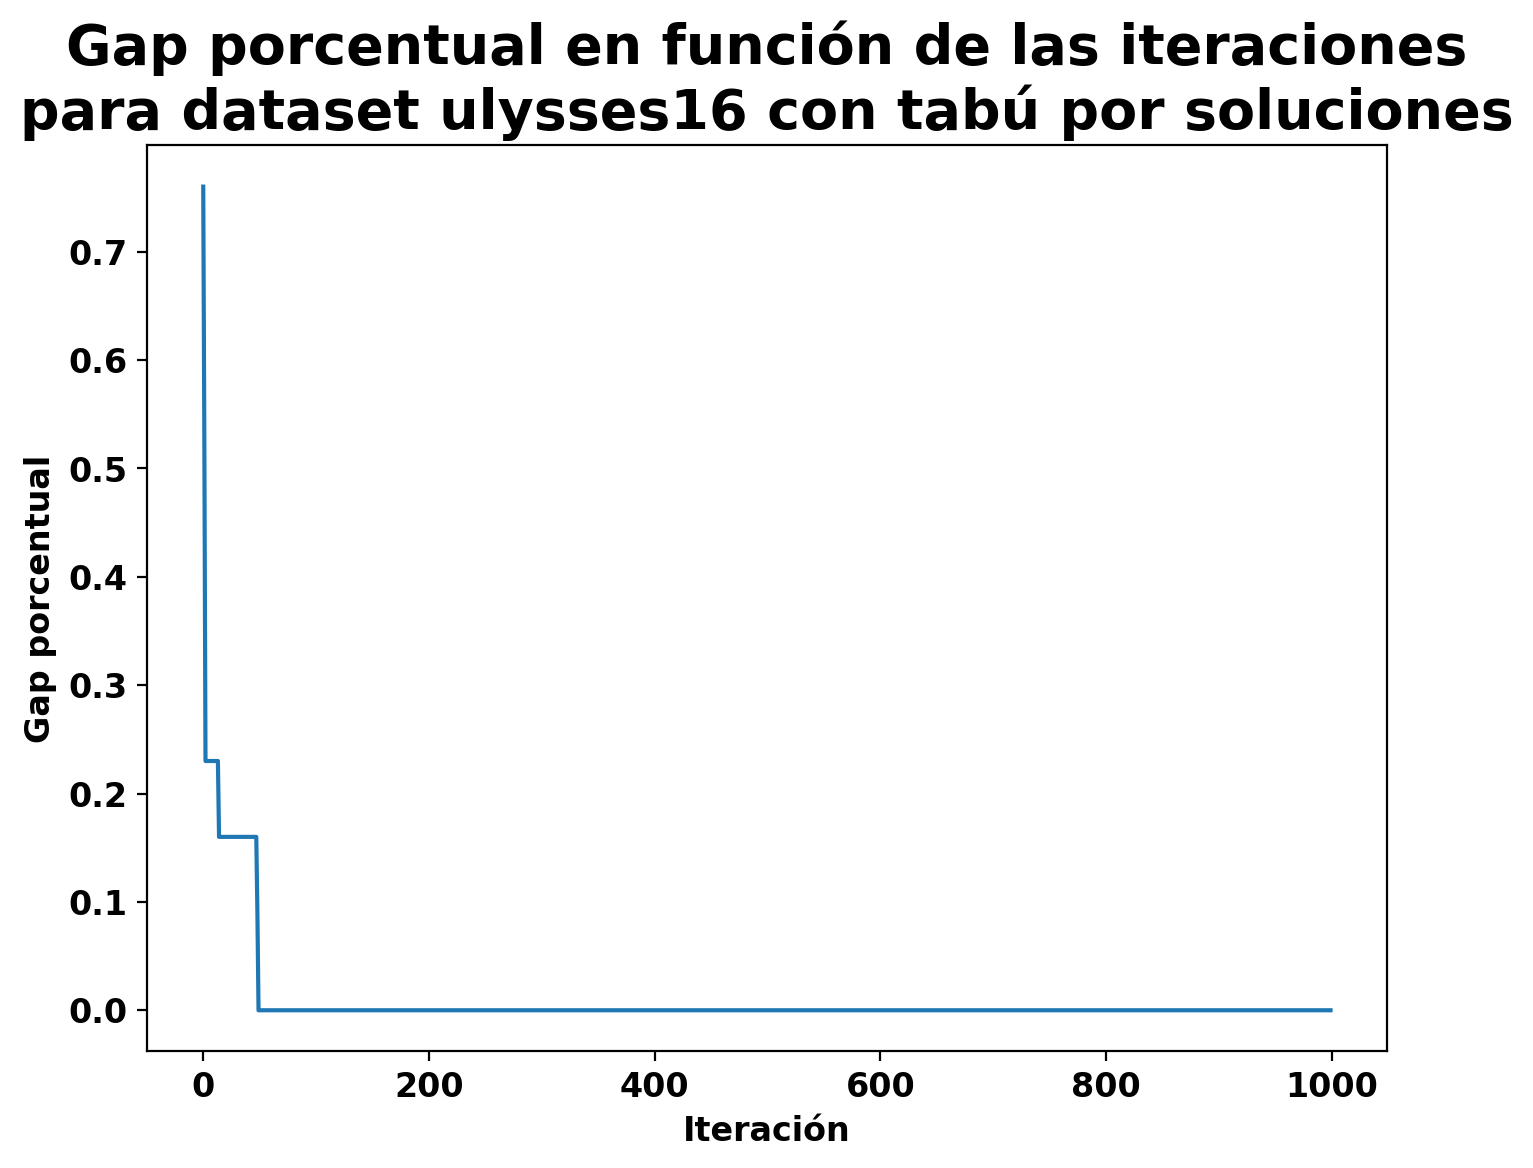

<Figure size 432x288 with 0 Axes>

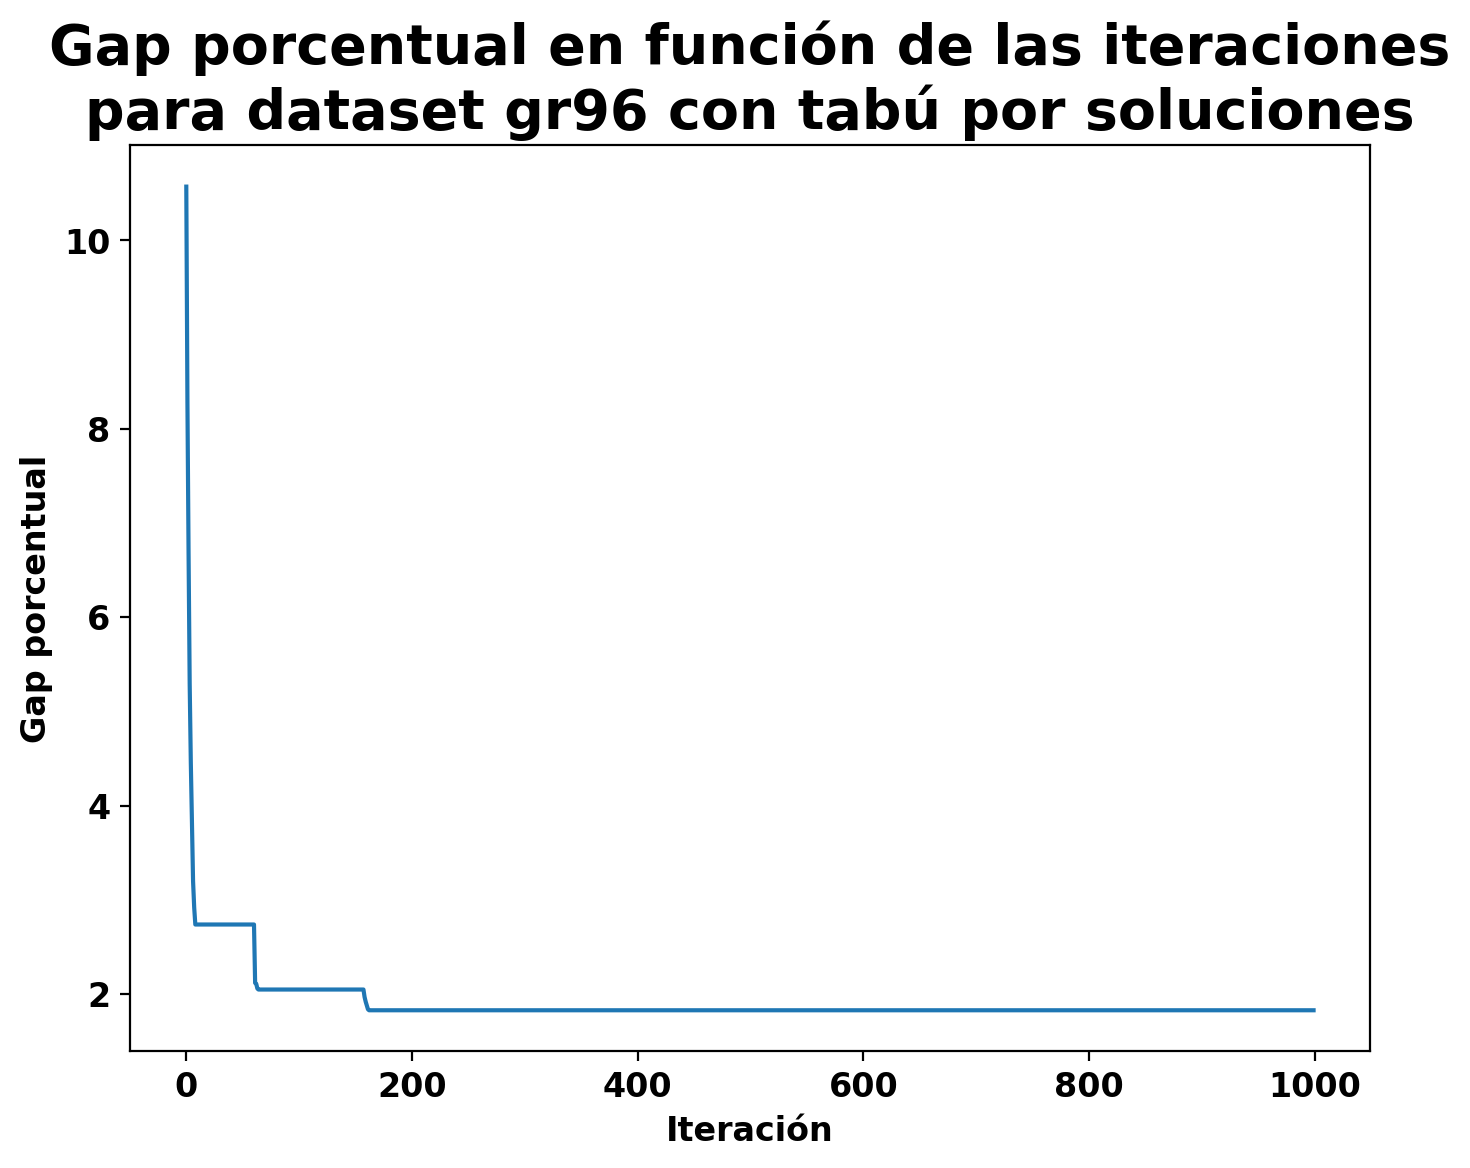

<Figure size 432x288 with 0 Axes>

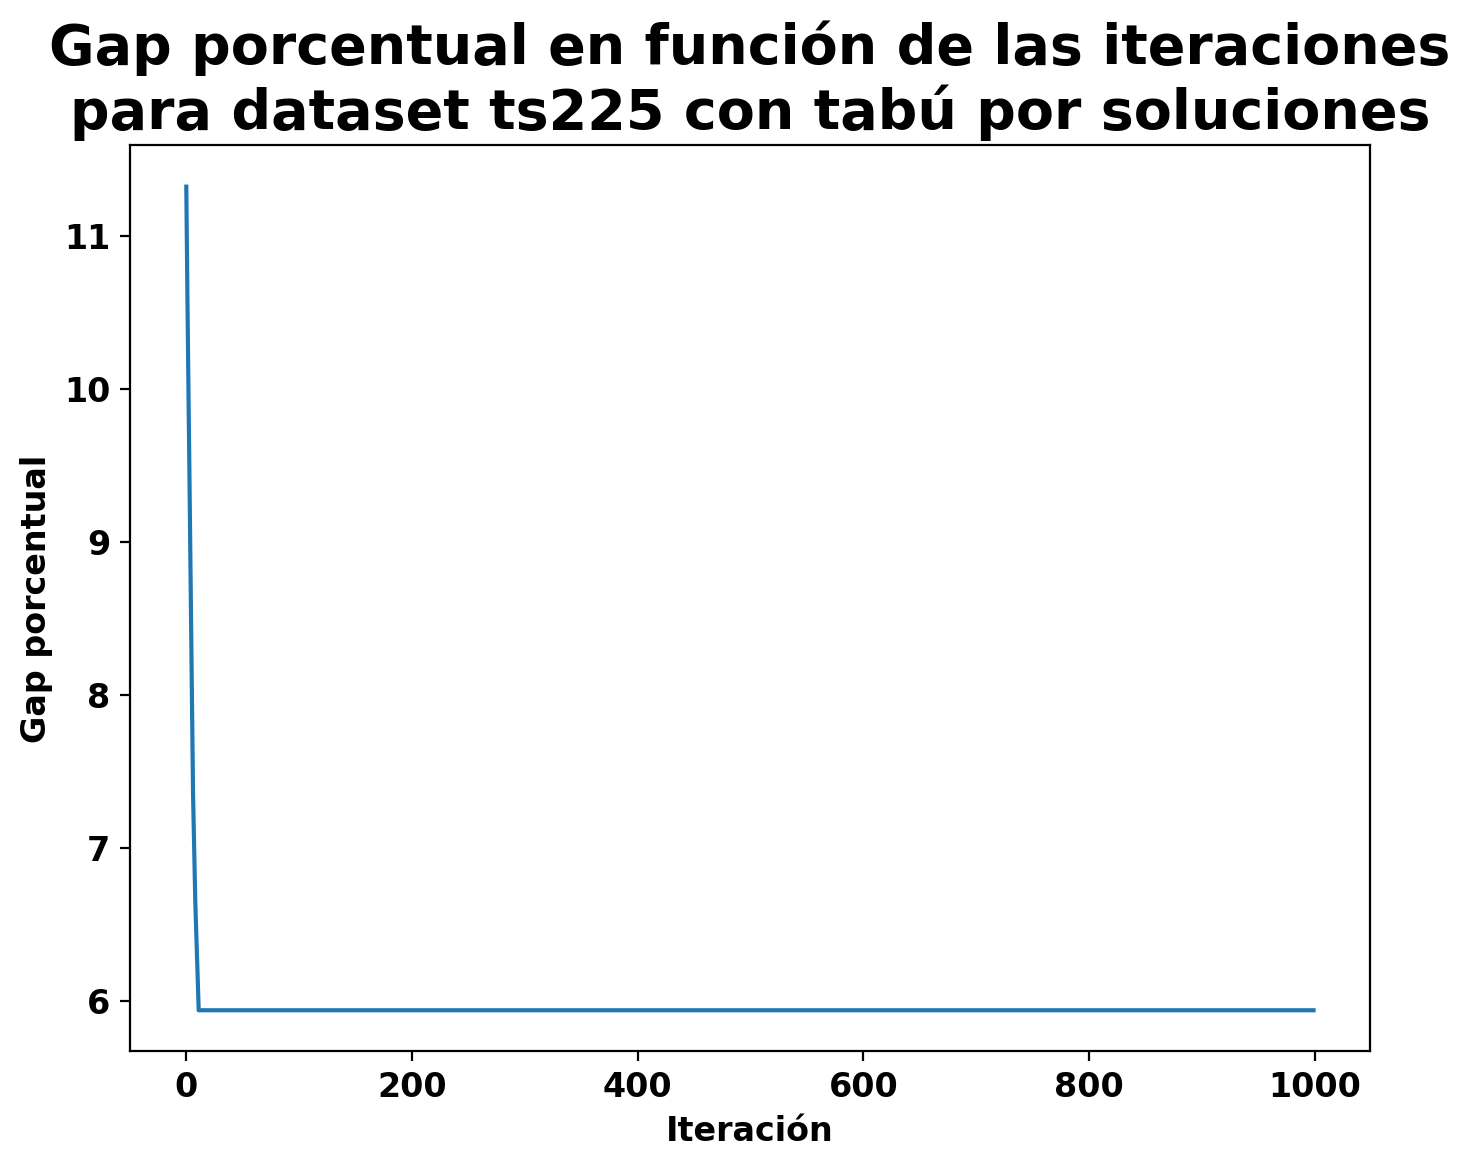

<Figure size 432x288 with 0 Axes>

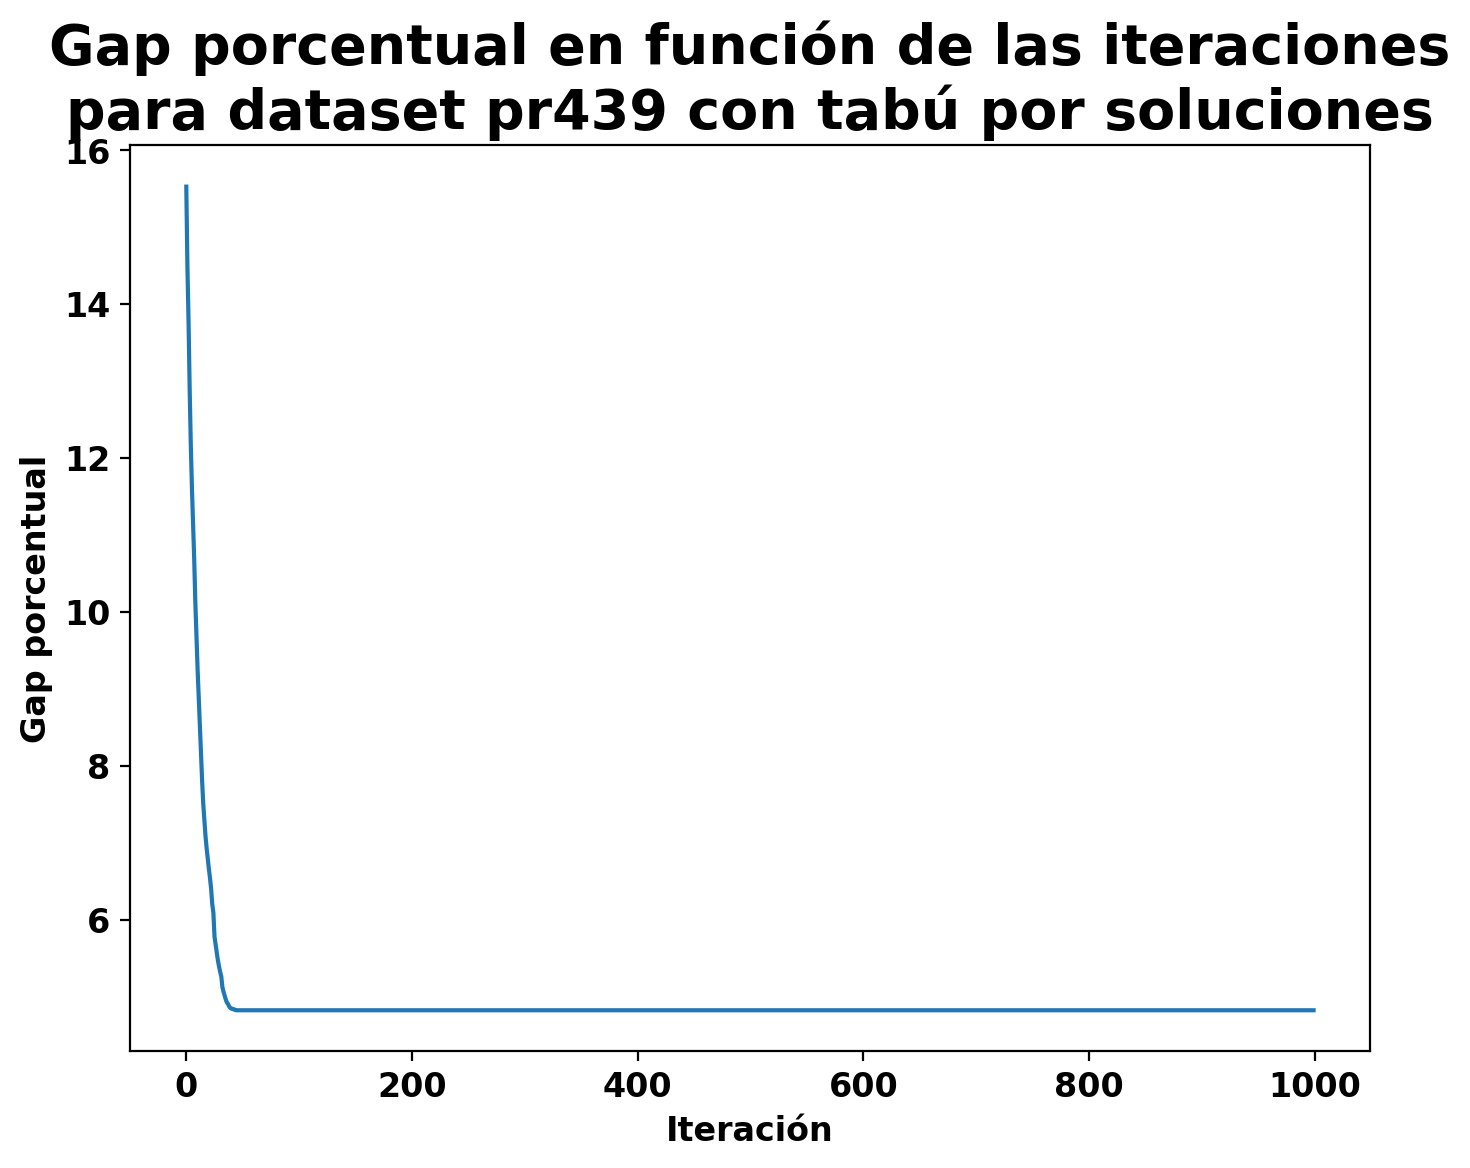

<Figure size 432x288 with 0 Axes>

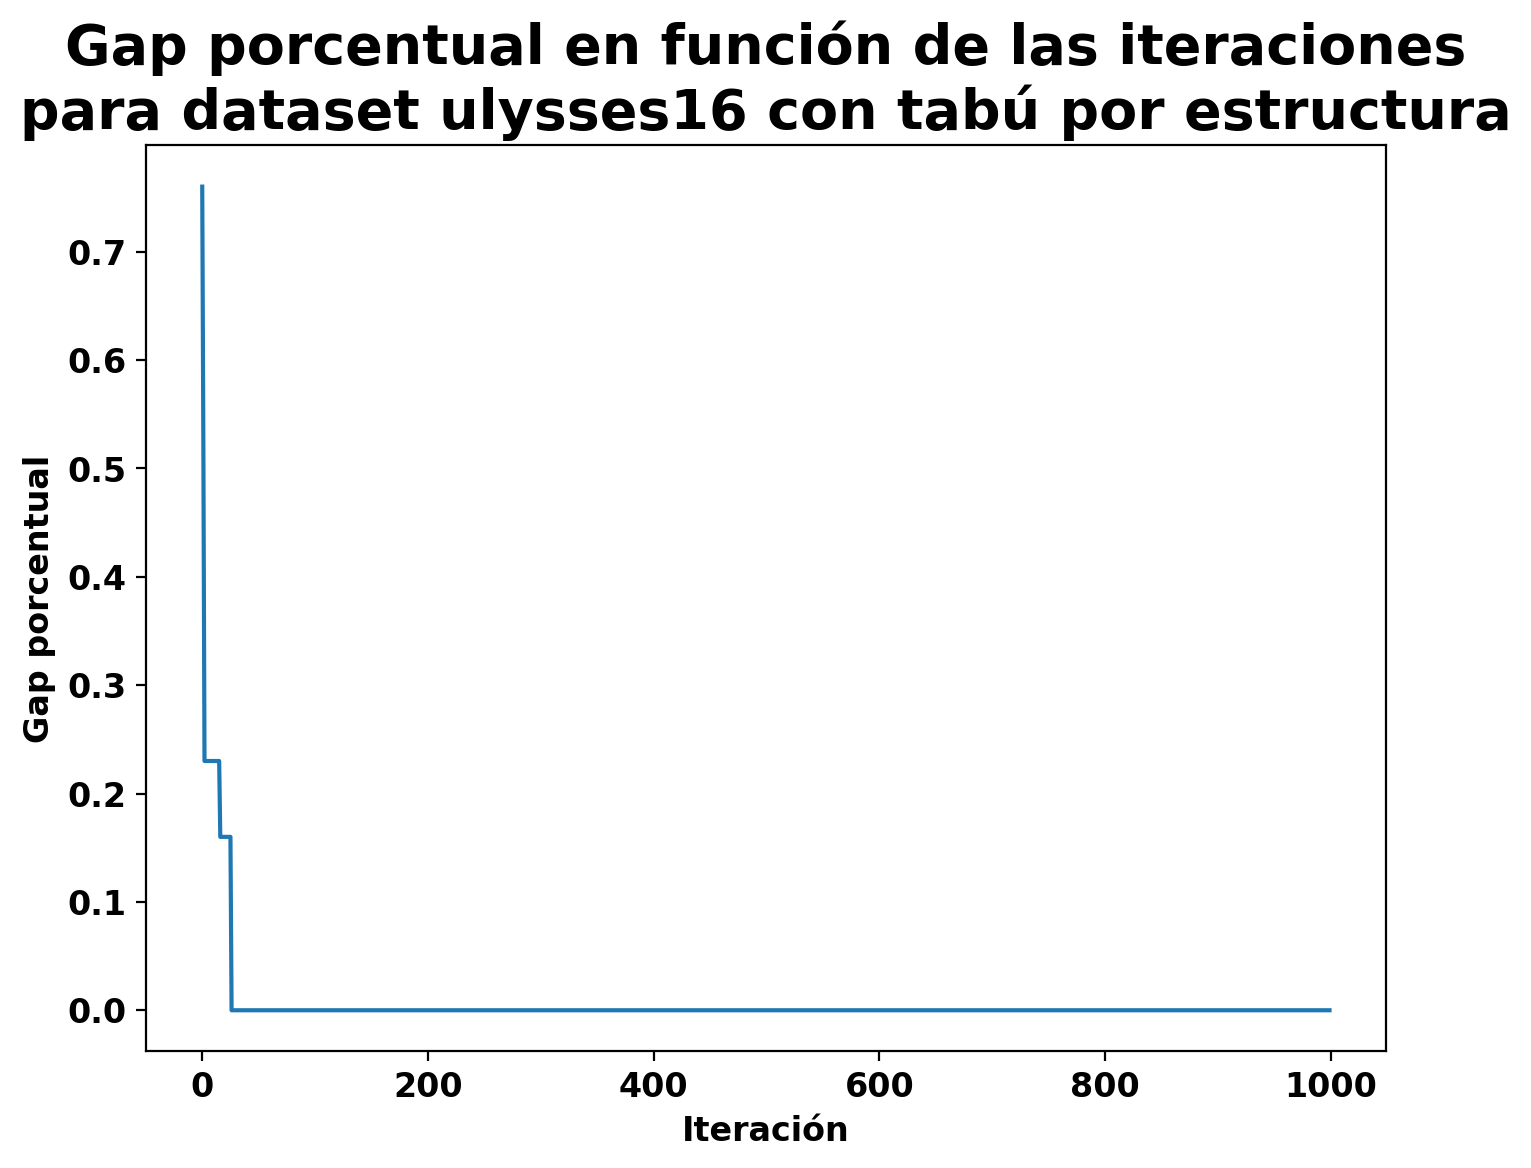

<Figure size 432x288 with 0 Axes>

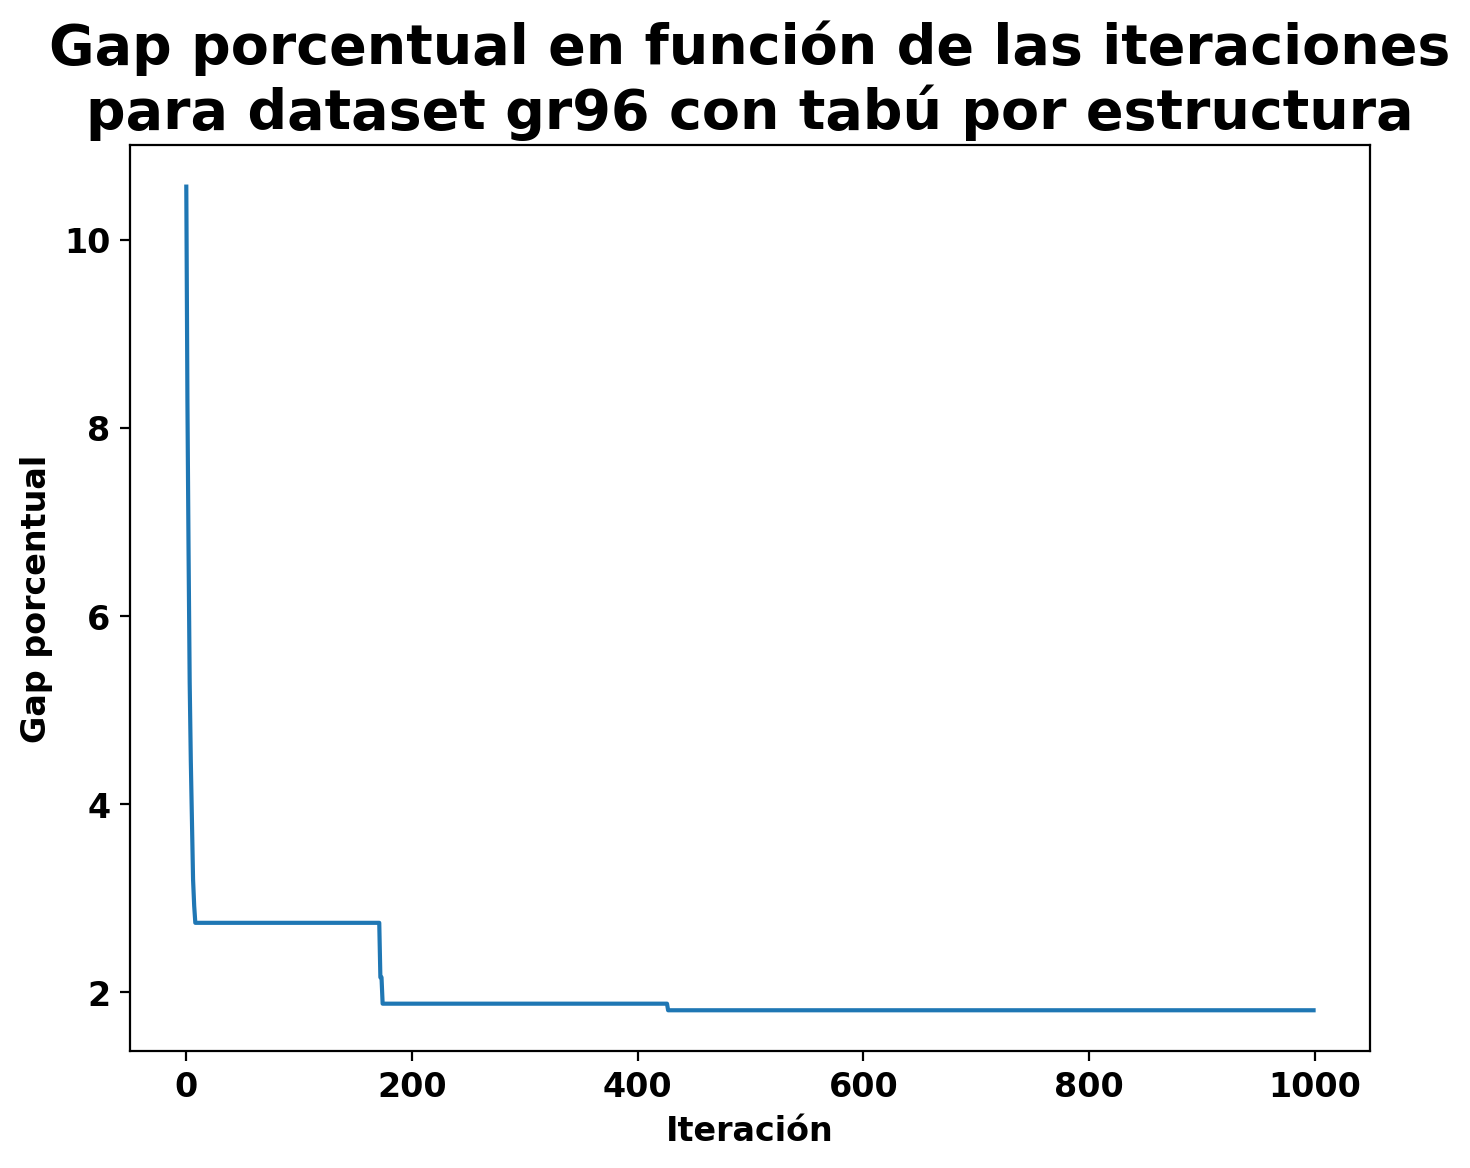

<Figure size 432x288 with 0 Axes>

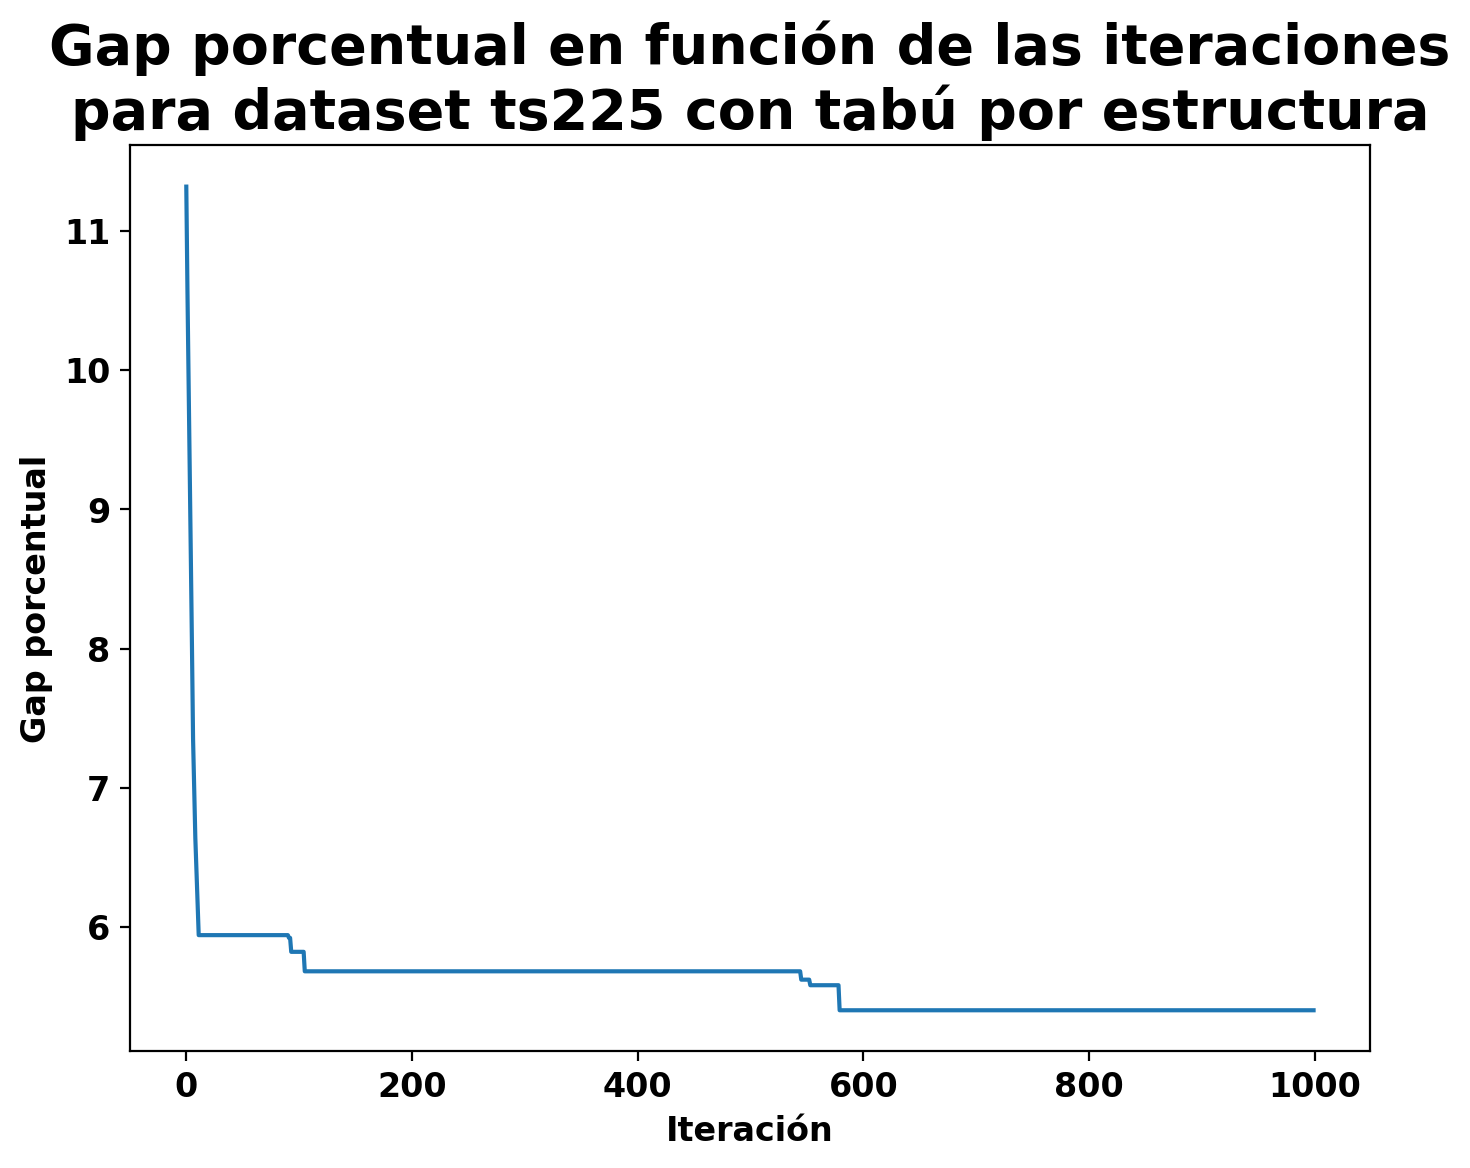

<Figure size 432x288 with 0 Axes>

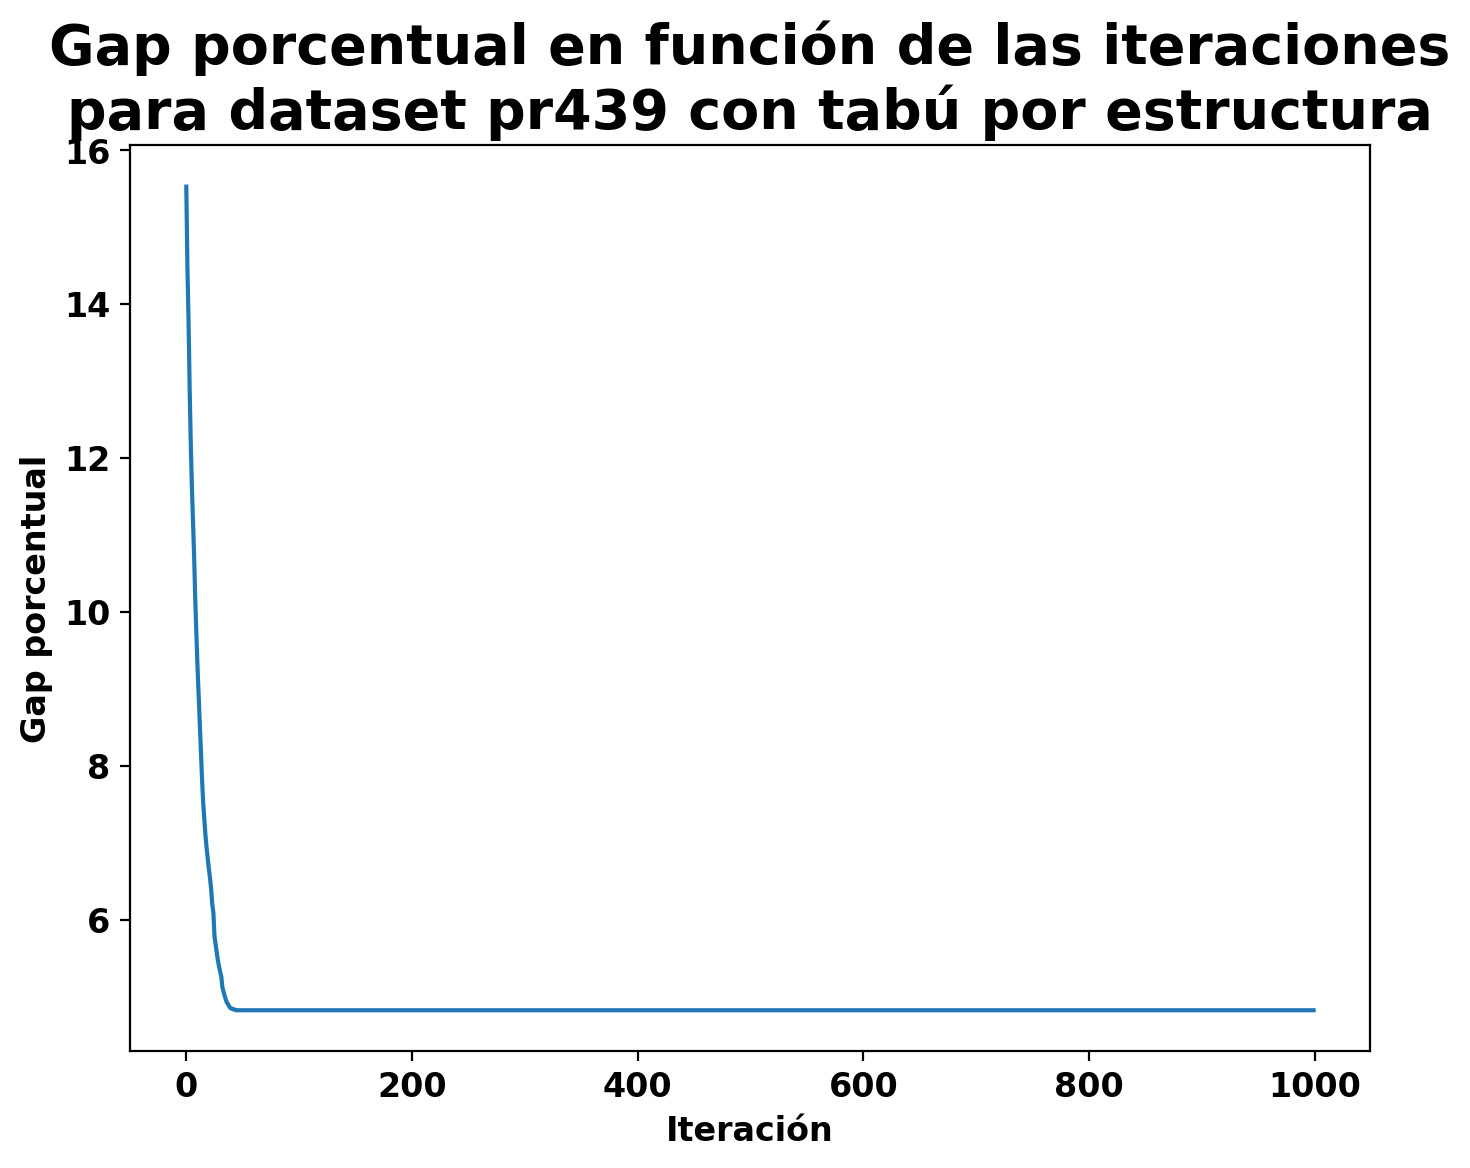

In [10]:
files = ['ulysses16', 'gr96', 'ts225', 'pr439']
for file in files:
    vecindadesLine(dfMem, 'Gap porcentual', file, save=False, out=f'graficos/GapVsIter/{file}GapVsIterMem.png', algoritmo='soluciones')  
    
for file in files:
    vecindadesLine(dfEst, 'Gap porcentual', file, save=False, out=f'graficos/GapVsIter/{file}GapVsIterEst.png', algoritmo='estructura')    

## Vamos a ver como influye variar la memoria en Tabu. Ambas veces seteamos la %vecinos en 100%.
## Empezamos graficando boxplots del GAP% vs Memoria para tabu por solucion

In [11]:
def pesoToGap(df, dfOptimos, columnas):
    
    
    for index, rows in df.iterrows():
        for columna in columnas:
            archivo = rows['Archivo']

            if not dfOptimos.loc[archivo]['Conocida']:
                continue
            df.at[index, columna] = np.round(gapRelativo(dfOptimos.loc[archivo]['CotaInferior'], df.at[index, columna]),2)
    
    return df

In [12]:
def memoriasToBoxplot(df, title, Xlabel, Ylabel, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
#     plt.ylim(-200,7500)
#     plt.ylim(-0.5,11)
    
    #Seteamos titulo y labels
    plt.title(title, fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel(Xlabel, fontsize =LABELSIZE)
    plt.ylabel(Ylabel, fontsize =LABELSIZE)
    
    #Graficamos los BP
    bp = sns.boxplot(data=df, ax=ax)
    
    #Calculamos las medianas
    medians = df.median().tolist()
    
    for xtick in bp.get_xticks():
        bp.text(xtick,medians[xtick] + 0.1, '{:.2f}'.format(medians[xtick]), 
            horizontalalignment='center',size='small',color='w',weight='bold')

    plt.tight_layout()
    if save and out != '':
        plt.savefig(out)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

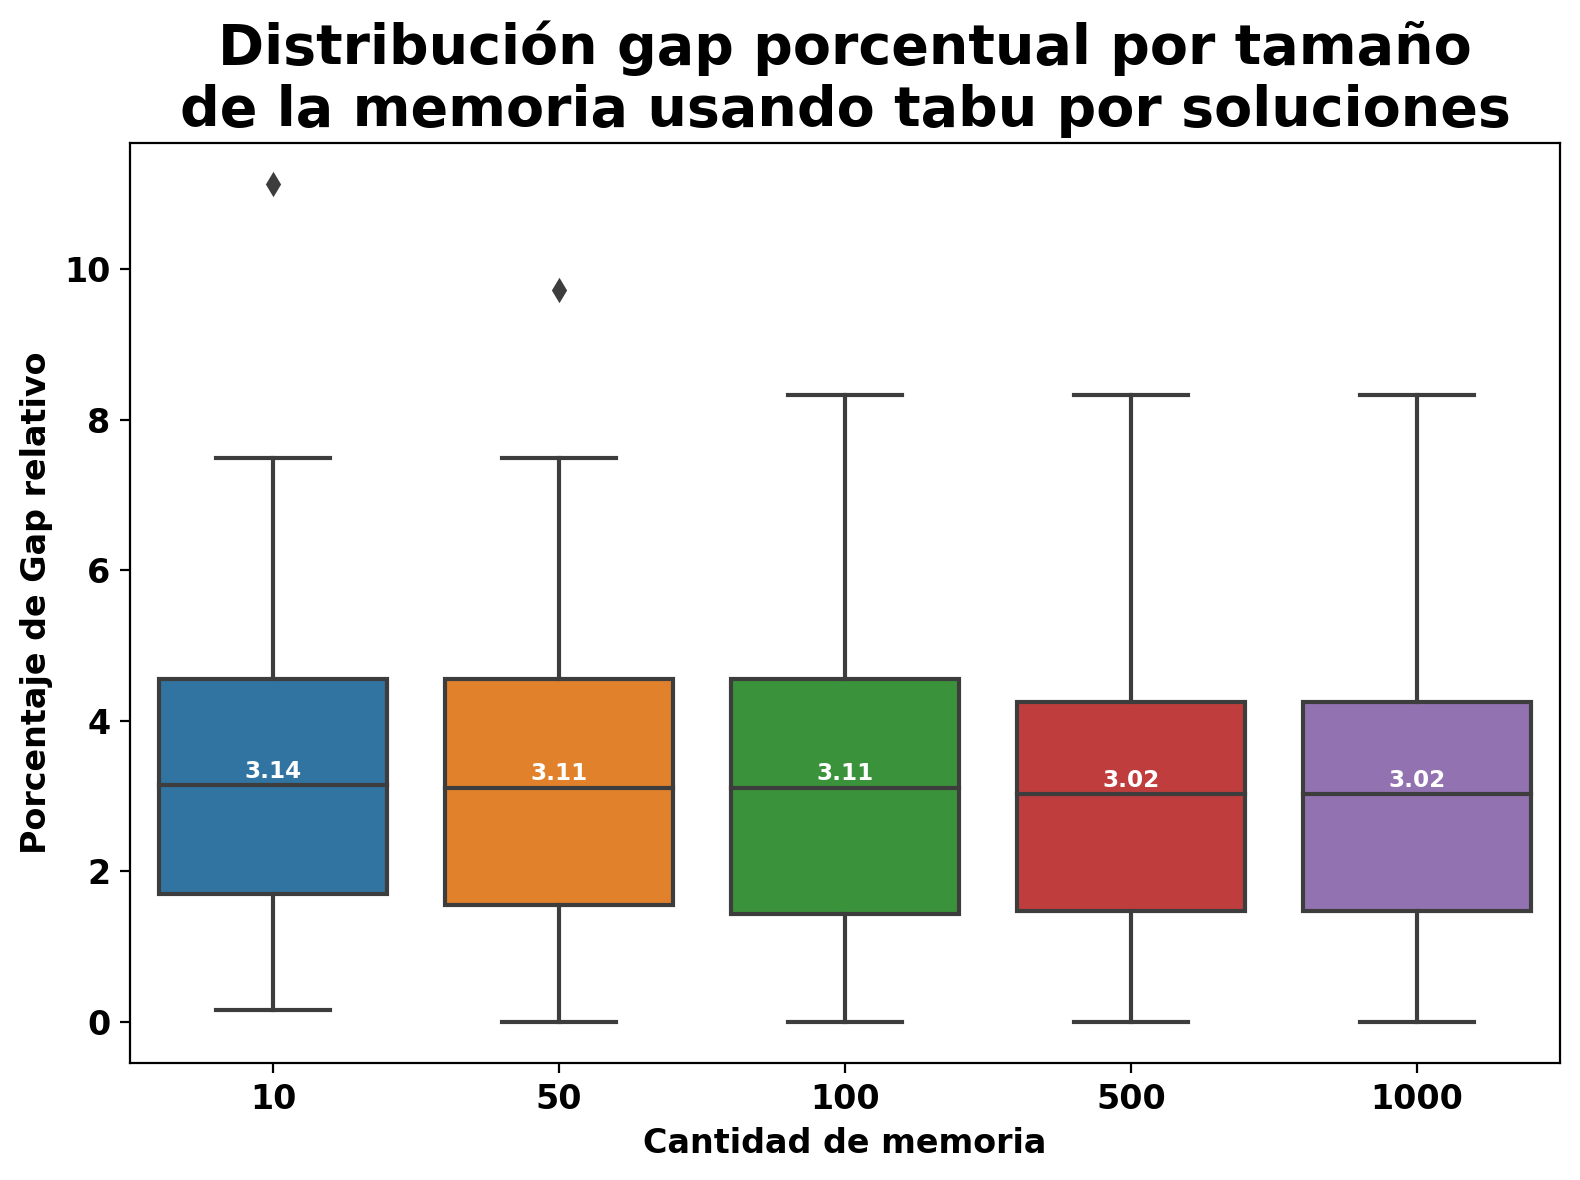

In [13]:
dfMemorias = pathToPandasTabu('DataMemoria/', 'mem').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
dfMemorias = pesoToGap(dfMemorias, dfOptimos, dfMemorias.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfMemorias.drop(['CantNodos'], axis=1), 'Distribución gap porcentual por tamaño\nde la memoria usando tabu por soluciones', 'Cantidad de memoria', 'Porcentaje de Gap relativo')

## Ahora veamos como se modifica el tiempo graficando boxplots del Tiempo vs Memoria para tabu por solucion

<Figure size 432x288 with 0 Axes>

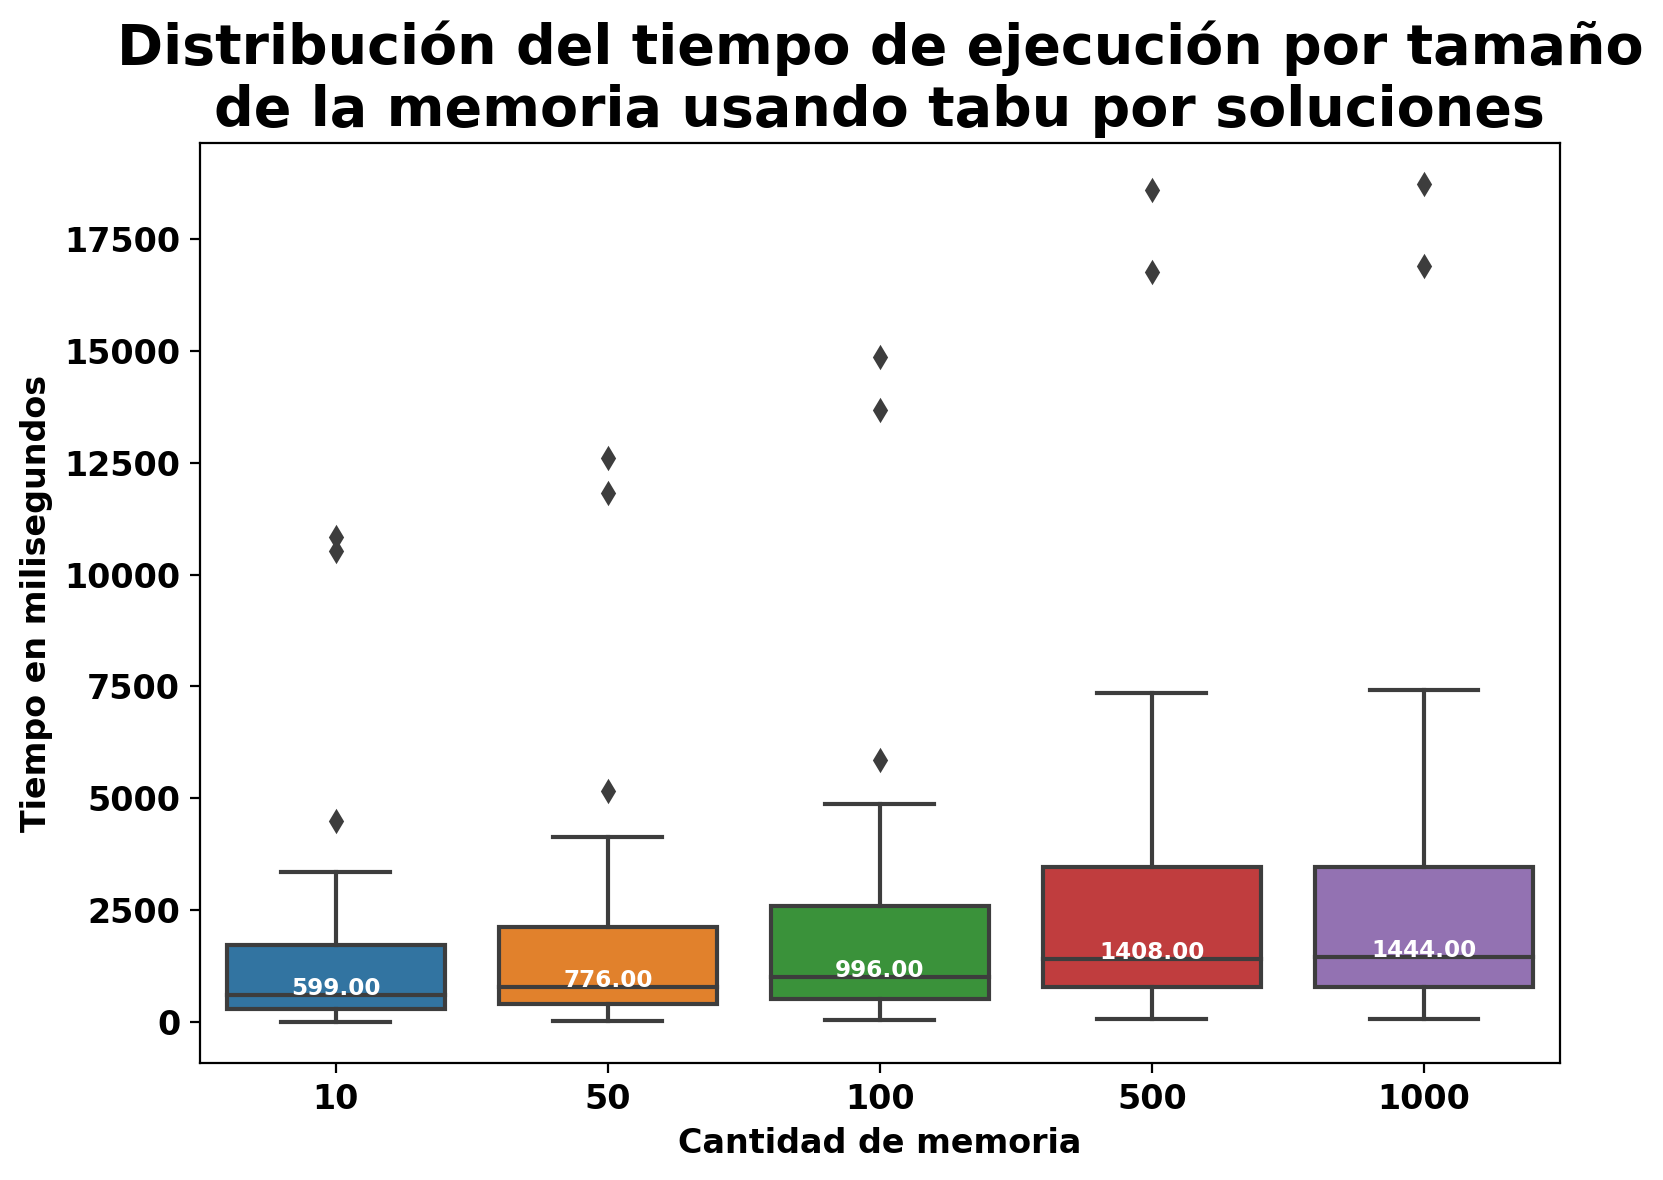

In [14]:
dfMemoriasTiempos = pathToPandasTabu('DataMemoria/', 'timeMem').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
memoriasToBoxplot(dfMemoriasTiempos.drop(['CantNodos'], axis=1), 'Distribución del tiempo de ejecución por tamaño\nde la memoria usando tabu por soluciones', 'Cantidad de memoria', 'Tiempo en milisegundos', save=False, out='graficos/tiempoVsMem_tabuMem.png')

## Chequeamos GAP% vs Memoria en tabu por estructura

<Figure size 432x288 with 0 Axes>

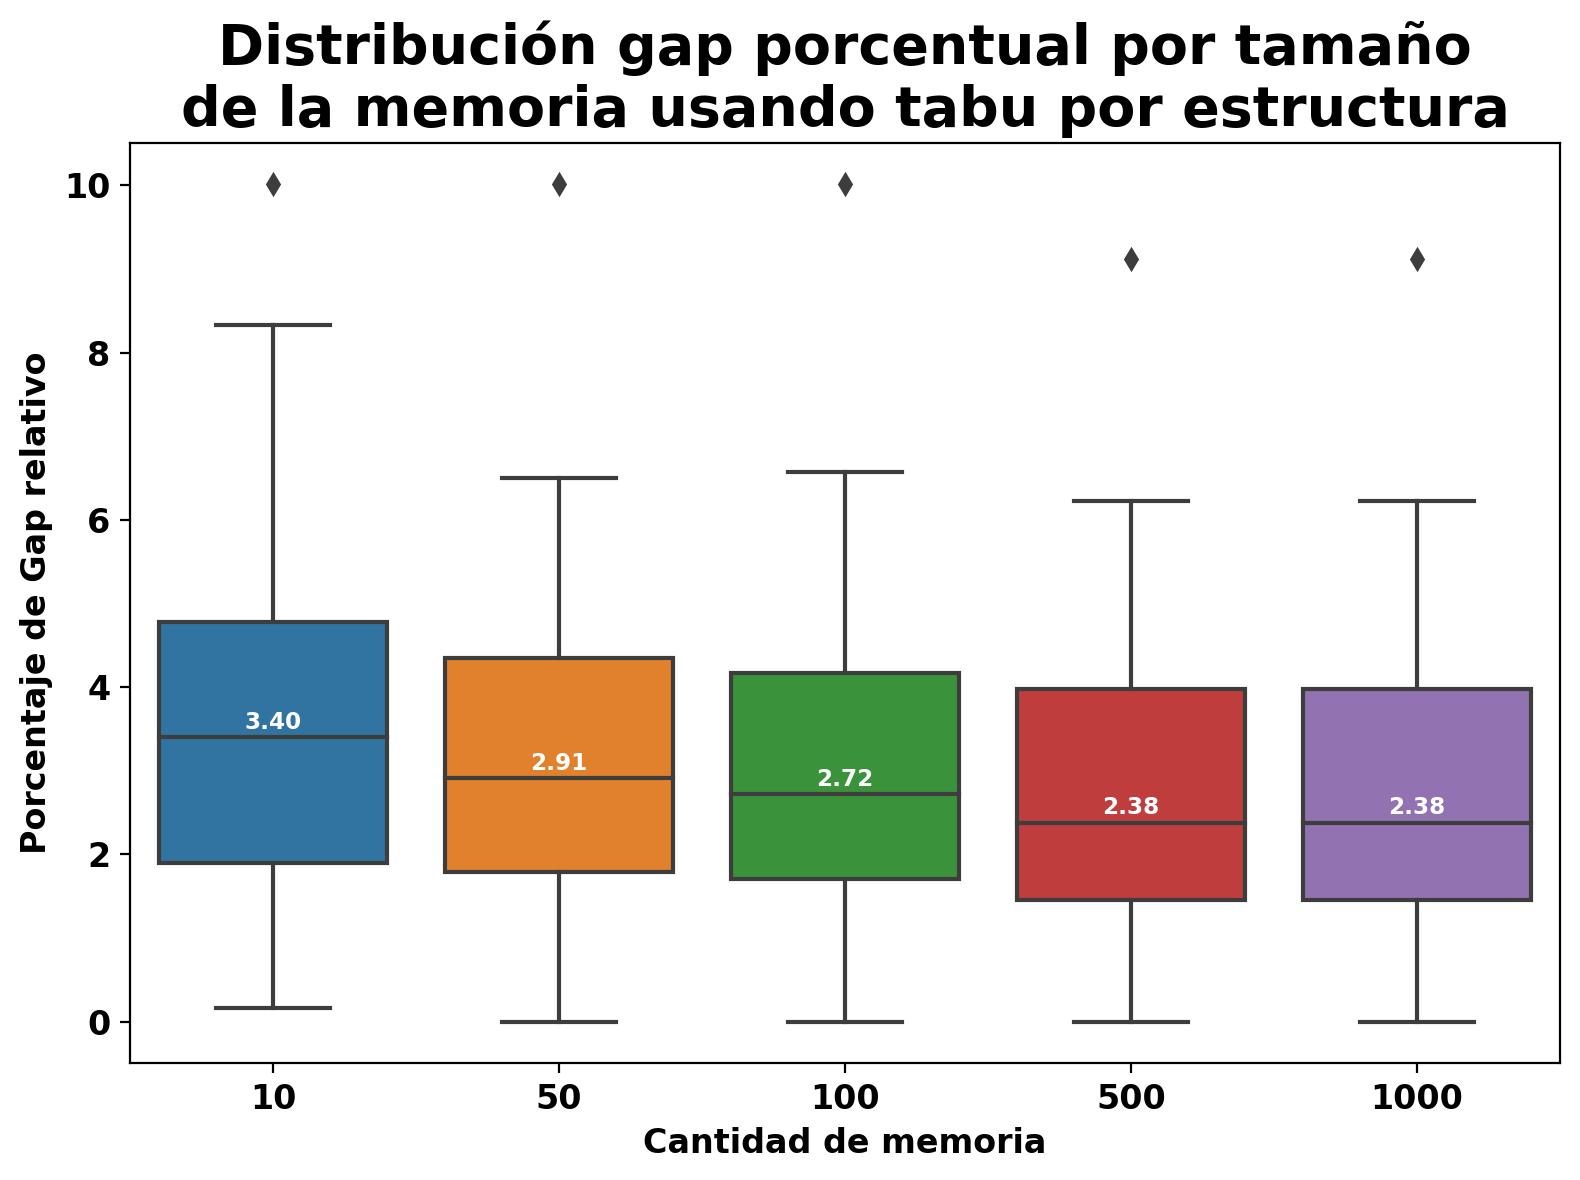

In [15]:
dfEst = pathToPandasTabu('DataMemoria/', 'est').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
dfEst = pesoToGap(dfEst, dfOptimos, dfEst.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfEst.drop(['CantNodos'], axis=1), 'Distribución gap porcentual por tamaño\nde la memoria usando tabu por estructura', 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=False, out='graficos/gapVsMem_tabuEst.png')

## Volvemos a ver como se afecta el tiempo graficando Tiempo vs Memoria en tabu por estructura

<Figure size 432x288 with 0 Axes>

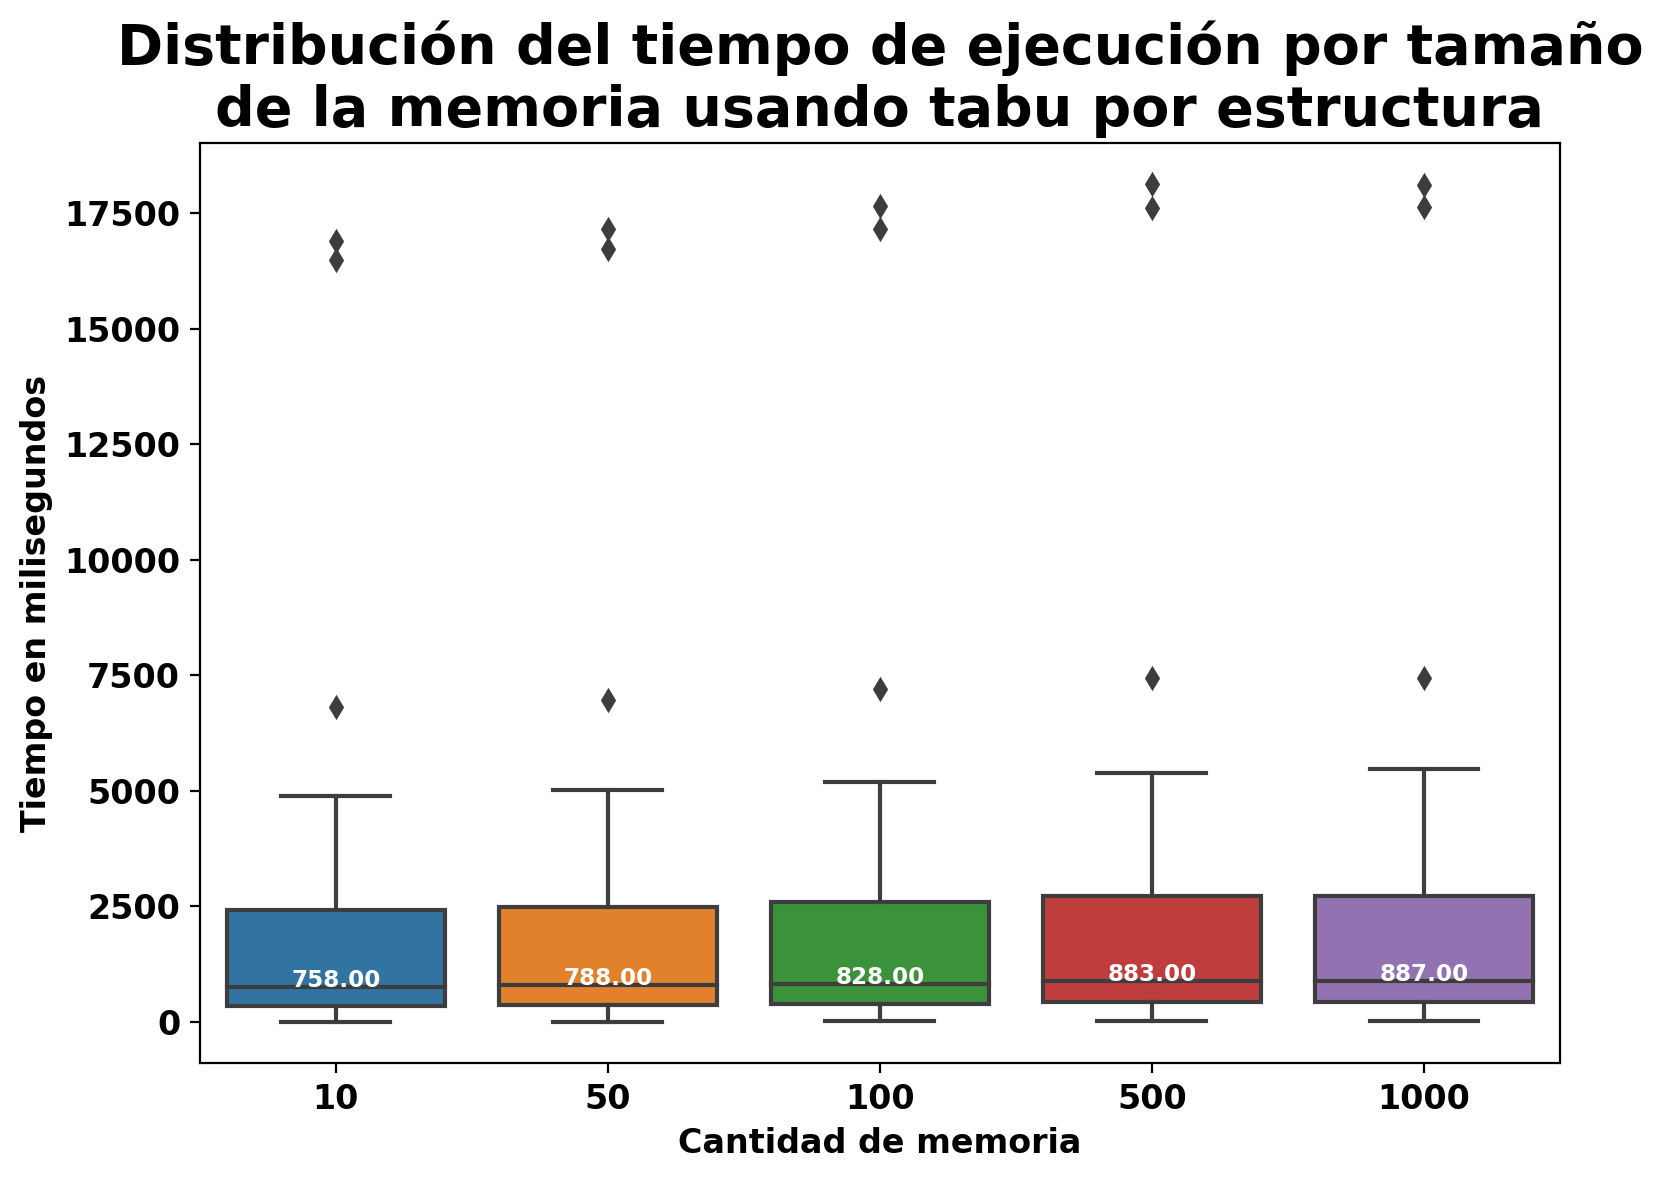

In [16]:
dfEstTiempos = pathToPandasTabu('DataMemoria/', 'timeEst').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
memoriasToBoxplot(dfEstTiempos.drop(['CantNodos'], axis=1), 'Distribución del tiempo de ejecución por tamaño\nde la memoria usando tabu por estructura', 'Cantidad de memoria', 'Tiempo en milisegundos', save=False, out='graficos/tiempoVsMem_tabuEst.png')

## Para elegir la memoria a usar vamos a segmentar el df anterior por tamanios a ver si para df mas grandes conviene usar mas memoria

In [17]:
dfEstChicos = dfEst.sort_values('CantNodos')[:9].reset_index().drop(['index'], axis=1)
dfEstMedioChicos = dfEst.sort_values('CantNodos')[9:17].reset_index().drop(['index'], axis=1)
dfEstMedioGrandes = dfEst.sort_values('CantNodos')[17:26].reset_index().drop(['index'], axis=1)
dfEstGrandes = dfEst.sort_values('CantNodos')[26:].reset_index().drop(['index'], axis=1)

<Figure size 432x288 with 0 Axes>

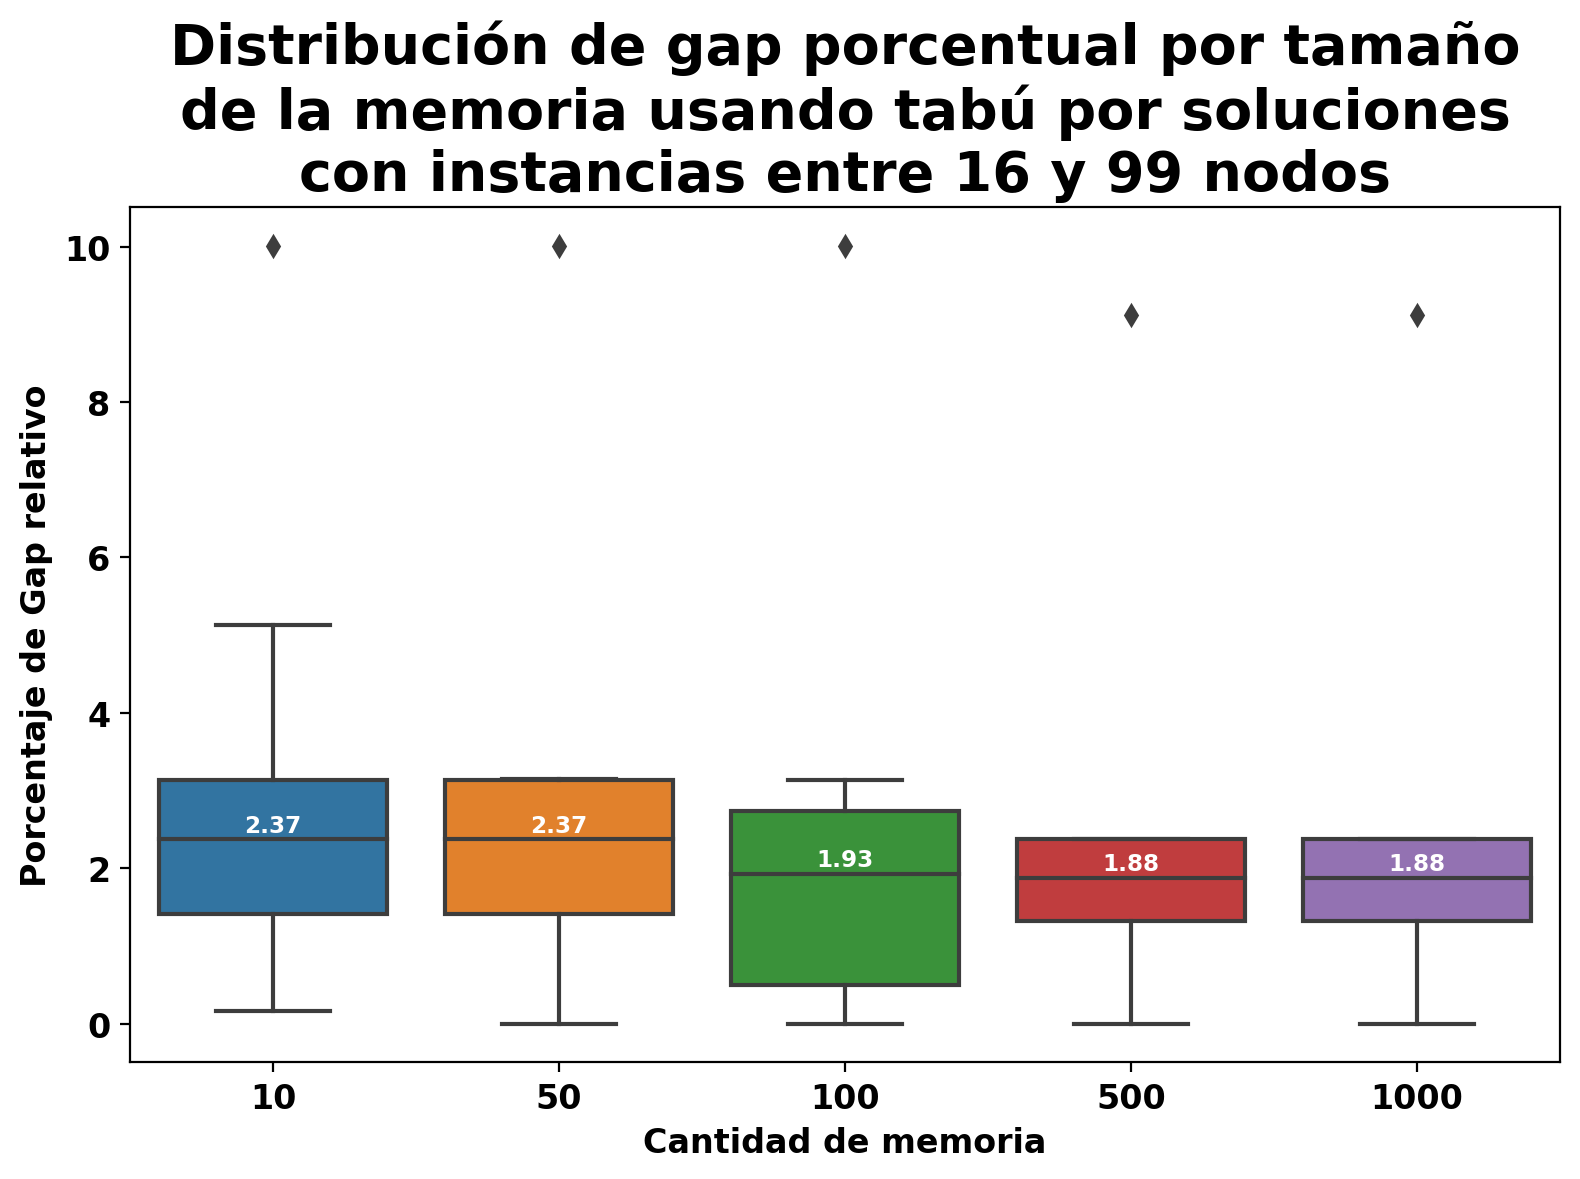

In [18]:
memoriasToBoxplot(dfEstChicos.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstChicos.loc[0]['CantNodos']} y {dfEstChicos.loc[len(dfEstChicos)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=False, out='graficos/GapVsMemChicos_est.png')

<Figure size 432x288 with 0 Axes>

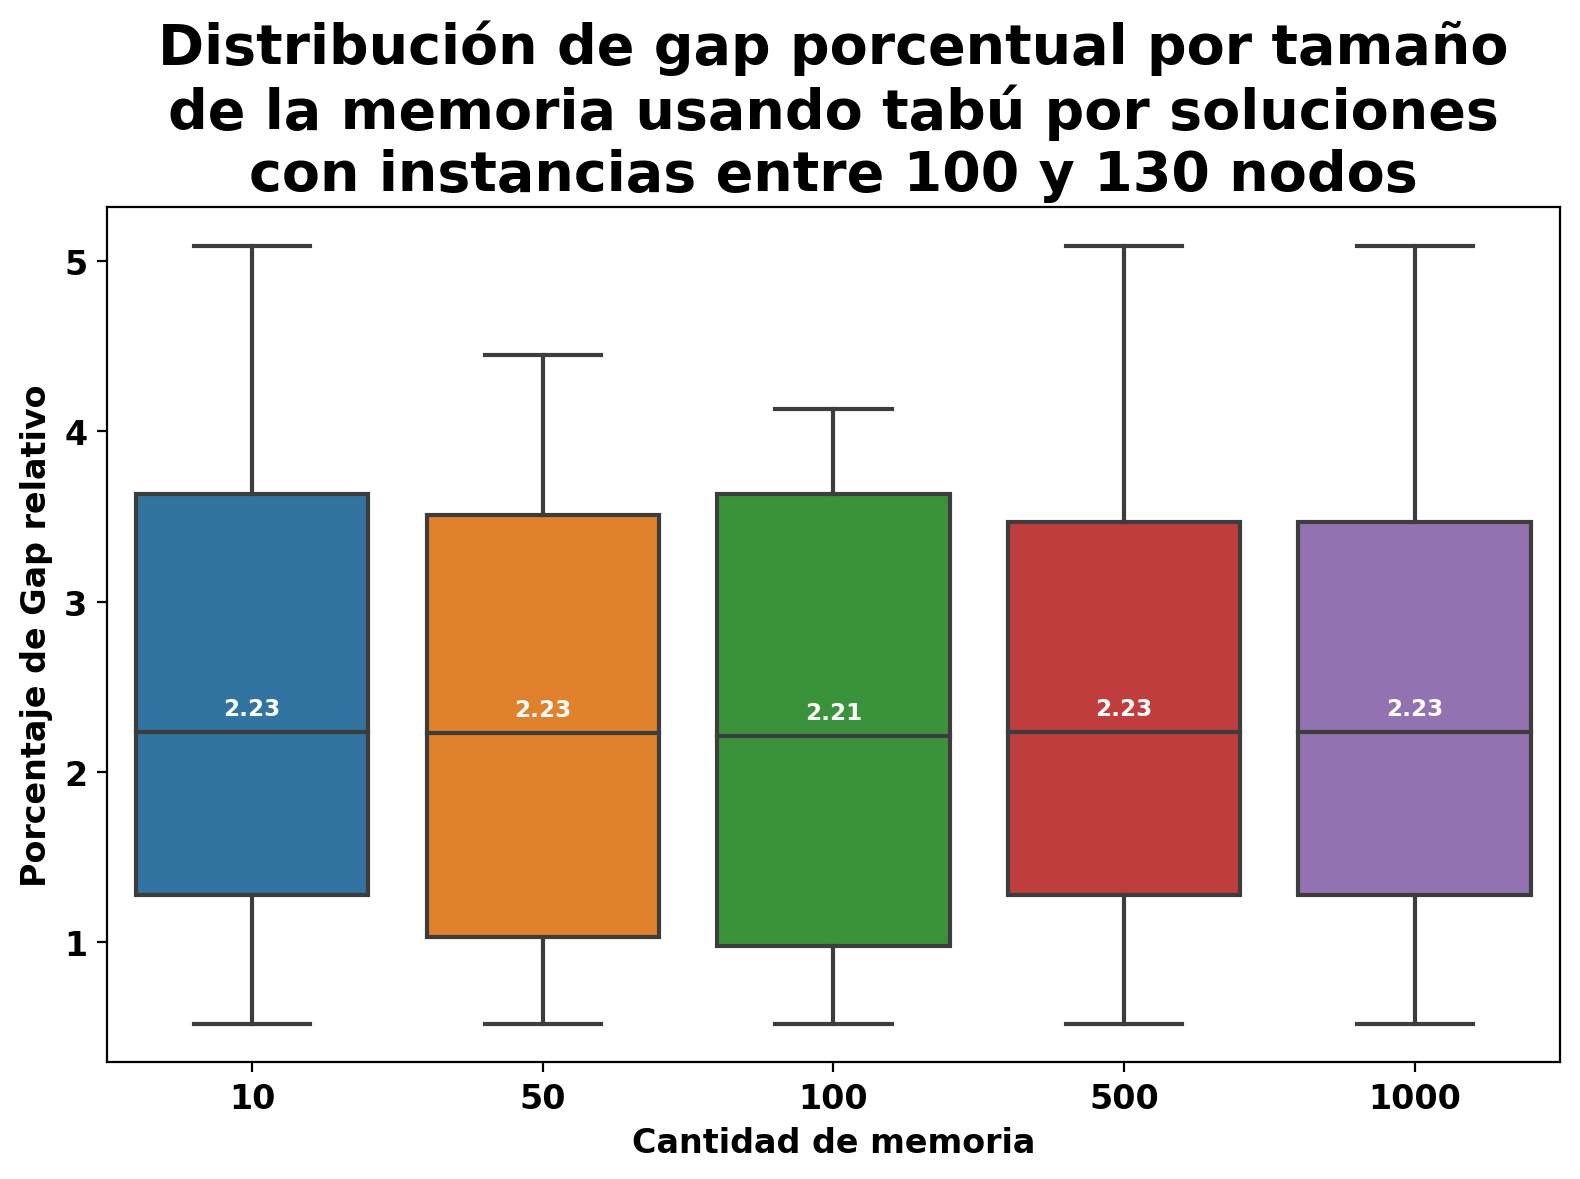

In [19]:
memoriasToBoxplot(dfEstMedioChicos.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstMedioChicos.loc[0]['CantNodos']} y {dfEstMedioChicos.loc[len(dfEstMedioChicos)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=False, out='graficos/GapVsMemMedioChicos_est.png')

<Figure size 432x288 with 0 Axes>

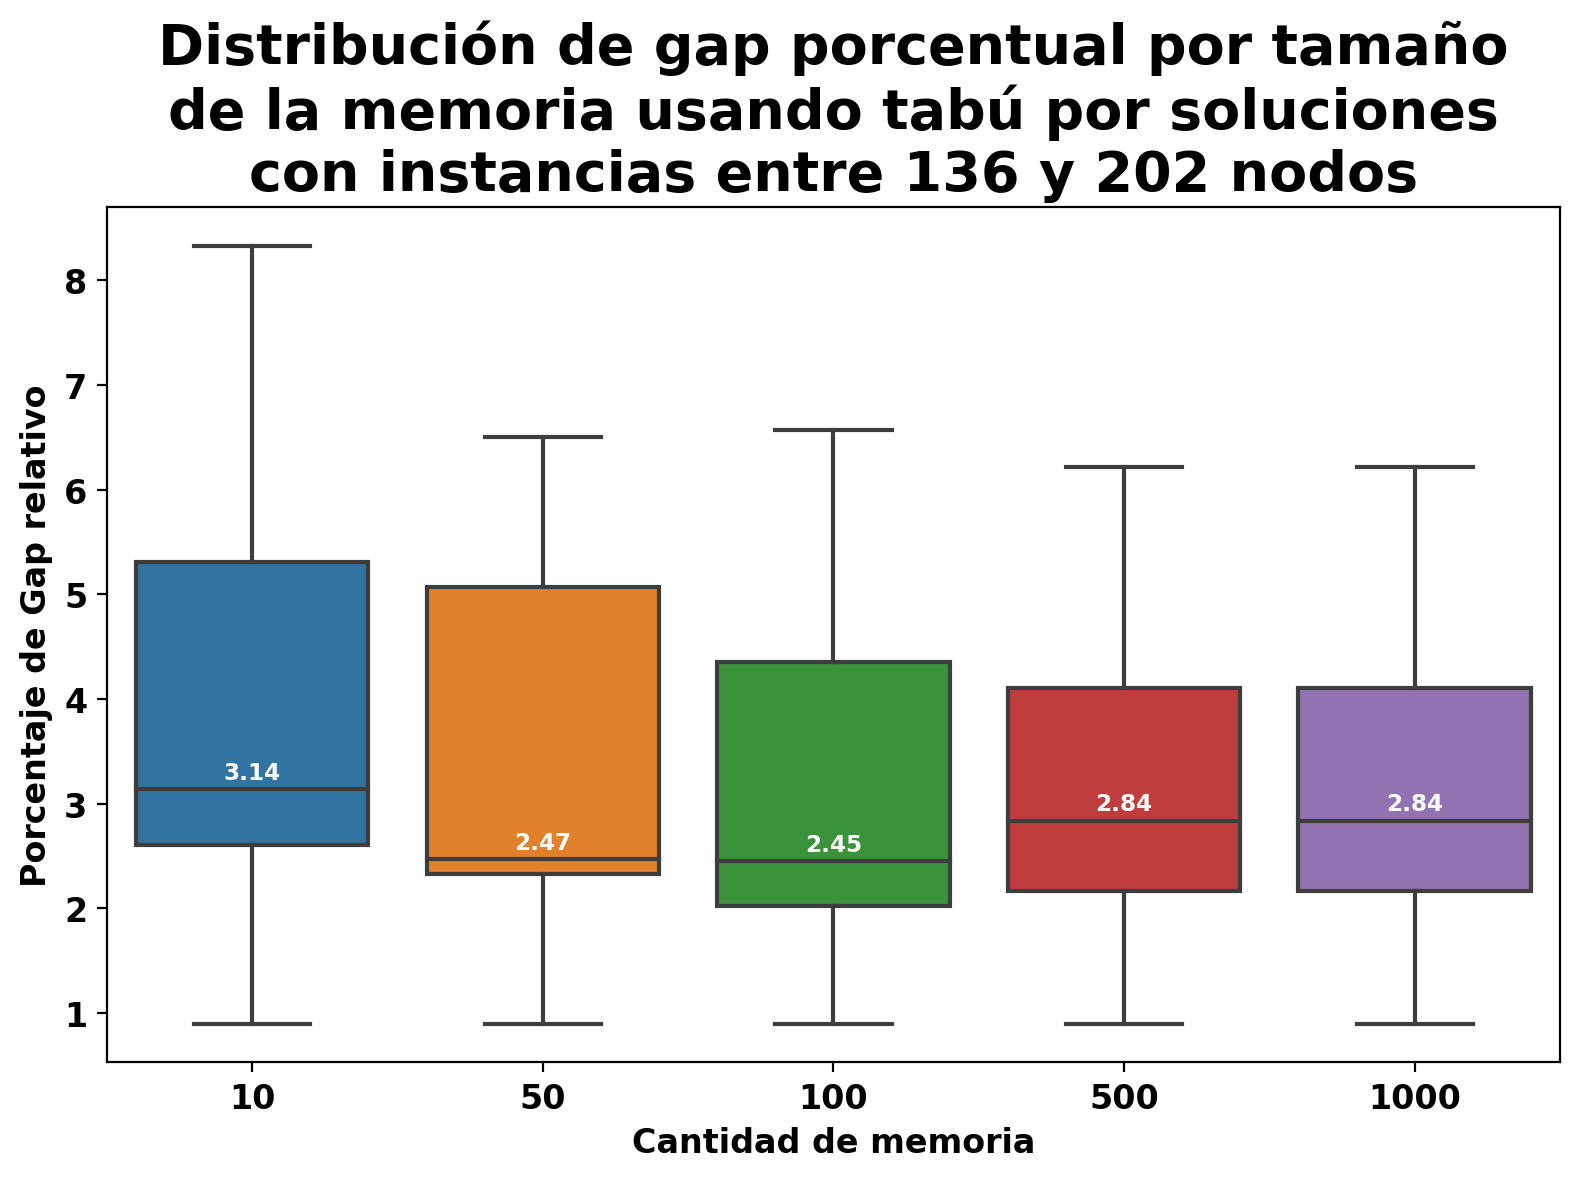

In [20]:
memoriasToBoxplot(dfEstMedioGrandes.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstMedioGrandes.loc[0]['CantNodos']} y {dfEstMedioGrandes.loc[len(dfEstMedioGrandes)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=False, out='graficos/GapVsMemMedioGrandes_est.png')

<Figure size 432x288 with 0 Axes>

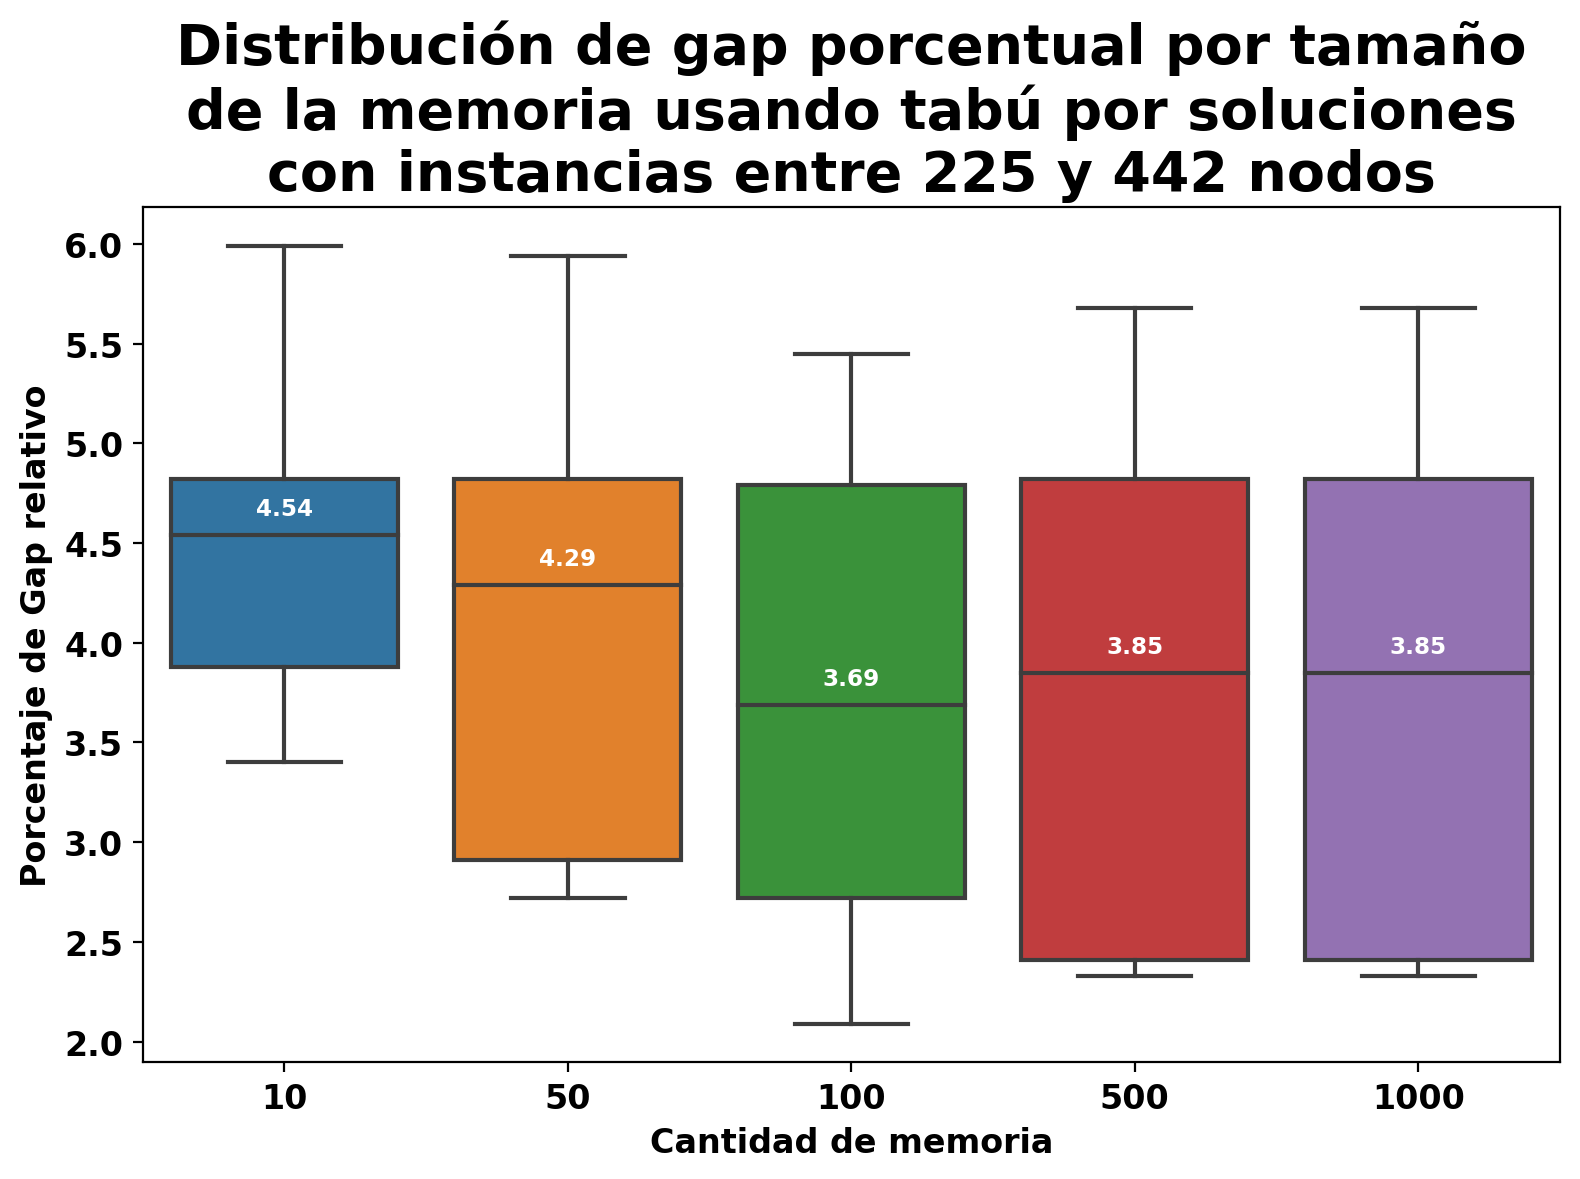

In [21]:
memoriasToBoxplot(dfEstGrandes.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstGrandes.loc[0]['CantNodos']} y {dfEstGrandes.loc[len(dfEstGrandes)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=False, out='graficos/GapVsMemGrandes_est.png')

## Como vimos que no hay un incremento considerable en el tiempo al aumentar la memoria en estructura nos vamos a quedar con memorias 500 y 1000 que son las 2 mas performantes

## En tabu por soluciones nos quedamos con 50 y 100, ya que aca si hay un aumento fulero de tiempo al aumentar la memoria.

# Ahora toca variar la vecindad

## Boxplots gaps variando porcentaje vecindad en tabu por soluciones para memoria = 50.

<Figure size 432x288 with 0 Axes>

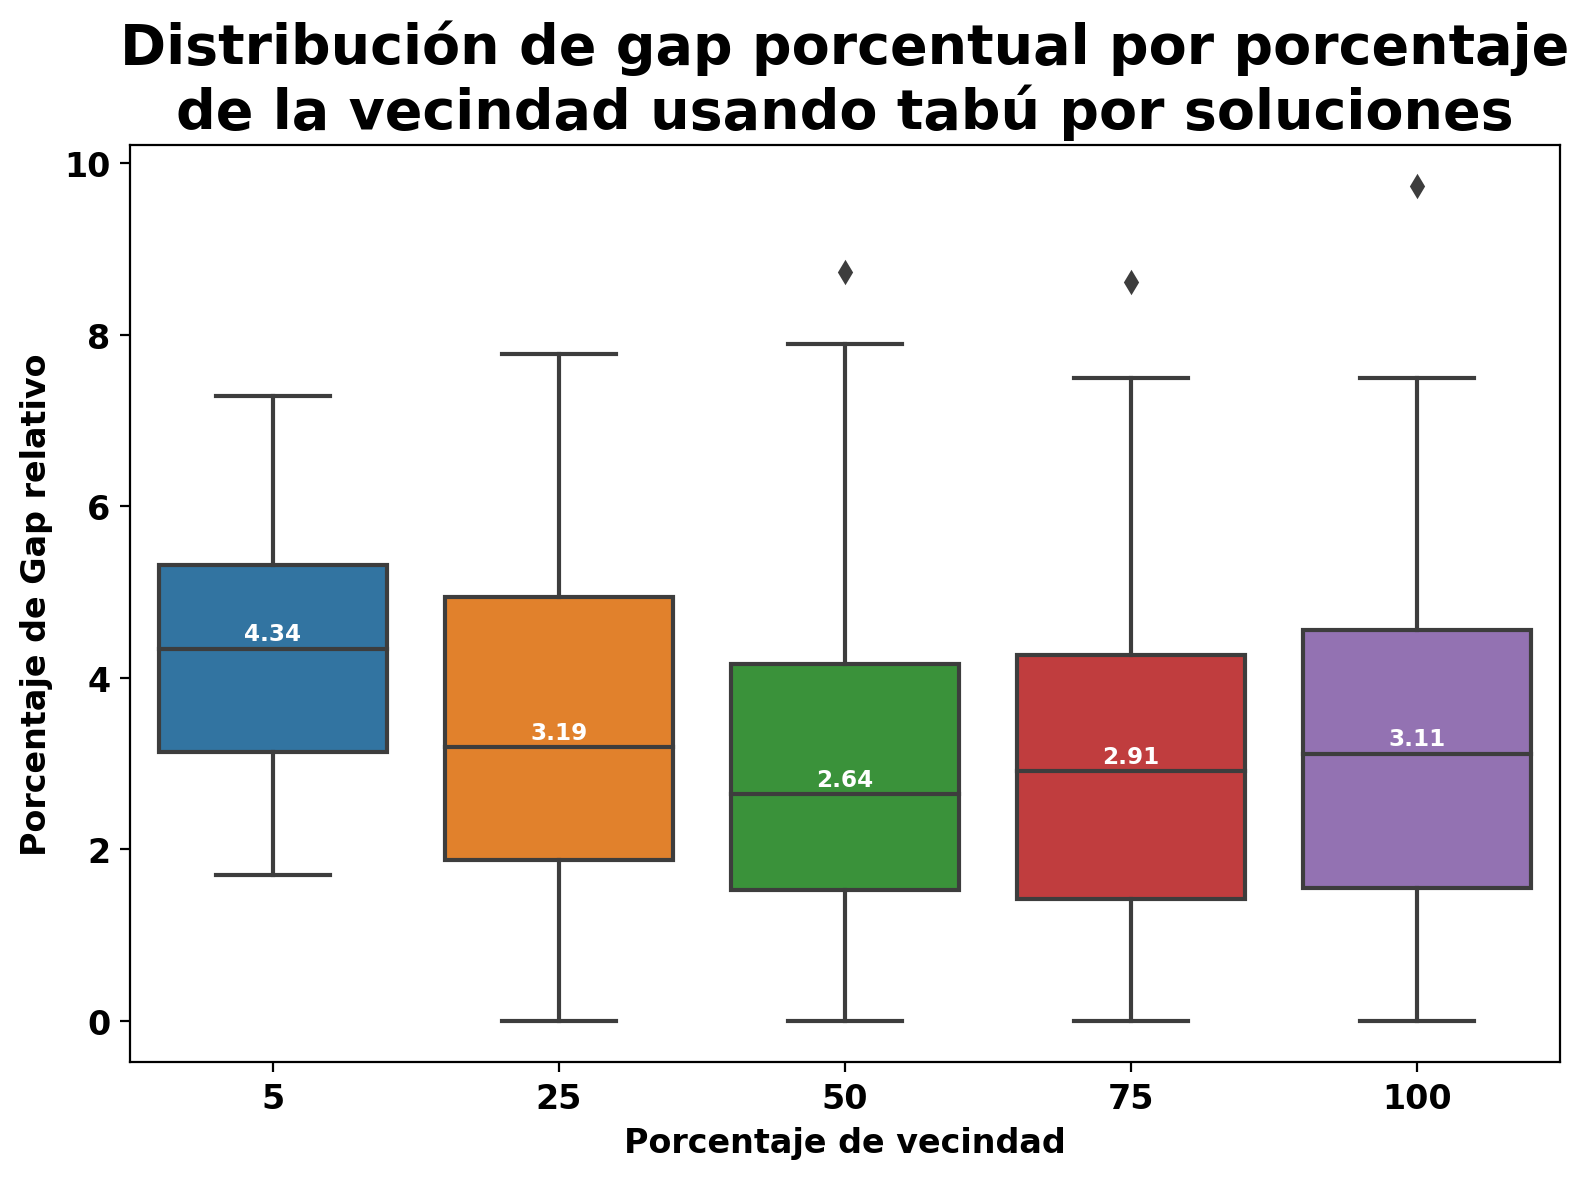

In [22]:
dfMemVecindad50 = pathToPandasTabu('DataVecindadMem50/', 'mem').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
dfMemVecindad50 = pesoToGap(dfMemVecindad50, dfOptimos, dfMemVecindad50.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfMemVecindad50.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por porcentaje\nde la vecindad usando tabú por soluciones", 'Porcentaje de vecindad', 'Porcentaje de Gap relativo', save=False, out='graficos/gapVsVec_tabuMem.png')

## Ahora miramos como cambia el tiempo

<Figure size 432x288 with 0 Axes>

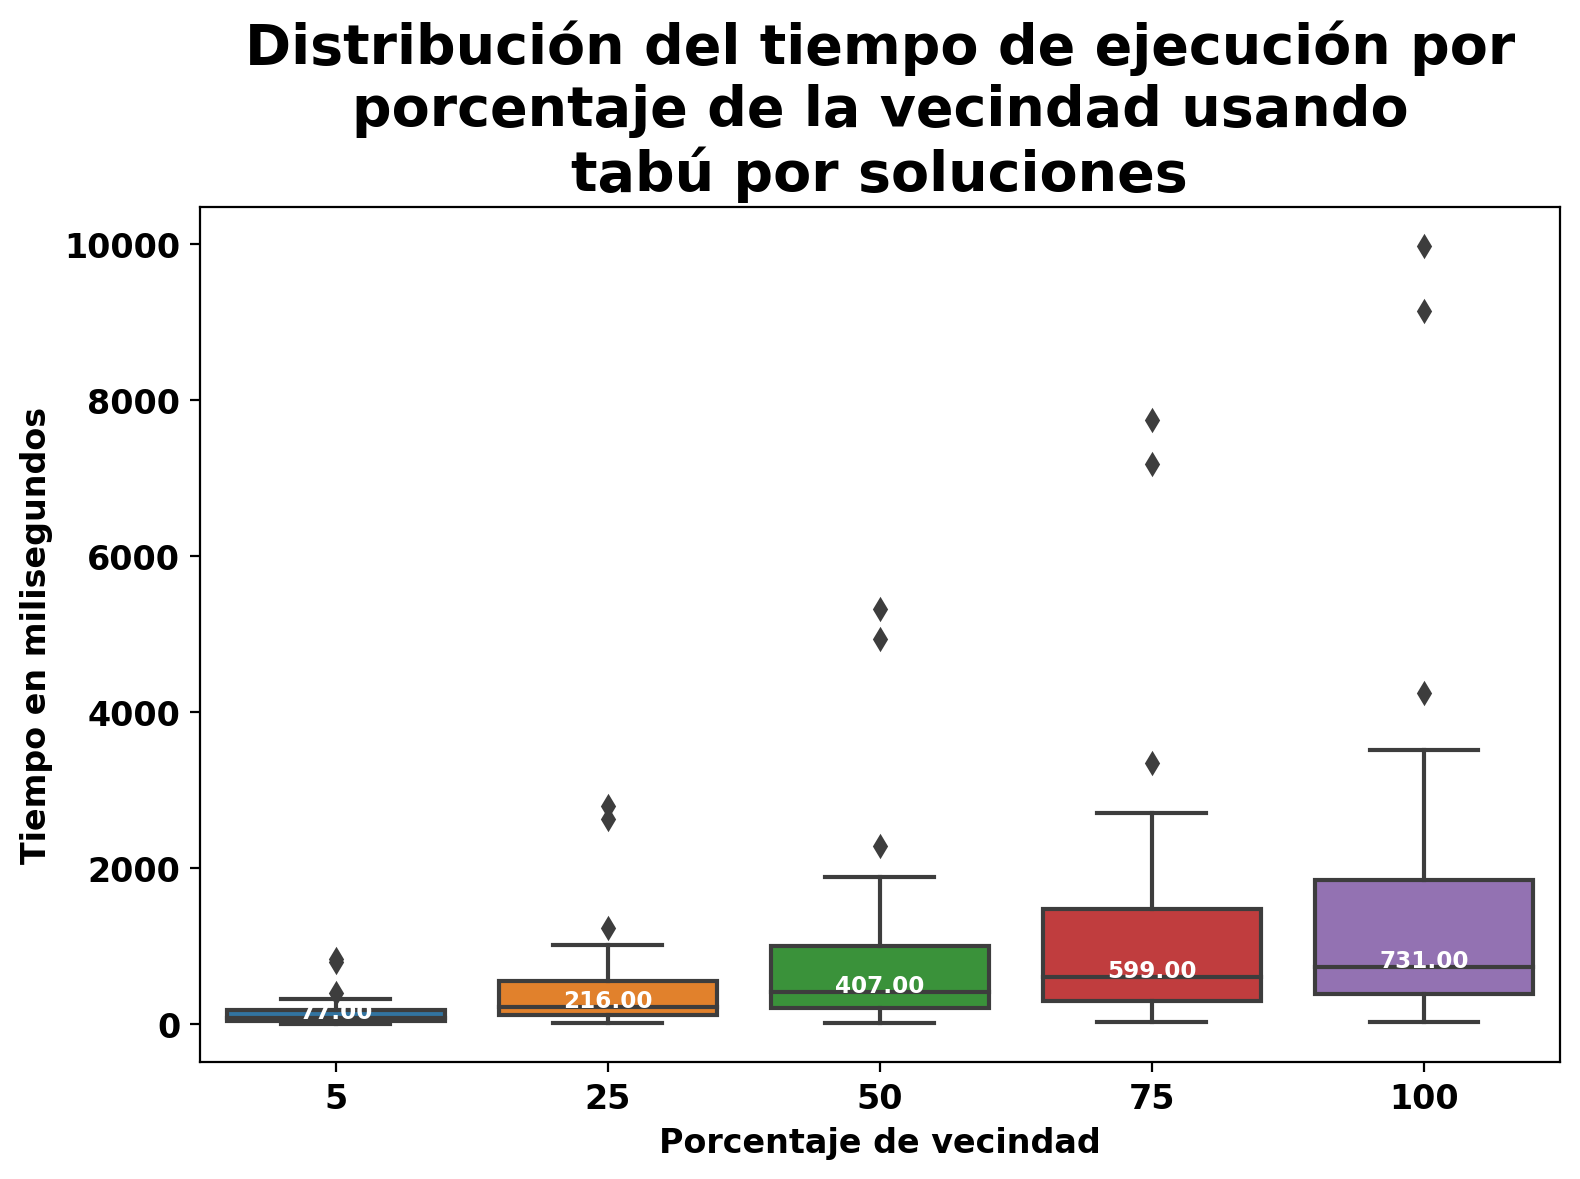

In [23]:
dfMemVecindad50Tiempo = pathToPandasTabu('DataVecindadMem50/', 'timeMem').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
memoriasToBoxplot(dfMemVecindad50Tiempo.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución por\nporcentaje de la vecindad usando\ntabú por soluciones", 'Porcentaje de vecindad', 'Tiempo en milisegundos', save=False, out='graficos/variandoVecinos/tiempoVsVec_tabuMem.png')

## Hacemos lo mismo para tabu por estructura. Aca la memoria queda fija en 500.

<Figure size 432x288 with 0 Axes>

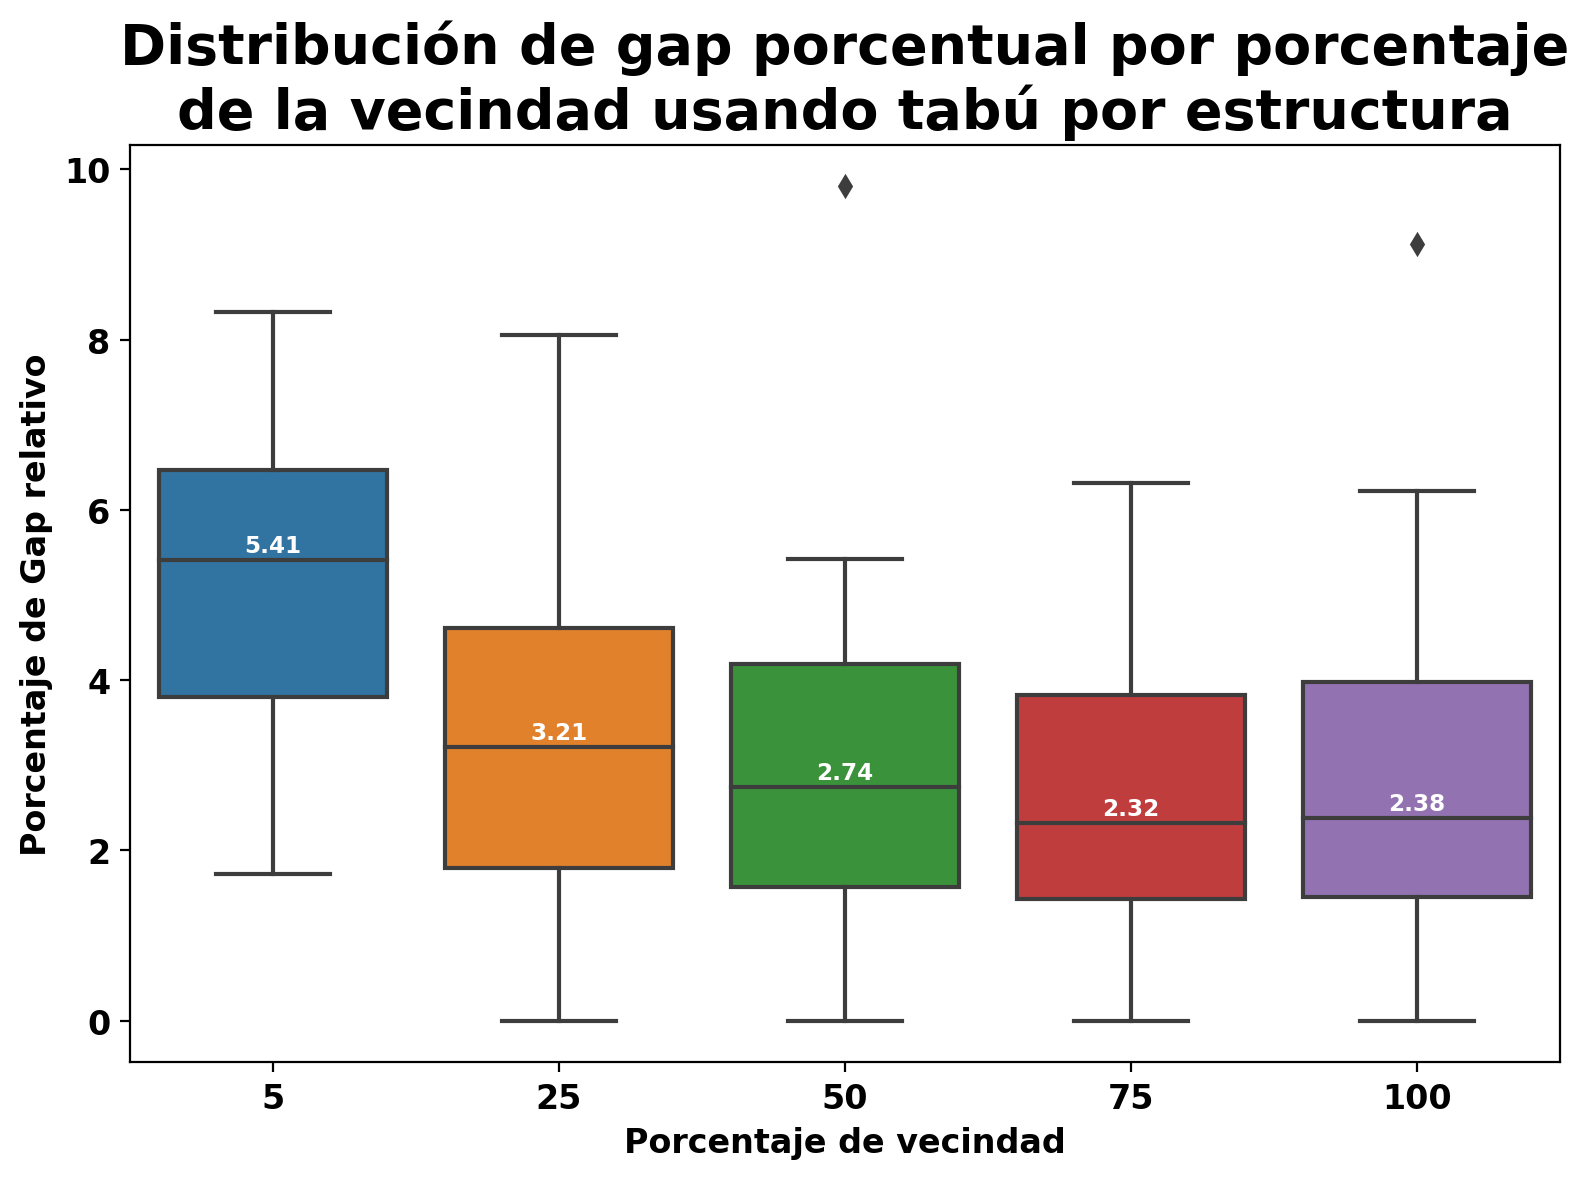

In [24]:
dfEstVecindad500 = pathToPandasTabu('DataVecindadEst500/', 'est').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
dfEstVecindad500 = pesoToGap(dfEstVecindad500, dfOptimos, dfEstVecindad500.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfEstVecindad500.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por porcentaje\nde la vecindad usando tabú por estructura", 'Porcentaje de vecindad', 'Porcentaje de Gap relativo', save=False, out='graficos/variandoVecinos/gapVsVec_tabuEst.png')

<Figure size 432x288 with 0 Axes>

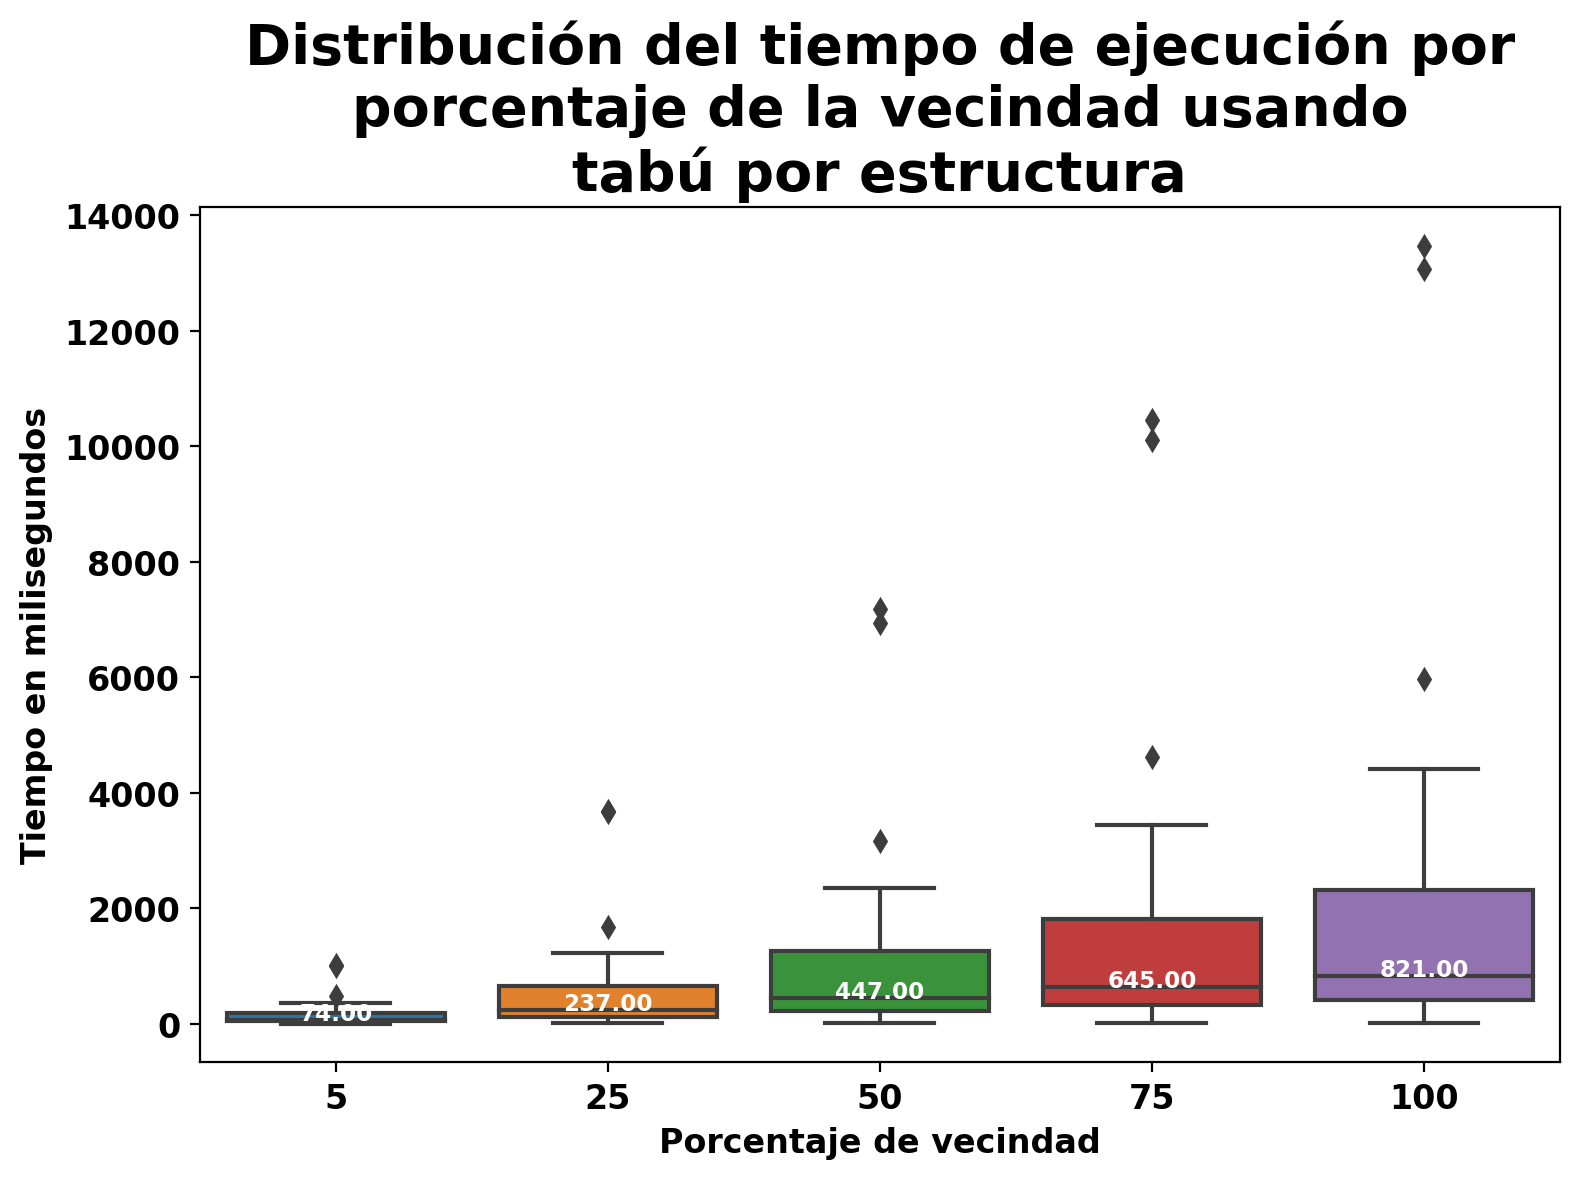

In [25]:
dfEstVecindad500Time = pathToPandasTabu('DataVecindadEst500/', 'timeEst').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
memoriasToBoxplot(dfEstVecindad500Time.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución por\nporcentaje de la vecindad usando\ntabú por estructura", 'Porcentaje de vecindad', 'Tiempo en milisegundos', save=False, out='graficos/variandoVecinos/tiempoVsVec_tabuEst.png')

## En los 2 casos que vimos estamos viendo que parece que gana 75%. El problema es que es muy caro. Asi que decidimos quedarnos con 25% y 50% en ambos casos para CV.

## Hacemos cross validation

### Empezamos con tabu por soluciones

<Figure size 432x288 with 0 Axes>

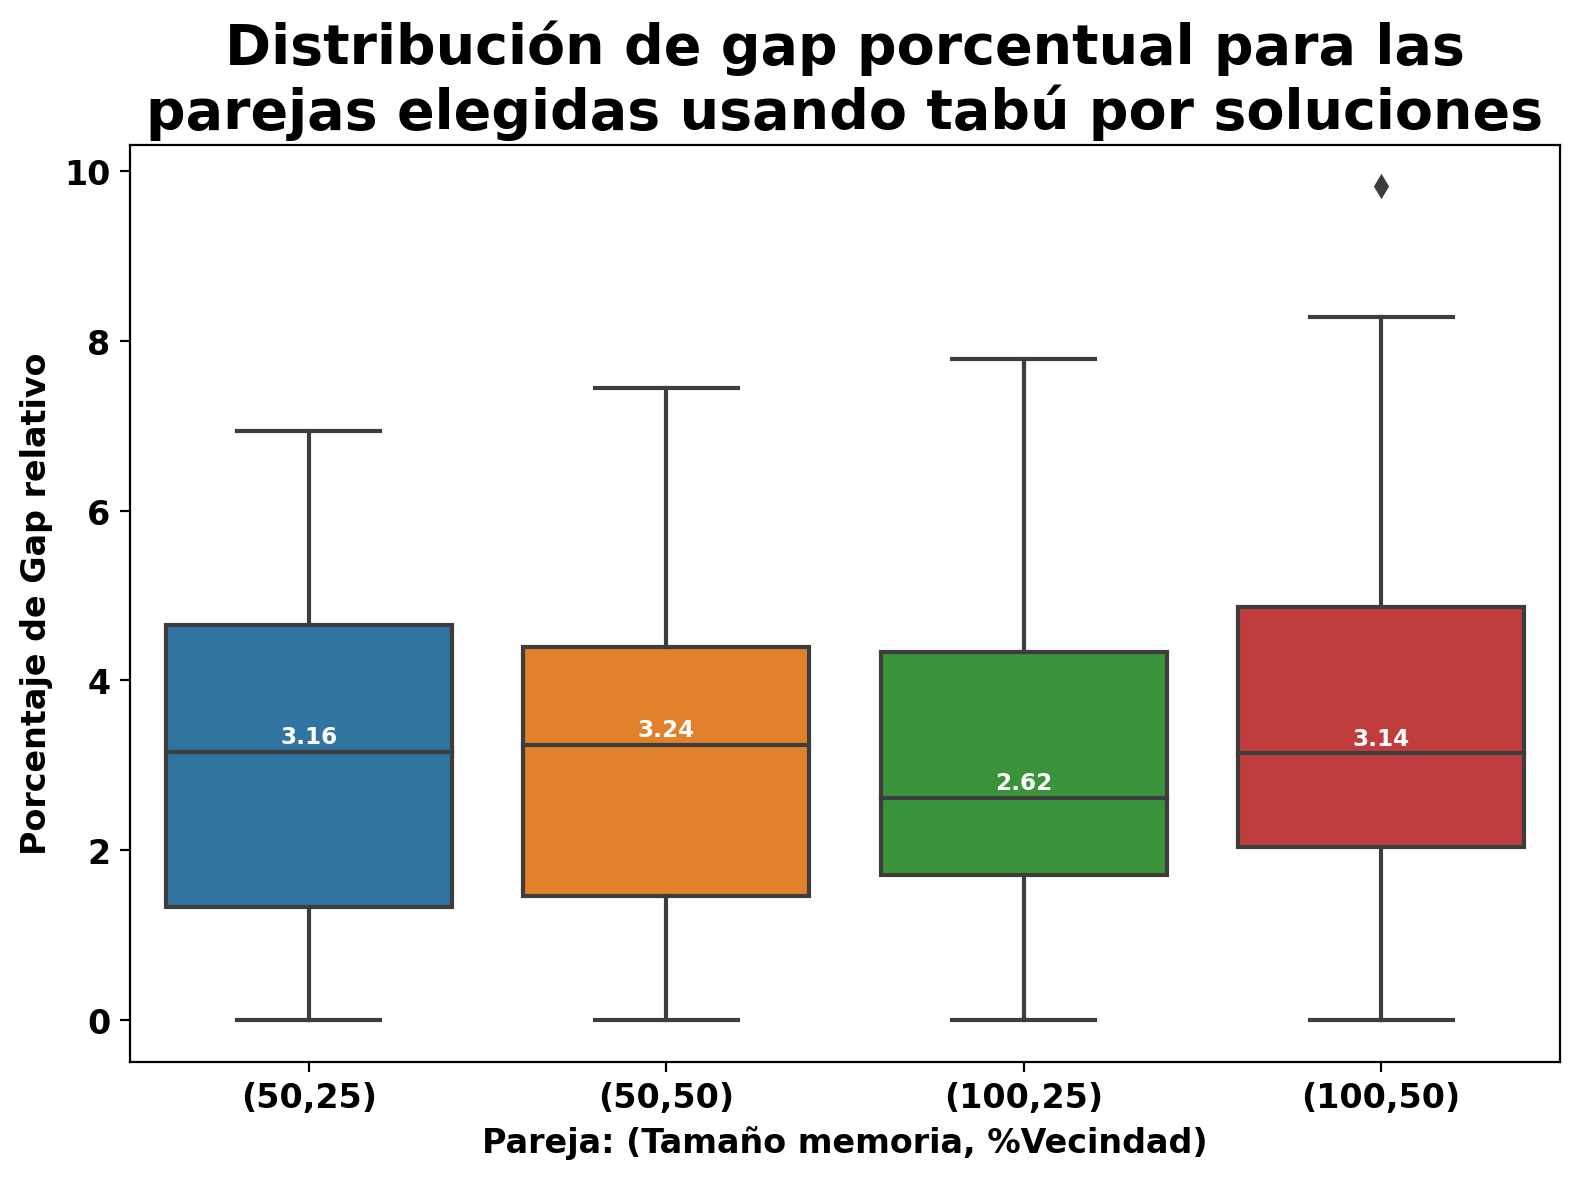

In [26]:
dfCrossMem = pathToPandasTabu('DataCross/', 'mem') \
.drop(['(100','25).1','(100.1','50).1'], axis=1)   \
.rename(columns={'(50': '(50,25)', '25)': '(50,50)','(50.1': '(100,25)','50)': '(100,50)'}) \
.astype({'(50,25)': float, '(50,50)': float,'(100,25)': float, '(100,50)': float })
dfCrossMem = pesoToGap(dfCrossMem, dfOptimos, dfCrossMem.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfCrossMem.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual para las\nparejas elegidas usando tabú por soluciones", 'Pareja: (Tamaño memoria, %Vecindad)', 'Porcentaje de Gap relativo', save=False, out='graficos/CV/gap_tabuMem.png')

<Figure size 432x288 with 0 Axes>

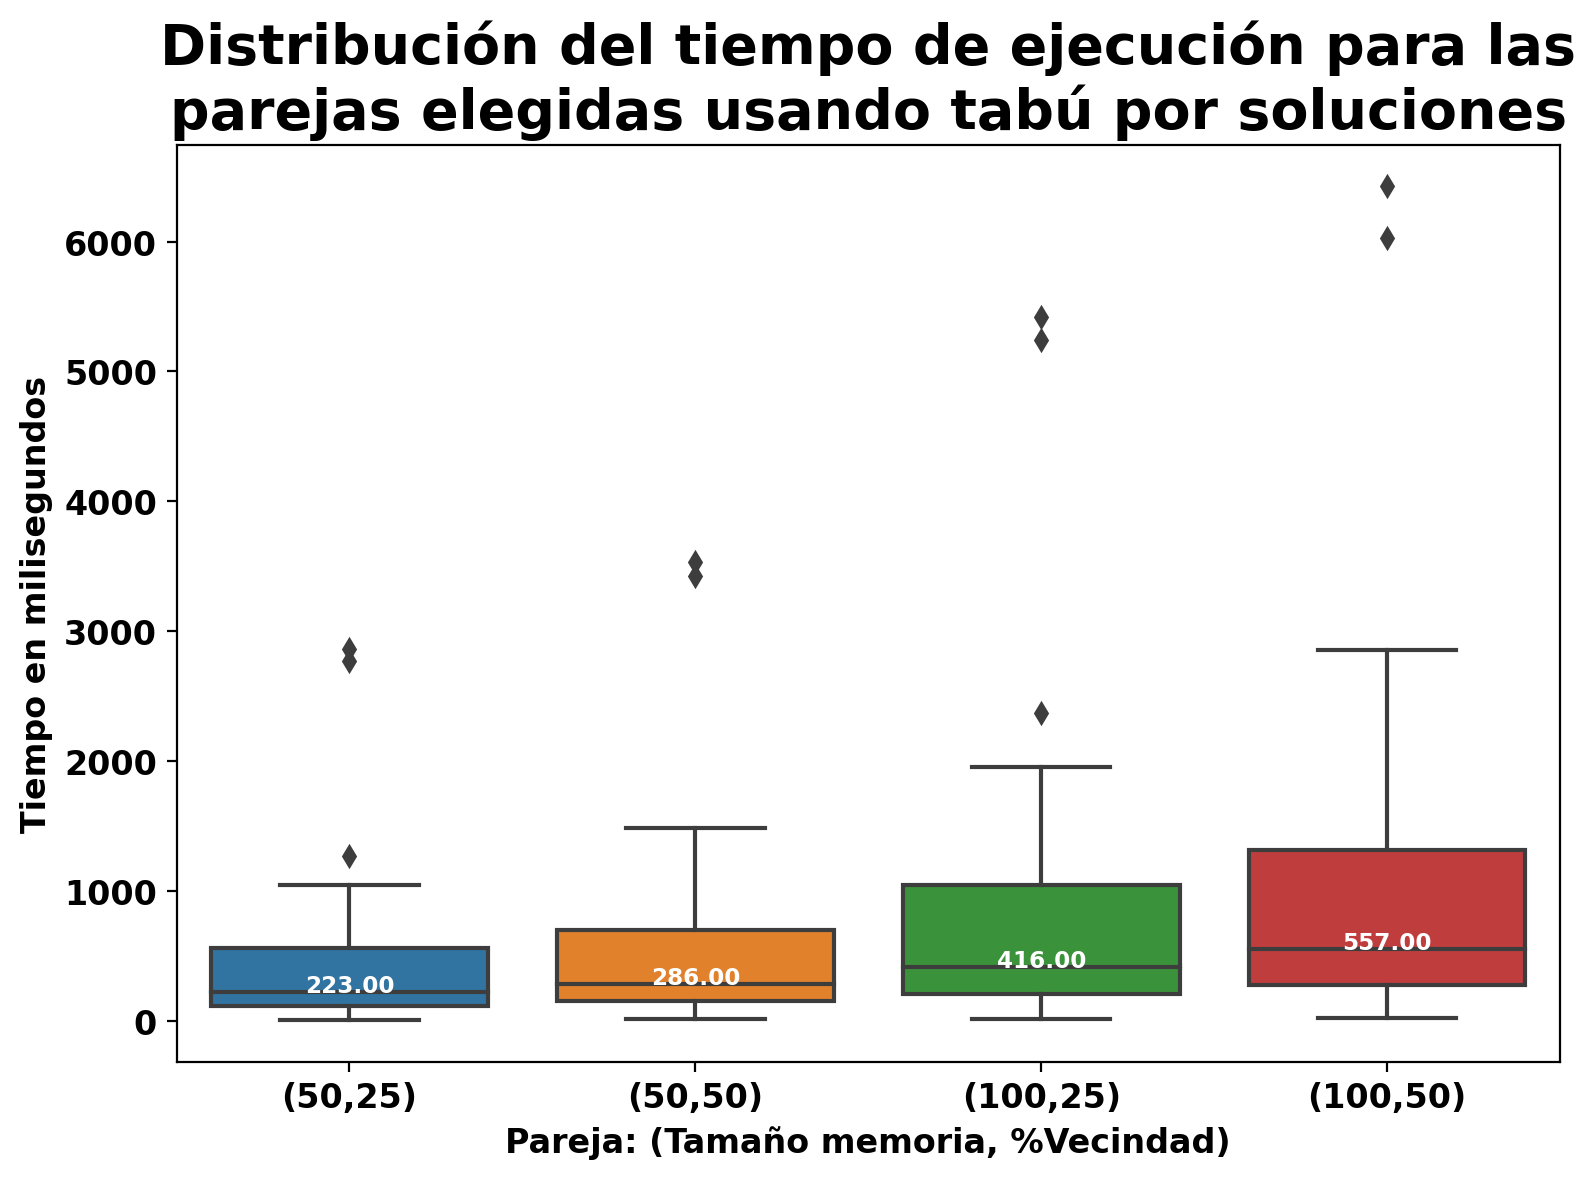

In [27]:
dfCrossMemTime = pathToPandasTabu('DataCross/', 'timeMem') \
.drop(['(100','25).1','(100.1','50).1'], axis=1)   \
.rename(columns={'(50': '(50,25)', '25)': '(50,50)','(50.1': '(100,25)','50)': '(100,50)'}) \
.astype({'(50,25)': float, '(50,50)': float,'(100,25)': float, '(100,50)': float })
memoriasToBoxplot(dfCrossMemTime.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución para las\nparejas elegidas usando tabú por soluciones", 'Pareja: (Tamaño memoria, %Vecindad)', 'Tiempo en milisegundos', save=False, out='graficos/CV/tiempo_tabuMem.png')

### Para terminar hacemos tabu por estructura

<Figure size 432x288 with 0 Axes>

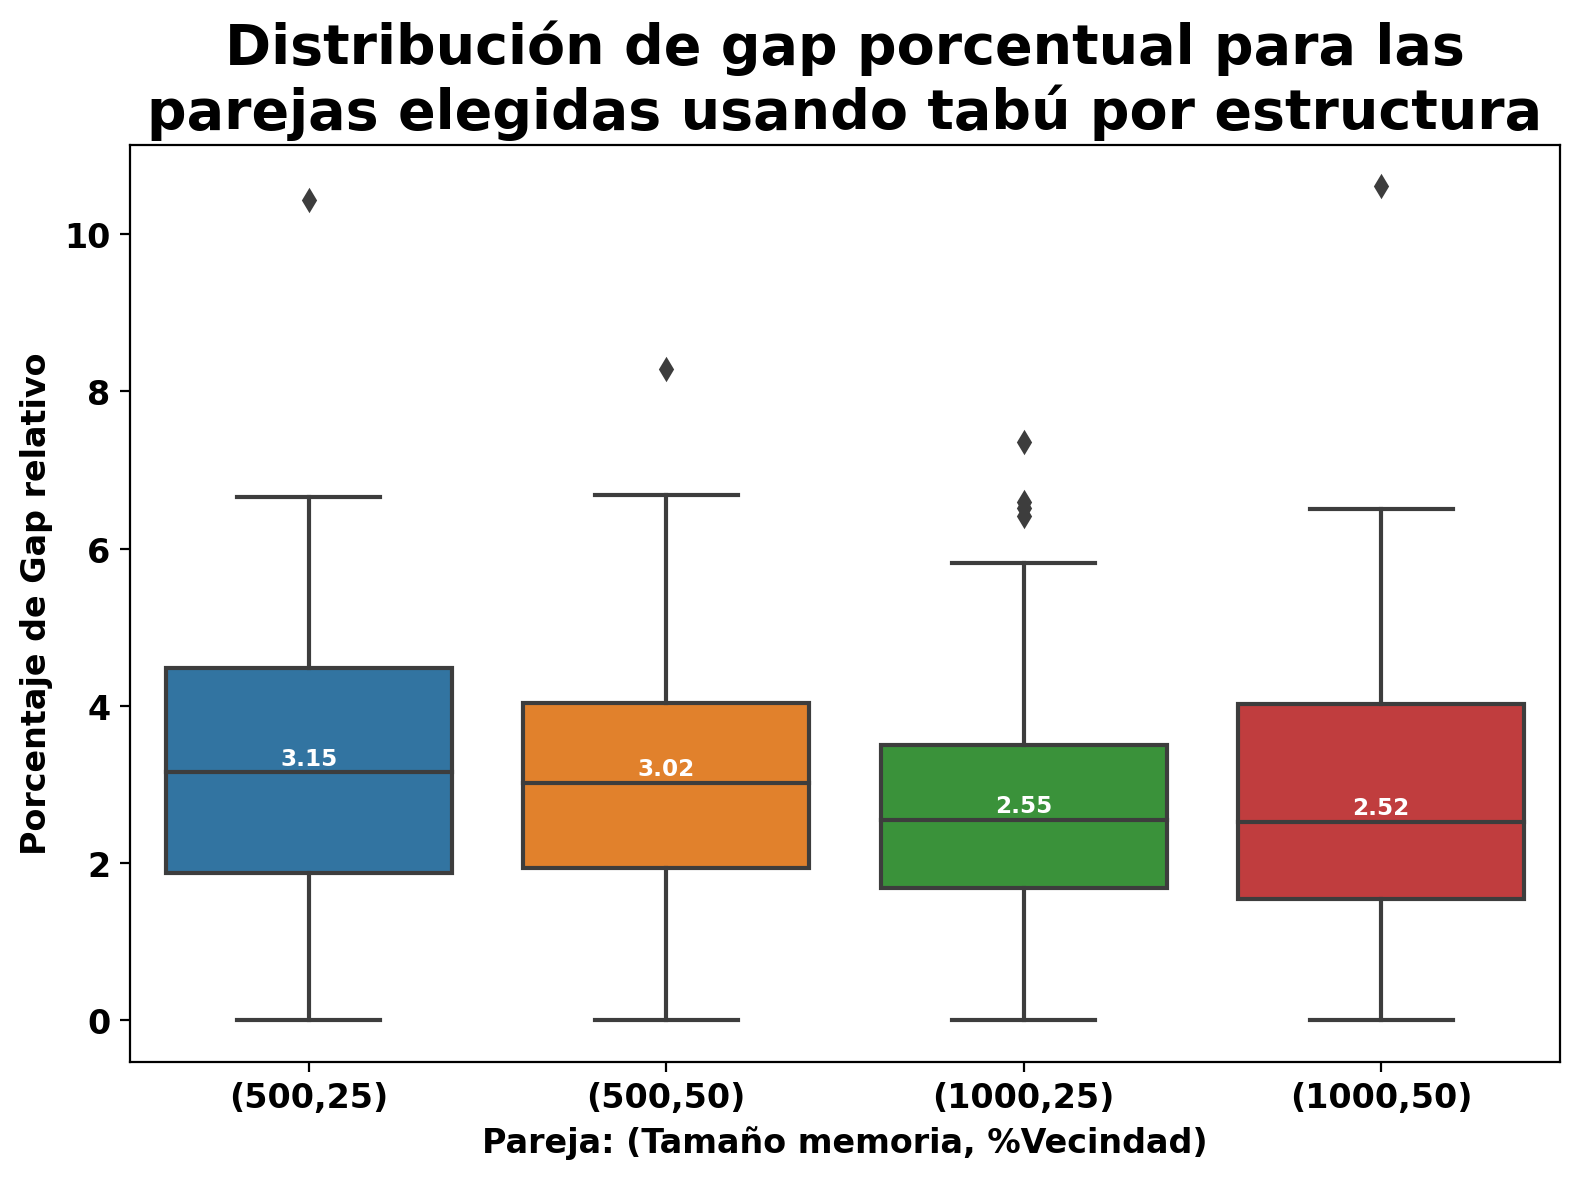

In [28]:
dfCrossEst = pathToPandasTabu('DataCross/', 'est') \
.drop(['(1000','25).1','(1000.1','50).1'], axis=1)   \
.rename(columns={'(500': '(500,25)', '25)': '(500,50)','(500.1': '(1000,25)','50)': '(1000,50)'}) \
.astype({'(500,25)': float, '(500,50)': float,'(1000,25)': float, '(1000,50)': float })
dfCrossEst = pesoToGap(dfCrossEst, dfOptimos, dfCrossEst.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfCrossEst.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual para las\nparejas elegidas usando tabú por estructura", 'Pareja: (Tamaño memoria, %Vecindad)', 'Porcentaje de Gap relativo', save=False, out='graficos/CV/gap_tabuEst.png')

<Figure size 432x288 with 0 Axes>

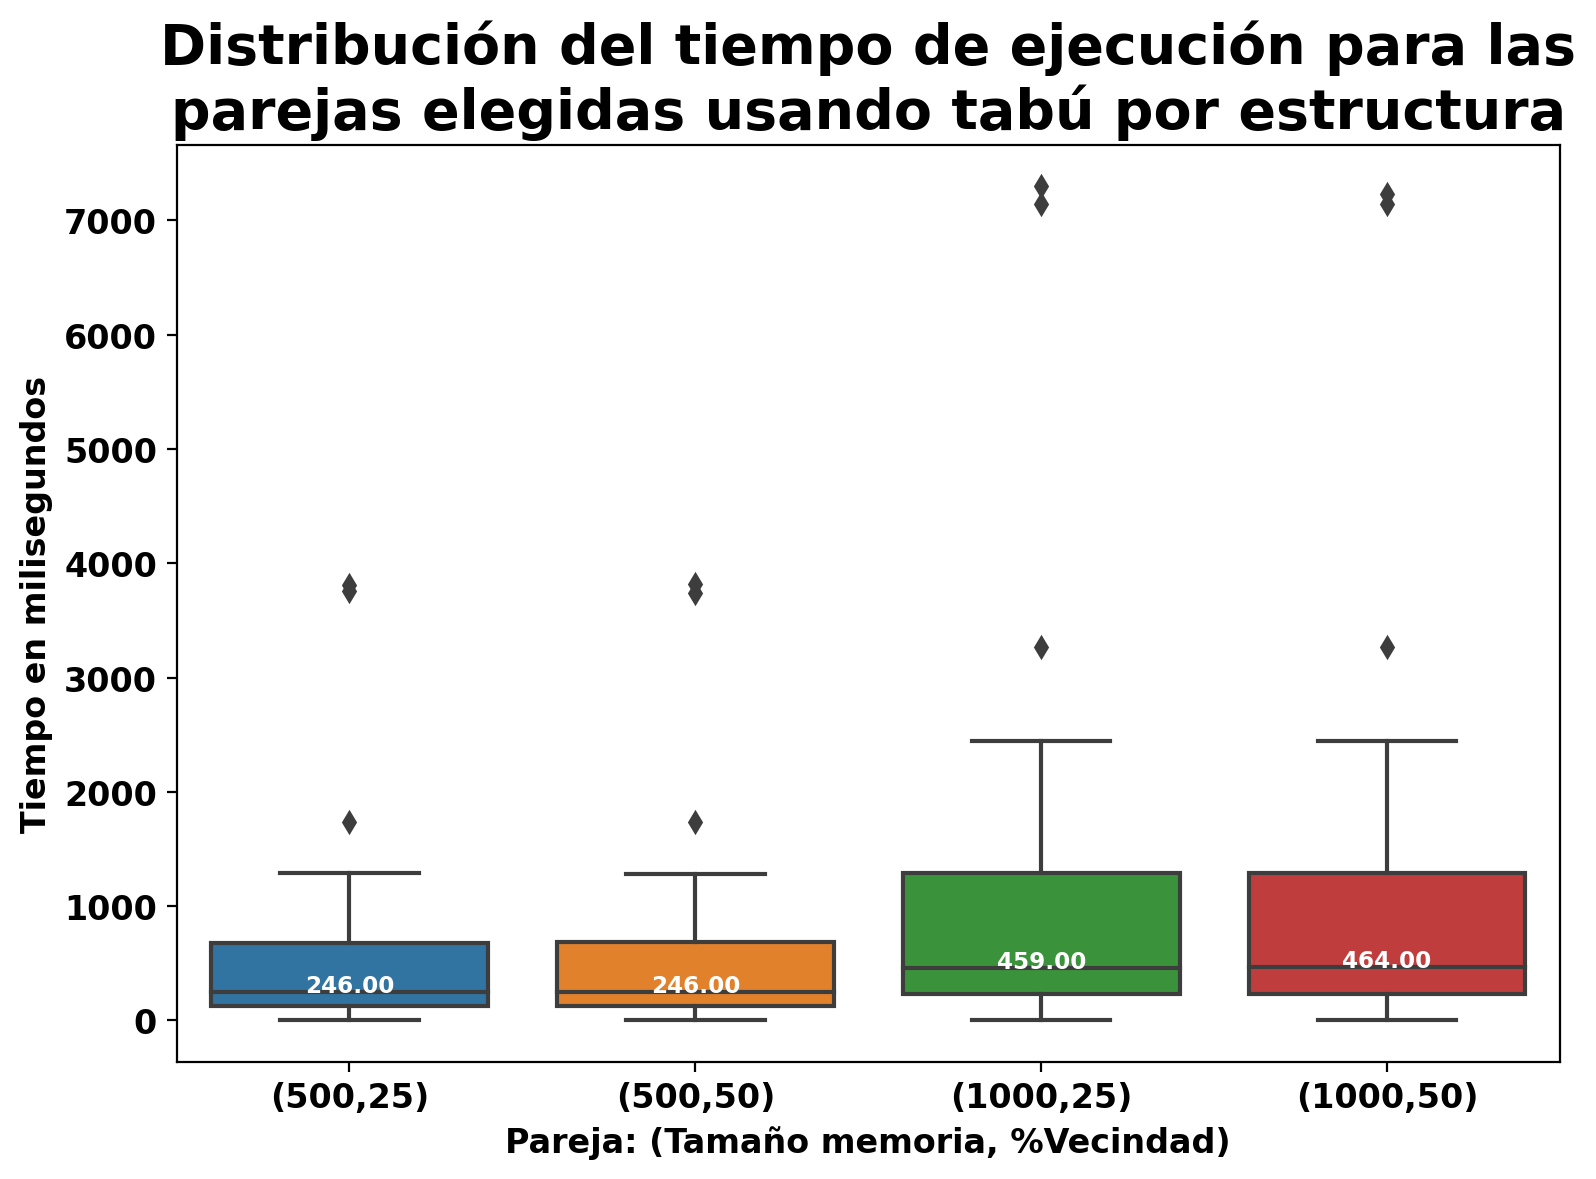

In [29]:
dfCrossEstTime = pathToPandasTabu('DataCross/', 'timeEst') \
.drop(['(1000','25).1','(1000.1','50).1'], axis=1)   \
.rename(columns={'(500': '(500,25)', '25)': '(500,50)','(500.1': '(1000,25)','50)': '(1000,50)'}) \
.astype({'(500,25)': float, '(500,50)': float,'(1000,25)': float, '(1000,50)': float })
memoriasToBoxplot(dfCrossEstTime.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución para las\nparejas elegidas usando tabú por estructura", 'Pareja: (Tamaño memoria, %Vecindad)', 'Tiempo en milisegundos', save=False, out='graficos/CV/tiempo_tabuEst.png')

## Validacion

In [30]:
def testing_results(df,title,Xlabel,Ylabel, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
    #Graficamos los pesos
    sns.barplot(data=df, x='Archivo', y='Peso',palette=sns.color_palette("hls", 8))
    
    #Graficamos el promedio
    plt.hlines(df['Peso'].mean(), xmin=-1, xmax=len(df), label='Promedio Gap')
    
    #Seteamos titulo y labels
    plt.title(title, fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel(Xlabel, fontsize =LABELSIZE)
    plt.ylabel(Ylabel, fontsize =LABELSIZE)
   
    plt.xticks(rotation=90)  
    plt.legend()

    plt.tight_layout()
    if save and out != '':
        plt.savefig(out)
    
    plt.show()

### Levantamos los datos

In [31]:
dfValEst = pathToPandasTabu('DataValidacionOut/', 'est') \
.astype({'Peso': float})
dfValEst.sort_values(['CantNodos'], inplace=True)
dfValEst = pesoToGap(dfValEst, dfOptimos, dfValEst.drop(['CantNodos', 'Archivo','TamanioMemoria','PorcentajeVecindad'], axis=1).columns.tolist())

dfValMem = pathToPandasTabu('DataValidacionOut/', 'mem') \
.astype({'Peso': float})
dfValMem.sort_values(['CantNodos'], inplace=True)
dfValMem = pesoToGap(dfValMem, dfOptimos, dfValMem.drop(['CantNodos', 'Archivo','TamanioMemoria','PorcentajeVecindad'], axis=1).columns.tolist())

### Graficamos memoria por soluciones 

<Figure size 432x288 with 0 Axes>

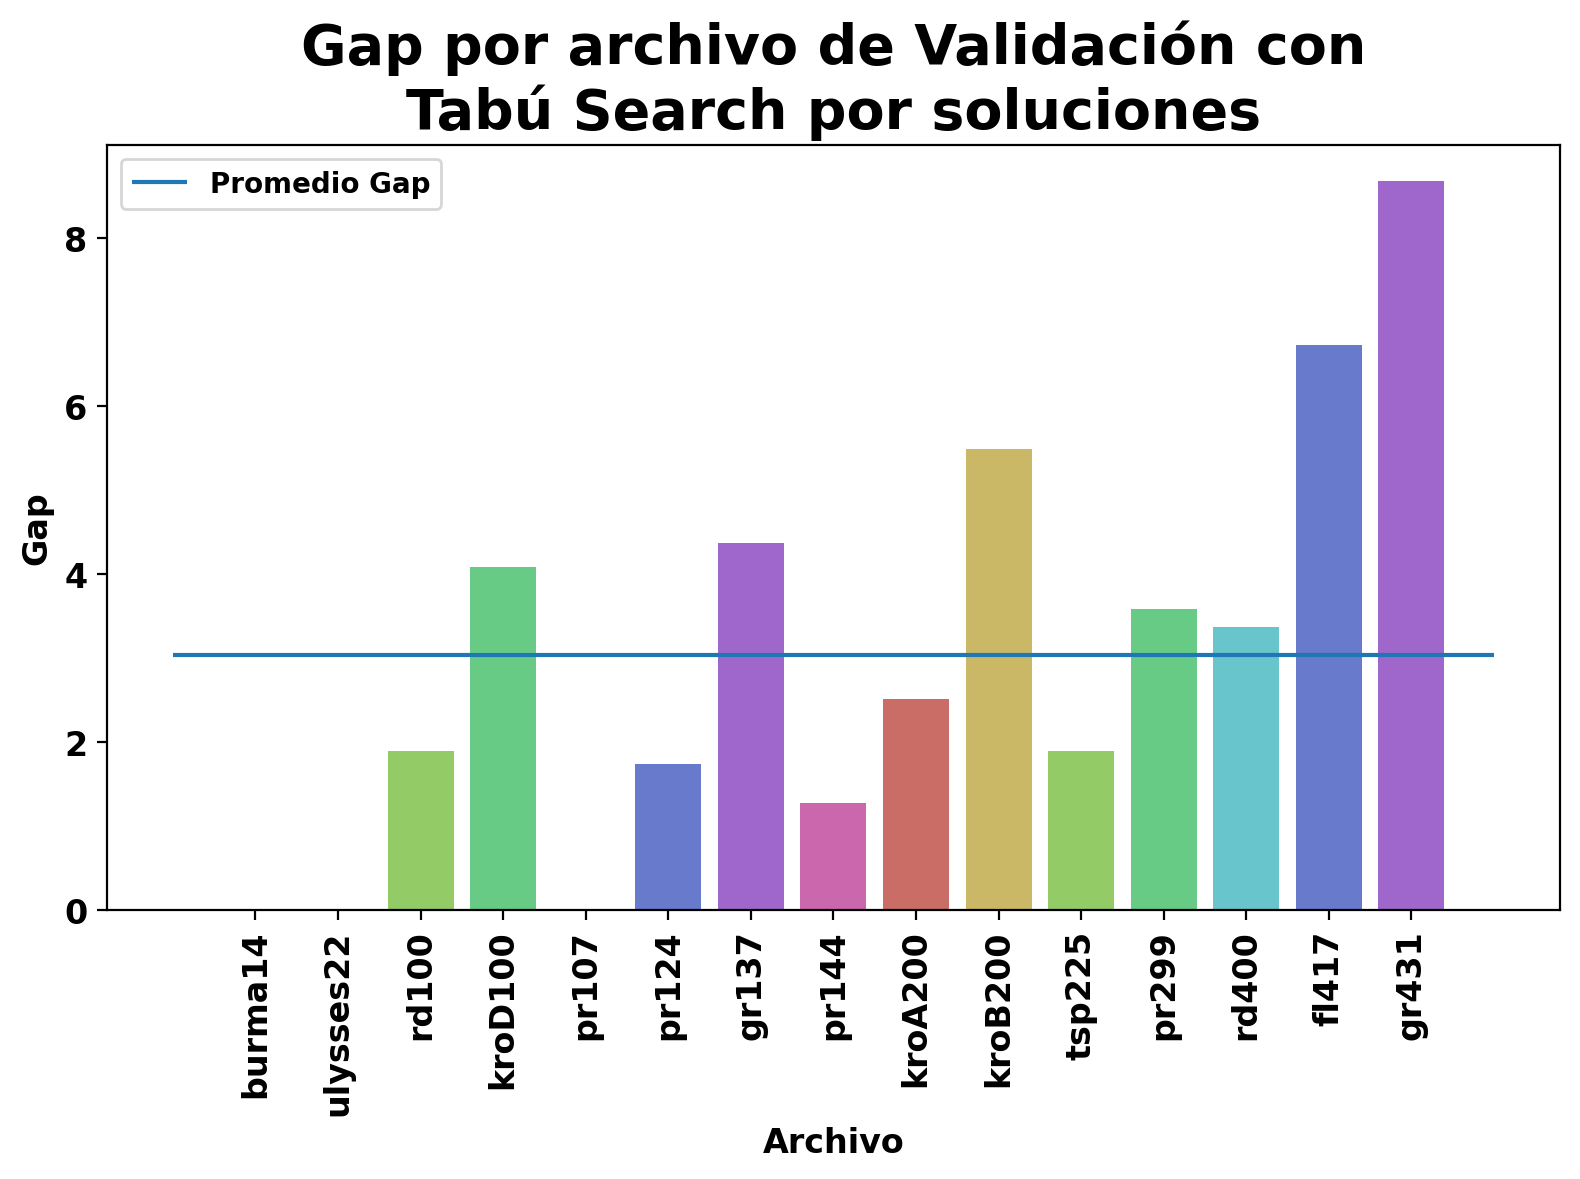

In [32]:
testing_results(dfValMem, 'Gap por archivo de Validación con\nTabú Search por soluciones','Archivo', 'Gap', save=False, out='graficos/resultadosValidacionMem.png')

### Graficamos memoria por estructura

<Figure size 432x288 with 0 Axes>

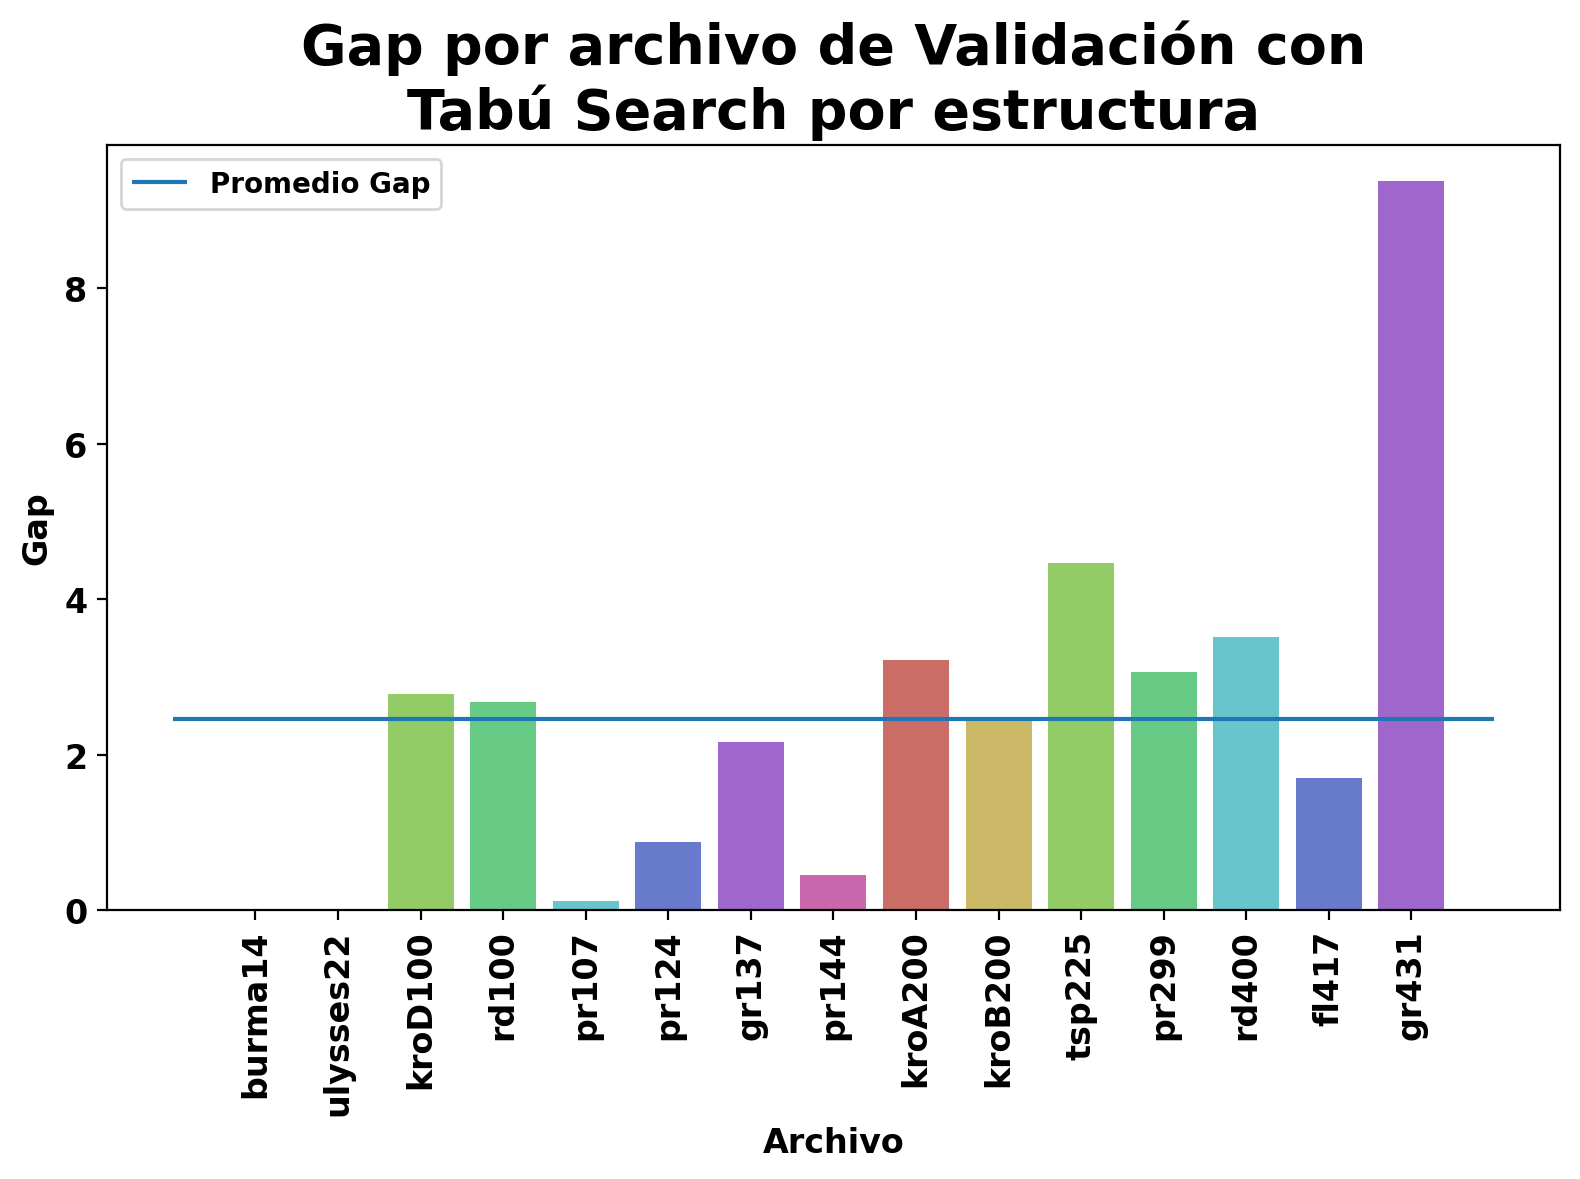

In [33]:
testing_results(dfValEst, 'Gap por archivo de Validación con\nTabú Search por estructura','Archivo', 'Gap', save=False, out='graficos/resultadosValidacionEst.png')

## Testing

### Levantamos los datos

In [34]:
dfTestEst = pathToPandasTabu('DataTestingOut/', 'est') \
.astype({'Peso': float})
dfTestEst.sort_values(['CantNodos'], inplace=True)
dfTestEst = pesoToGap(dfTestEst, dfOptimos, dfTestEst.drop(['CantNodos', 'Archivo','TamanioMemoria','PorcentajeVecindad'], axis=1).columns.tolist())

dfTestMem = pathToPandasTabu('DataTestingOut/', 'mem') \
.astype({'Peso': float})
dfTestMem.sort_values(['CantNodos'], inplace=True)
dfTestMem = pesoToGap(dfTestMem, dfOptimos, dfTestMem.drop(['CantNodos', 'Archivo','TamanioMemoria','PorcentajeVecindad'], axis=1).columns.tolist())

dfTestEst=dfTestEst[(dfTestEst['Archivo']!= "fl1577") & (dfTestEst['Archivo']!= "d2103")]
dfTestMem=dfTestMem[(dfTestMem['Archivo']!= "fl1577") & (dfTestMem['Archivo']!= "d2103")]

### Graficamos memoria por soluciones 

<Figure size 432x288 with 0 Axes>

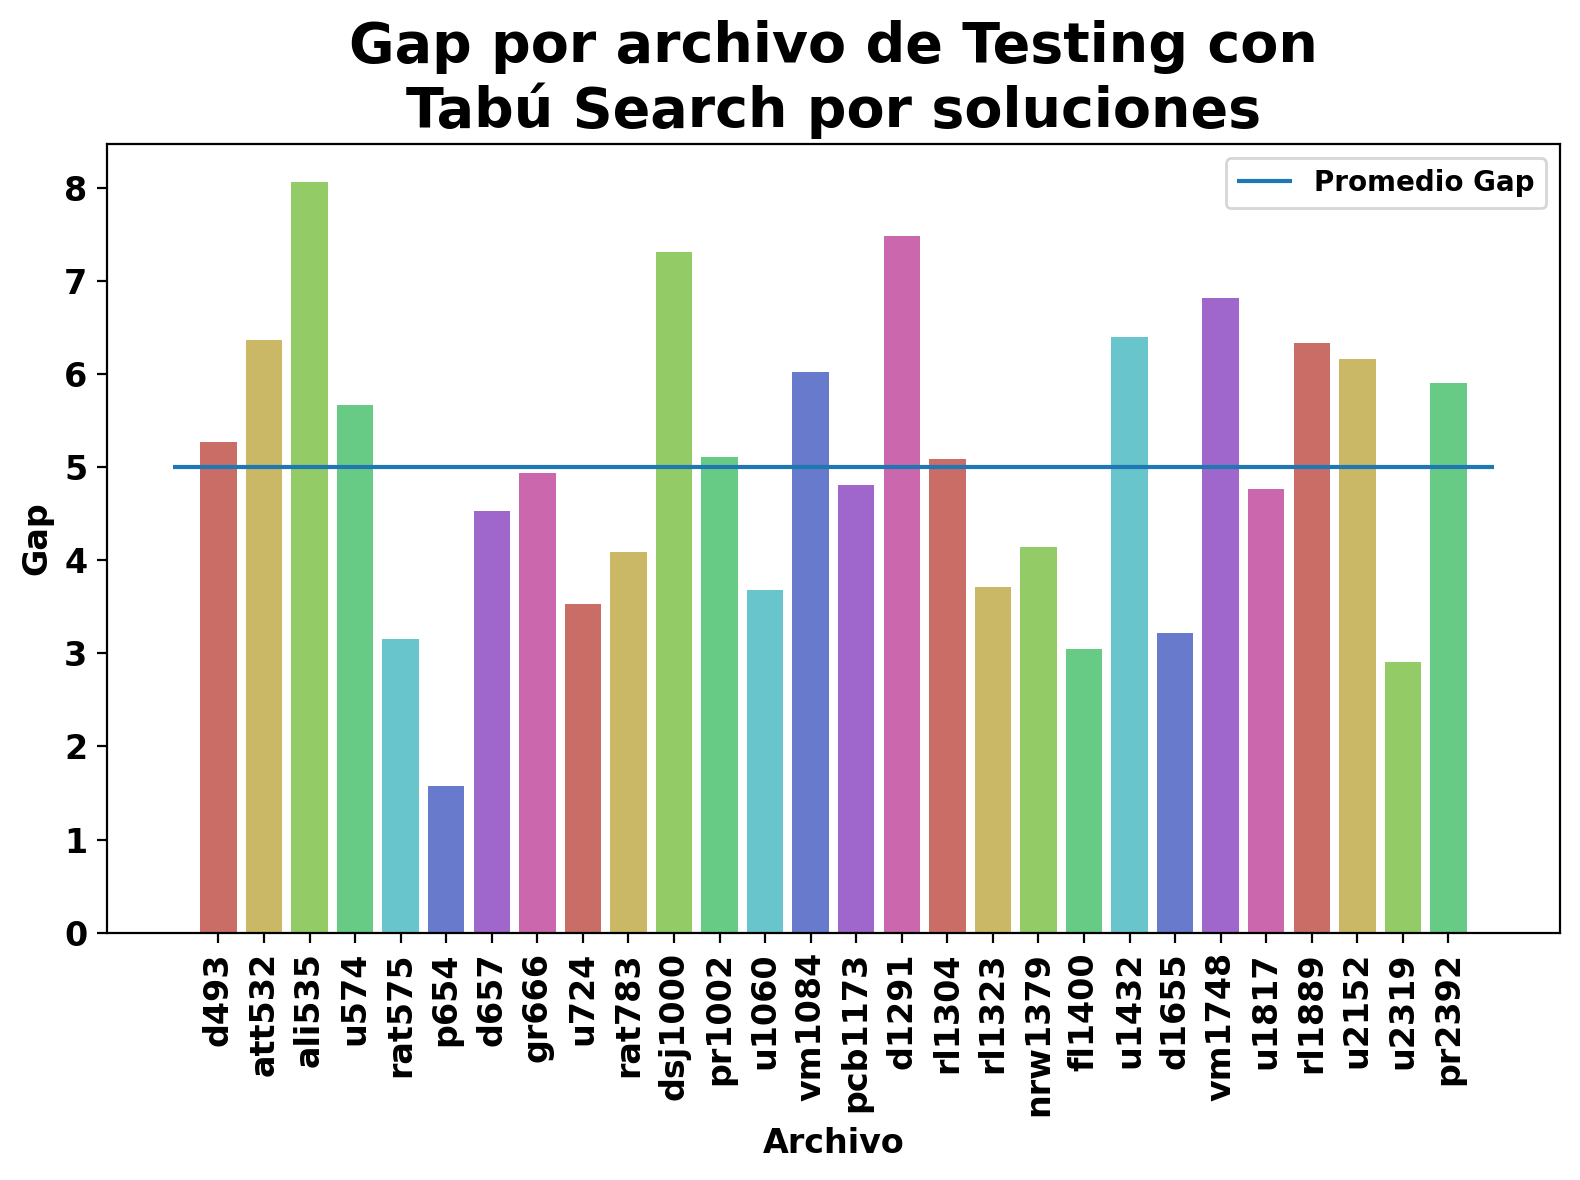

In [35]:
testing_results(dfTestMem, 'Gap por archivo de Testing con\nTabú Search por soluciones','Archivo', 'Gap', save=False, out='graficos/resultadosTestMem.png')

### Graficamos memoria por estructura

<Figure size 432x288 with 0 Axes>

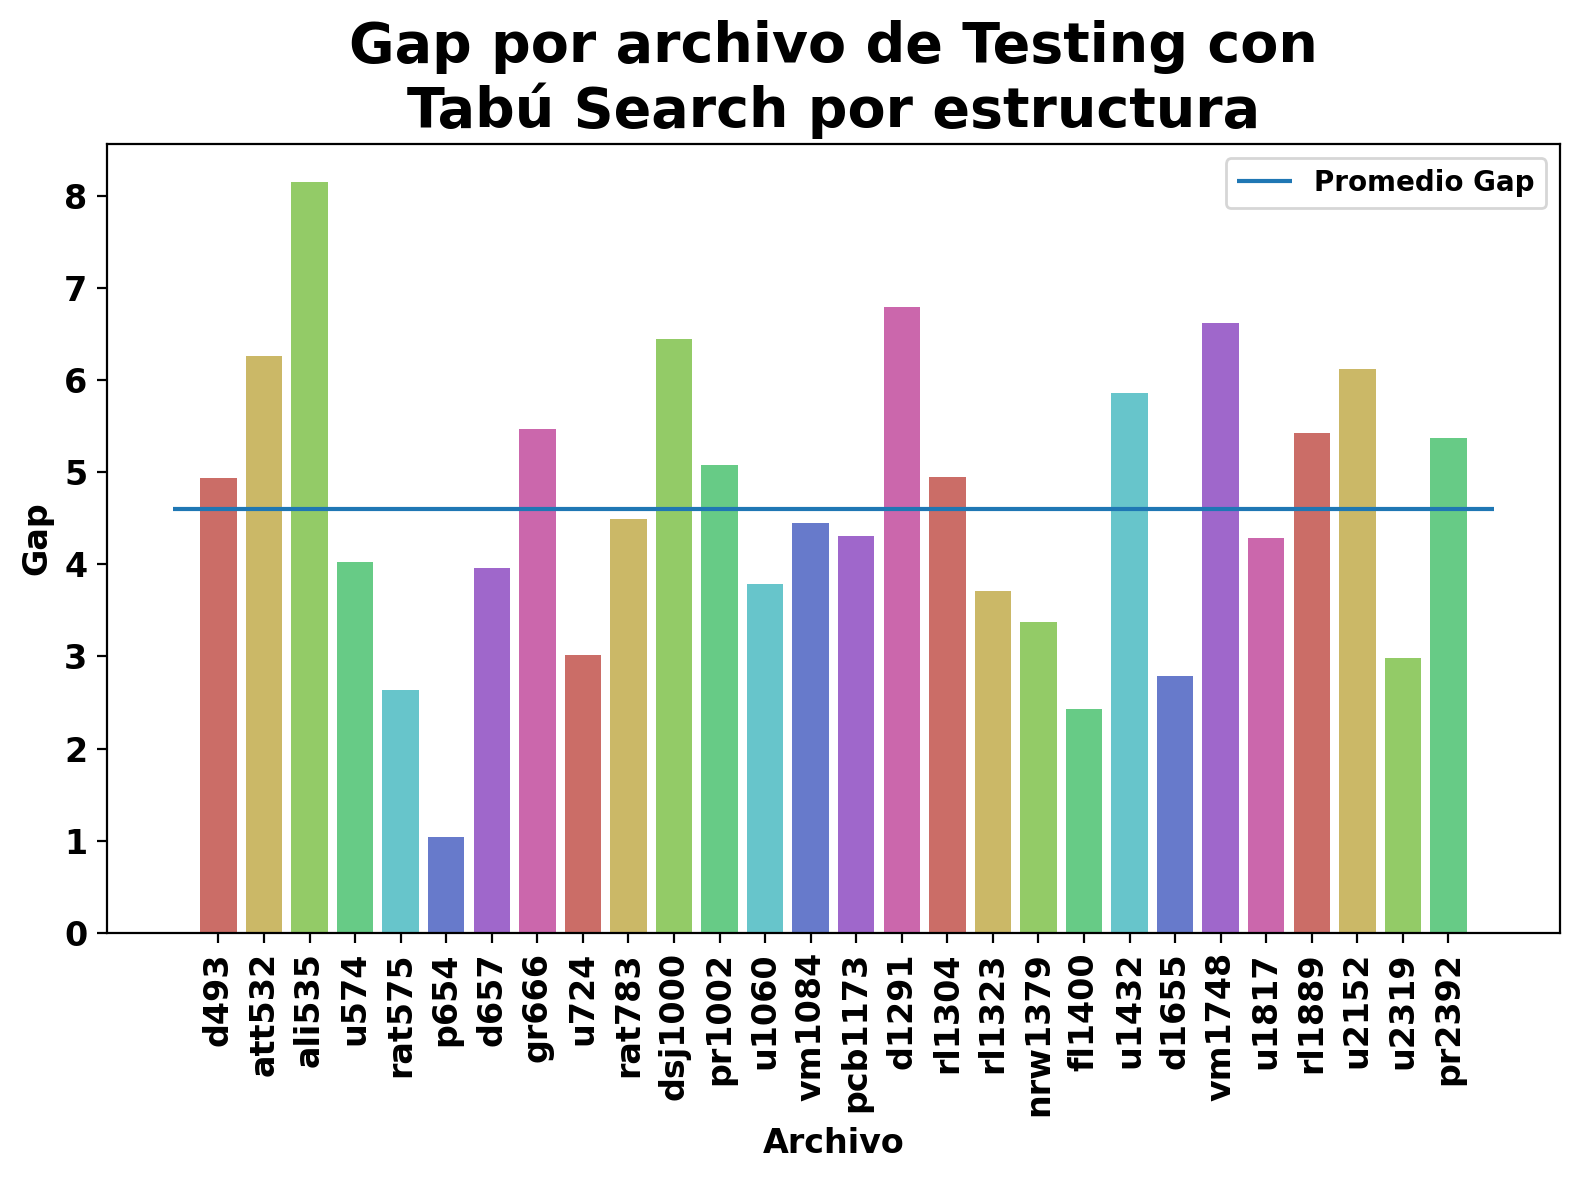

In [36]:
testing_results(dfTestEst, 'Gap por archivo de Testing con\nTabú Search por estructura','Archivo', 'Gap', save=False, out='graficos/resultadosTestEst.png')

## Comparacion final

In [37]:
def gapsRelativosPorMetodo(dfMediciones, dfOptimos, metodo):
    dfCostos = dfMediciones[dfMediciones['Tipo'] == 'Costo'][['Archivo', metodo]].set_index('Archivo')
    
    
    gaps = []
    
    for archivo, rows in dfCostos.iterrows():
        mediocre = float(rows[metodo])
        optimo = float(dfOptimos.loc[archivo]['CotaInferior'])
        gaps.append(gapRelativo(optimo, mediocre))
        
    return gaps

def gapsRelativosToBoxplot(dfGaps, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
    #Seteamos titulo y labels
    plt.title('Distribución gap relativo por heurística', fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel('Método utilizado', fontsize =LABELSIZE)
    plt.ylabel('Porcentaje gap relativo', fontsize =LABELSIZE)
    
    #Graficamos los BP
    bp = sns.boxplot(data=dfGaps, ax=ax)
    
    #Calculamos las medianas
    medians = dfGaps.median().tolist()
    
    for xtick in bp.get_xticks():
        bp.text(xtick,medians[xtick] + 0.2, '{:.2f}'.format(medians[xtick]), 
            horizontalalignment='center',size='small',color='w',weight='bold')

    if save and out != '':
        plt.savefig(out)
        
    plt.show()

In [38]:
def appendPathToPandasRes(path, originalDF):
    name = getNameFromPath(path)
    df = pd.read_csv(path).transpose().reset_index()
    df.columns = METODOS
    df.drop(np.arange(3, len(df)),axis=0, inplace=True)
    df.insert(loc=0, column='Archivo', value=[name]*3)
    df.insert(loc=1, column='Tipo', value=["CantNodos", "Costo", "Tiempo"])
    originalDF = originalDF.append(df, ignore_index= True)
    return originalDF

def pathToPandas(path, extension):
    originalDF = pd.DataFrame(columns=['Archivo', 'Tipo']+METODOS)
    
    files = [os.path.join(path,file) for file in os.listdir(path)]
    for file in files:
        
        if os.path.isdir(file):
            originalDF = originalDF.append(pathToPandas(file, extension), ignore_index=True)
            continue
            
        #Si es un archivo y no es un .res no me interesa y paso a la que viene
        if not getExtensionFromPath(file) == extension:
            continue
        
        if os.path.isfile(file):
            originalDF = appendPathToPandasRes(file, originalDF)
            continue
        
        
        print("\n\nQue cosa me pasaste bro????\n\n")
        return
    
    return originalDF

def medicionesToXYdf(dfMediciones, x, y, dfGaps=None):
    dfOut = pd.DataFrame(columns=['Archivo','Algoritmo', x, y])
    dfOut['Archivo'] = dfMediciones['Archivo'].unique().tolist()*5
    dfOut.sort_values(by='Archivo', inplace=True, ignore_index=True)
    for index, rows in dfOut.iterrows():
        archivoActual = rows['Archivo']
        algoritmoActual = METODOS[index%3]
        rows['Algoritmo'] = algoritmoActual
        
        
        if x == 'Gap':
            rows[x] = dfGaps.loc[archivoActual][algoritmoActual]
        else:
            rows[x] = int(dfMediciones[(dfMediciones['Archivo'] == archivoActual) & (dfMediciones['Tipo']==x)][algoritmoActual].tolist()[0])
            
        if y == 'Gap':
            rows[y] = dfGaps.loc[archivoActual][algoritmoActual]
        else:
            rows[y] = int(dfMediciones[(dfMediciones['Archivo'] == archivoActual) & (dfMediciones['Tipo']==y)][algoritmoActual].tolist()[0])
    
    return dfOut

### Boxplots comparativos

<Figure size 432x288 with 0 Axes>

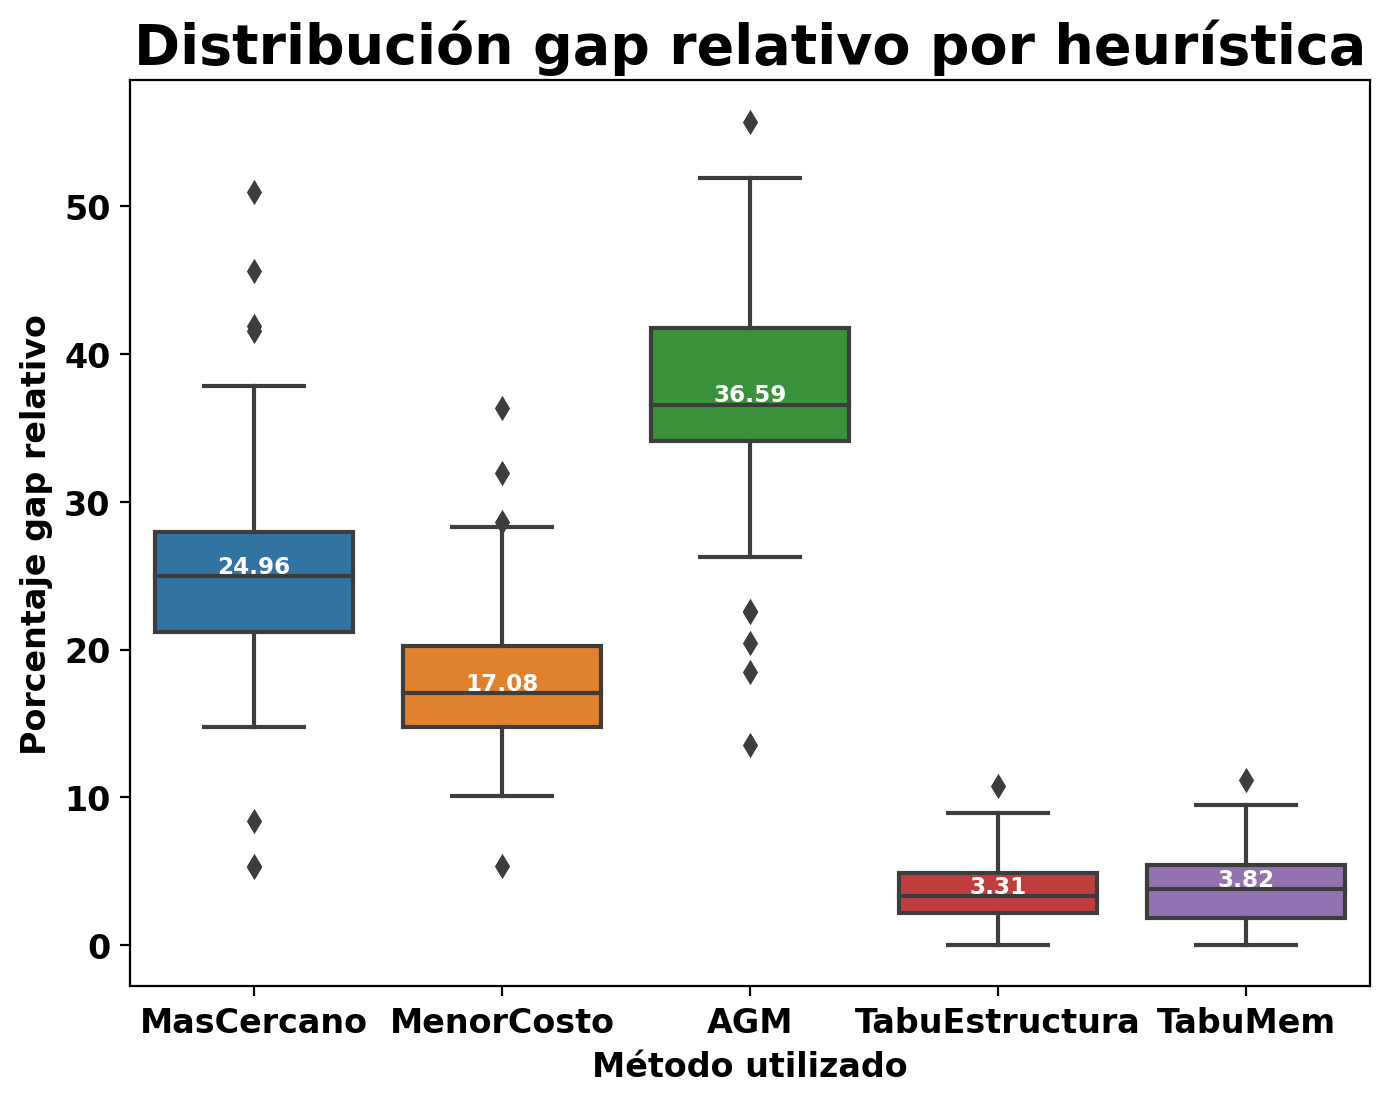

In [41]:
dfComparaciones = pathToPandas('DataExpFinal/', 'res')

dfComparacionesGaps = pd.DataFrame(columns=['Archivo']+METODOS)
dfComparacionesGaps['Archivo'] = dfComparaciones['Archivo'].unique()
for metodo in METODOS:
    dfComparacionesGaps[metodo] = gapsRelativosPorMetodo(dfComparaciones, dfOptimos, metodo)
gapsRelativosToBoxplot(dfComparacionesGaps, save=False, out='graficos/comparacionFinal/GapVsMetodo.png')

##IMPORTANTE, NO BORRAR
dfComparacionesGaps.set_index('Archivo', inplace=True)

## Tiempo vs cantNodos

In [42]:
def dfToScatterFinal(dfMediciones, x, y, dfGaps, hue, title, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
    
    
    #Sacamos el df que necesitamos y si usa tiempo lo cambiamos a ms
    dfIn = medicionesToXYdf(dfMediciones, x, y, dfGaps)
    
    if x == 'Tiempo' or y == 'Tiempo':
        dfIn.rename(columns={'Tiempo': 'Tiempo en ms'}, inplace=True)
        dfIn['Tiempo en ms'] = dfIn['Tiempo en ms'].to_numpy(dtype=int)/1000   
        x = x if x != 'Tiempo' else 'Tiempo en ms'
        y = y if y != 'Tiempo' else 'Tiempo en ms'

    #Graficamos scatter
    sns.scatterplot(data=dfIn.reset_index(), x=x, y=y, hue=hue)
    
    #Seteamos titulo y labels
    plt.title(title, fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel('Cantidad de nodos', fontsize =LABELSIZE)
    plt.ylabel(y, fontsize =LABELSIZE)
    
    if save and out != '':
        plt.savefig(out)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

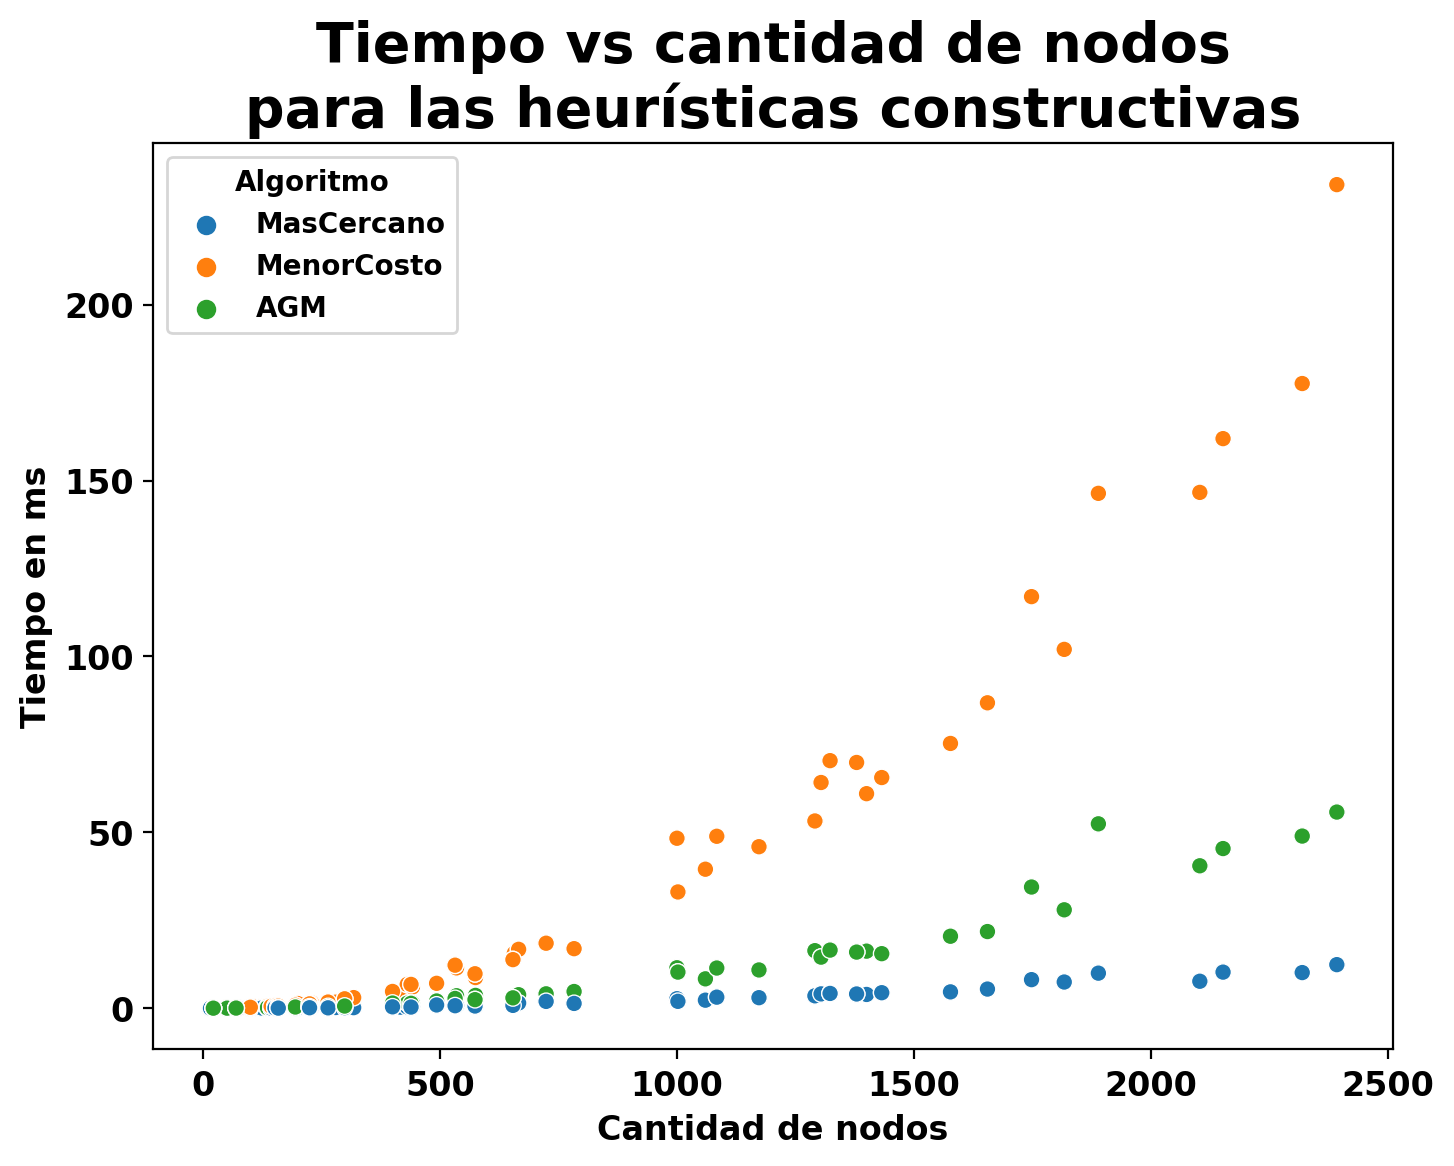

In [43]:
dfToScatterFinal(dfComparaciones, 'CantNodos', 'Tiempo', dfComparacionesGaps,'Algoritmo', 'Tiempo vs cantidad de nodos\npara las heurísticas constructivas', save=False, out='graficos/comparacionFinal/TiempoVsCantNodosZoom.png')

<Figure size 432x288 with 0 Axes>

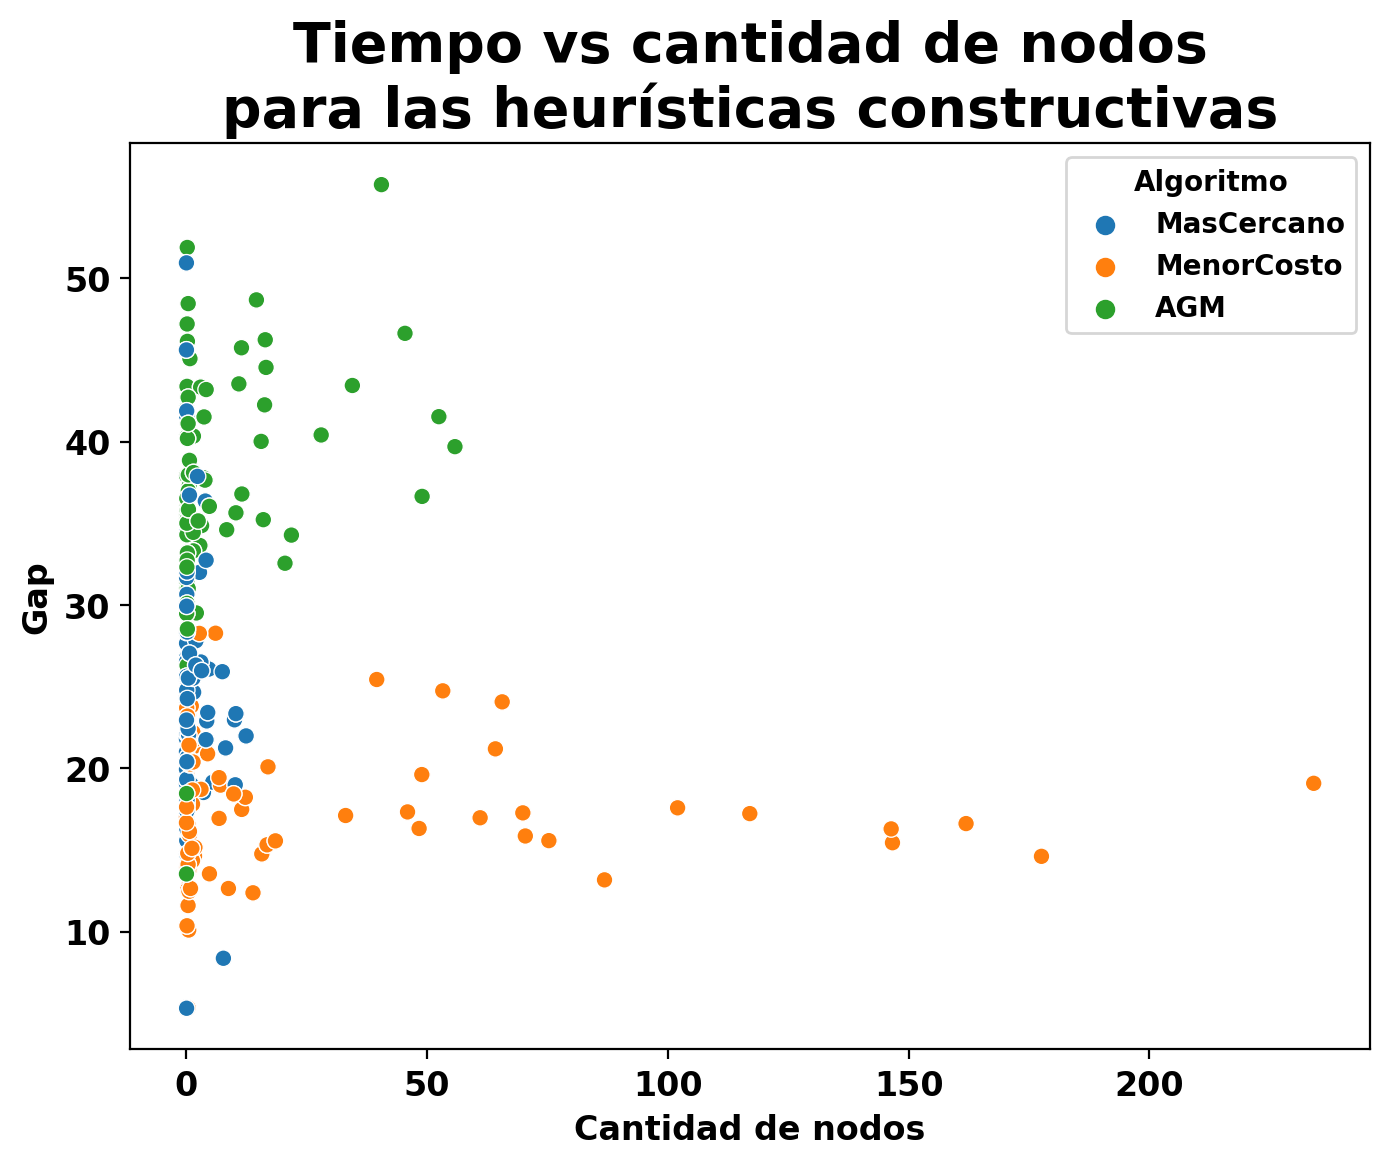

In [44]:
dfToScatterFinal(dfComparaciones, 'Tiempo', 'Gap', dfComparacionesGaps,'Algoritmo', 'Tiempo vs cantidad de nodos\npara las heurísticas constructivas', save=False, out='graficos/comparacionFinal/TiempoVsCantNodosZoom.png')

## Patologicos

In [54]:
def barplotPatologicos(df, todos=True,alg='',save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20

    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    algoritmos =['MasCercano', 'MenorCosto', 'AGM', 'TabuEstructura', 'TabuMem']
    fig, ax = plt.subplots(dpi=200, figsize=(10,8))
    if todos:
        df.plot(x='Archivo',y=algoritmos, kind='bar', ax=ax)
         #Seteamos titulo y labels
        plt.title('Costo del camino en función del peso de la\narista de cierre por algoritmo', fontweight="bold", fontsize = TITLESIZE)

    else:
        sns.barplot(data=df, x='PesoUltimaArista', y =alg)#,palette=sns.color_palette("hls", 8))
        #df.plot(x='PesoUltimaArista',y=alg, kind='bar', ax=ax)
        #Seteamos titulo y labels
        plt.ylim(0,130)
        plt.title('Costo del camino en función del peso de la arista\nde cierre de '+alg, fontweight="bold", fontsize = TITLESIZE)
        
    
    plt.locator_params(axis='x', nbins=9)
    x_ticks = np.arange(10, 100, 10)
#     ax.set_xticklabels(x_ticks)
    plt.xticks(rotation=90)    

    plt.xlabel('Costo arista cierre', fontsize =LABELSIZE)
    plt.ylabel('Peso del camino', fontsize =LABELSIZE)   
    plt.tight_layout()
#     plt.xticks(rotation=90)

    if save and out != '':
        plt.savefig(out)
    plt.show()

### Empezamos con patologico para todas las heuristicas

### Levantamos

In [47]:
# def pesosToBoxplot(dfGaps, title, Xlabel, Ylabel, save=False, out=''):
#     LABELSIZE = 12
#     TITLESIZE = 20
    
#     #Seteamos tamanio y bold en todas las letras
#     plt.rcParams["font.weight"] = "bold"
#     plt.rcParams["axes.labelweight"] = "bold"
#     plt.rcParams["ytick.labelsize"] = LABELSIZE
#     plt.rcParams["xtick.labelsize"] = LABELSIZE
#     plt.tight_layout()
    
#     fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
#     #Seteamos titulo y labels
#     plt.title(title, fontweight="bold", fontsize = TITLESIZE)
#     plt.xlabel(Xlabel, fontsize =LABELSIZE)
#     plt.ylabel(Ylabel, fontsize =LABELSIZE)
    
#     #Graficamos los BP
#     bp = sns.boxplot(data=dfGaps, ax=ax)
    
#     #Calculamos las medianas
#     medians = dfGaps.median().tolist()
    
#     for xtick in bp.get_xticks():
#         bp.text(xtick,medians[xtick] + 100, '{:.2f}'.format(medians[xtick]), 
#             horizontalalignment='center',size='small',color='w',weight='bold')

#     if save and out != '':
#         plt.savefig(out)
        
#     plt.show()
    
# def patToCostosAGM(dfPat):
#     res = pd.DataFrame(columns=METODOS)
    
#     for metodo in METODOS:
#         res[metodo] = dfPat[dfPat['Tipo'] == 'Costo'][metodo].to_numpy()
#     return res
    
def patToCostos(dfPat):
    res = pd.DataFrame(columns=['Archivo']+METODOS)
    res['Archivo'] = dfPat['Archivo'].unique()
    
    for metodo in METODOS:
        res[metodo] = dfPat[dfPat['Tipo'] == 'Costo'][metodo].to_numpy()
    return res

In [48]:
dfPatologicos = pathToPandas('patologicosOut/', 'res')
dfCostosPat = patToCostos(dfPatologicos) \
.astype({'MasCercano': float, 'MenorCosto': float,'AGM': float, 'TabuEstructura': float, 'TabuMem': float })
dfCostosPat.sort_values('Archivo', ignore_index=True, inplace=True)
dfCostosPat.reset_index(inplace = True)
dfCostosPat.drop(['Archivo'], axis=1, inplace=True)
dfCostosPat['index'] += 10
dfCostosPat.rename(columns={'index':'PesoUltimaArista'}, inplace = True)

### Graficamos

<Figure size 432x288 with 0 Axes>

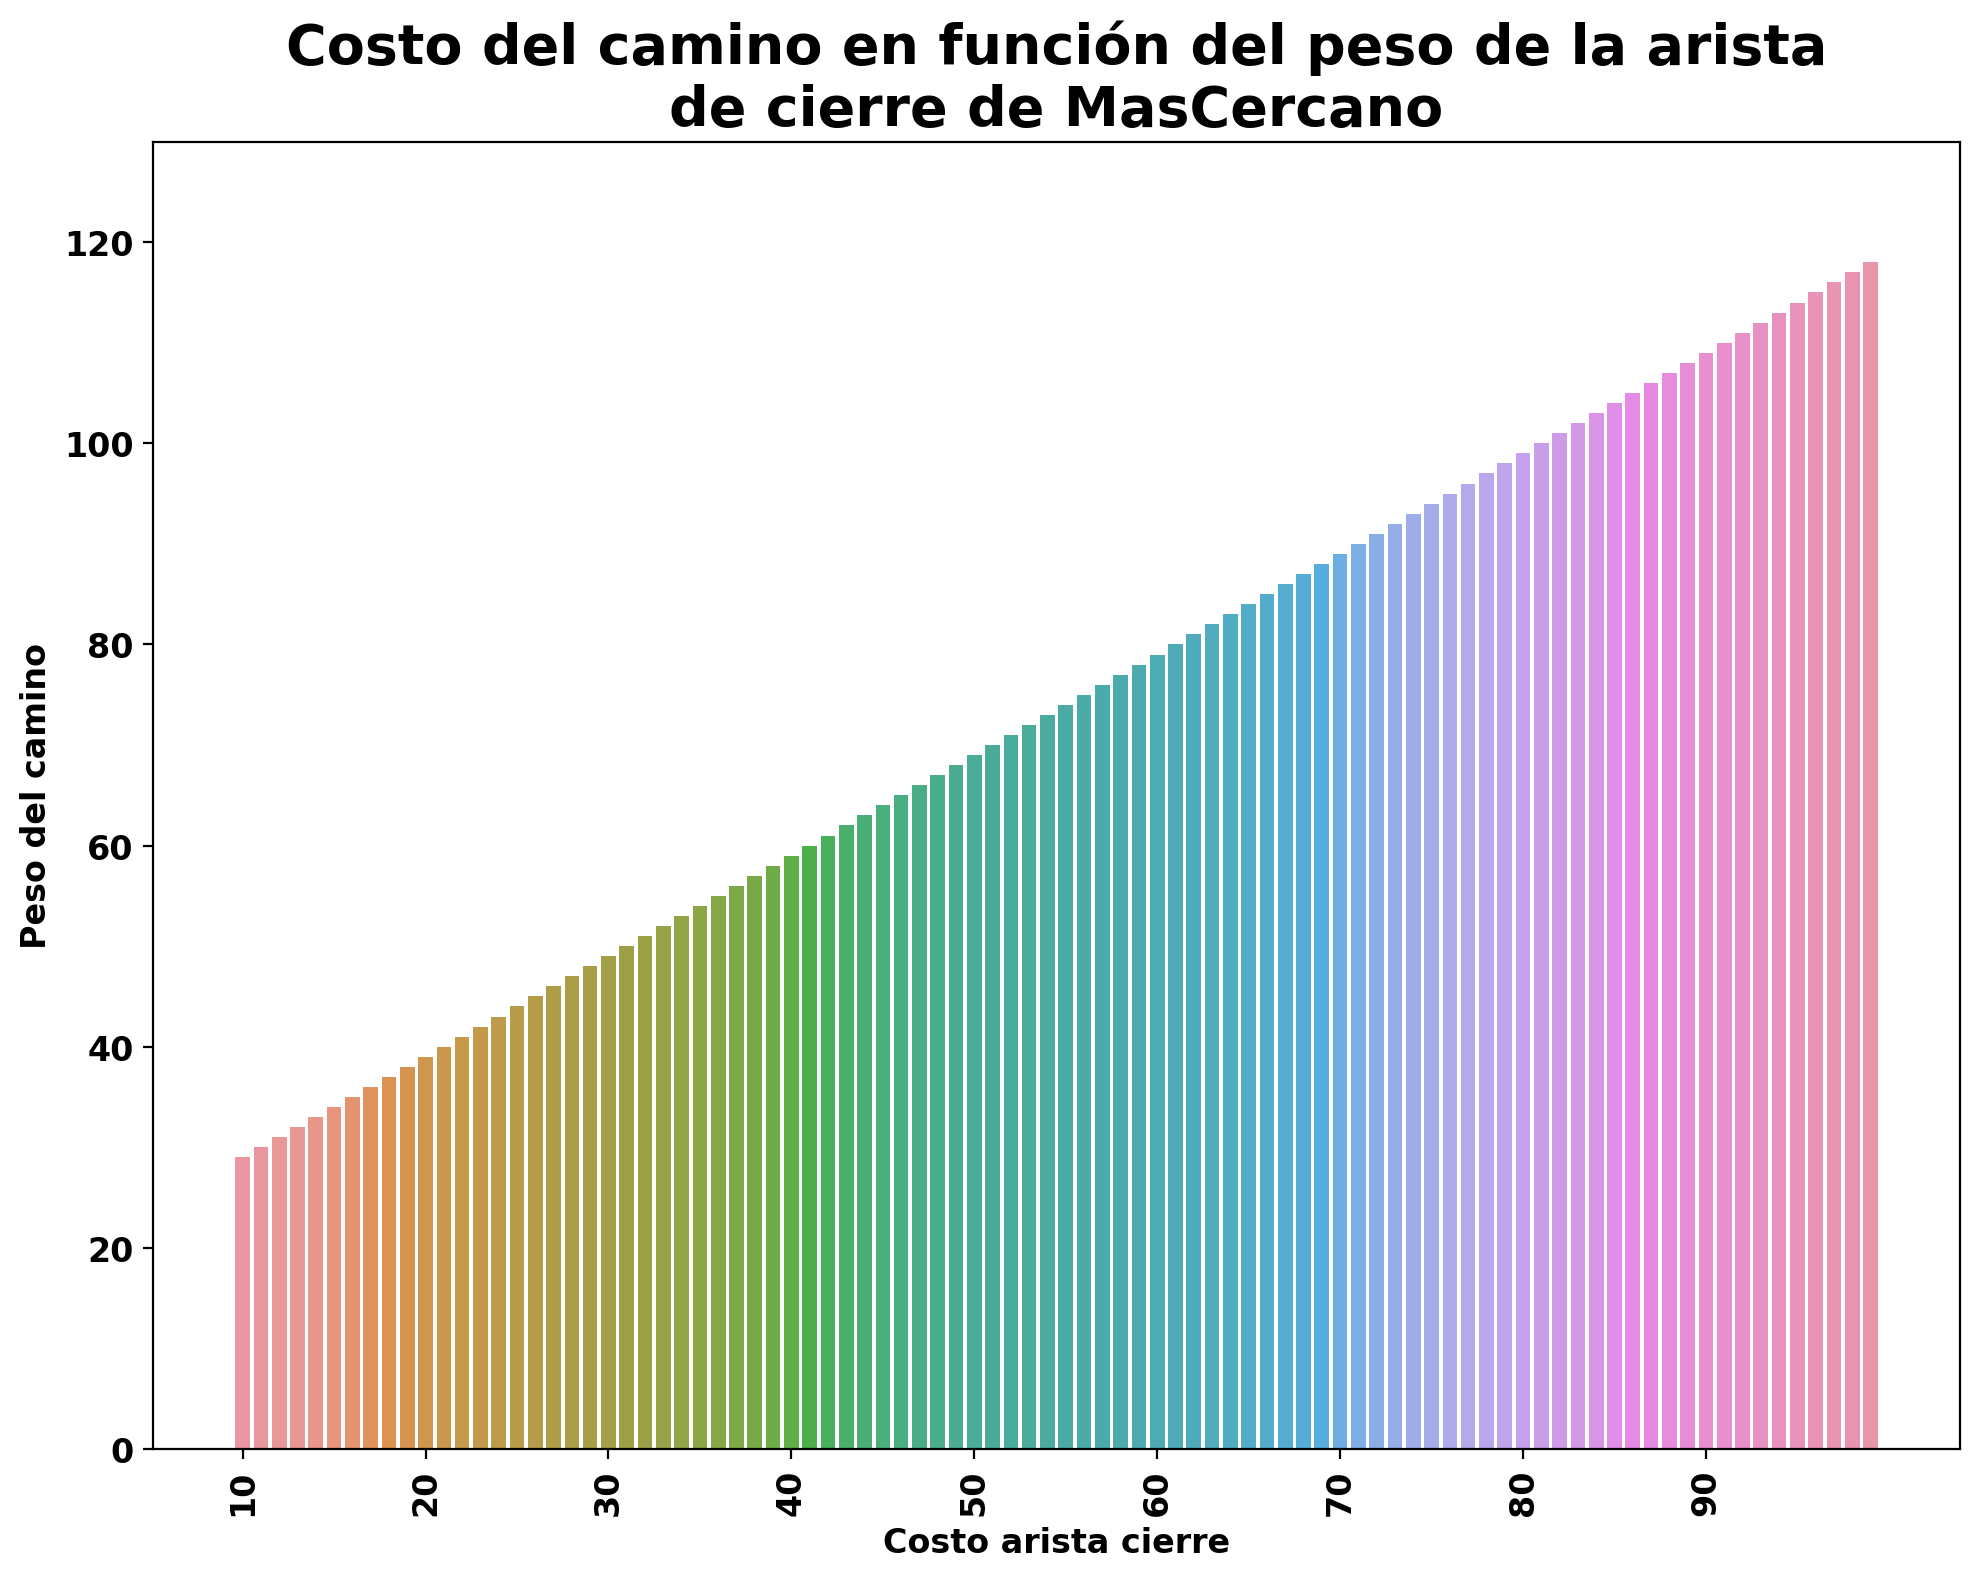

<Figure size 432x288 with 0 Axes>

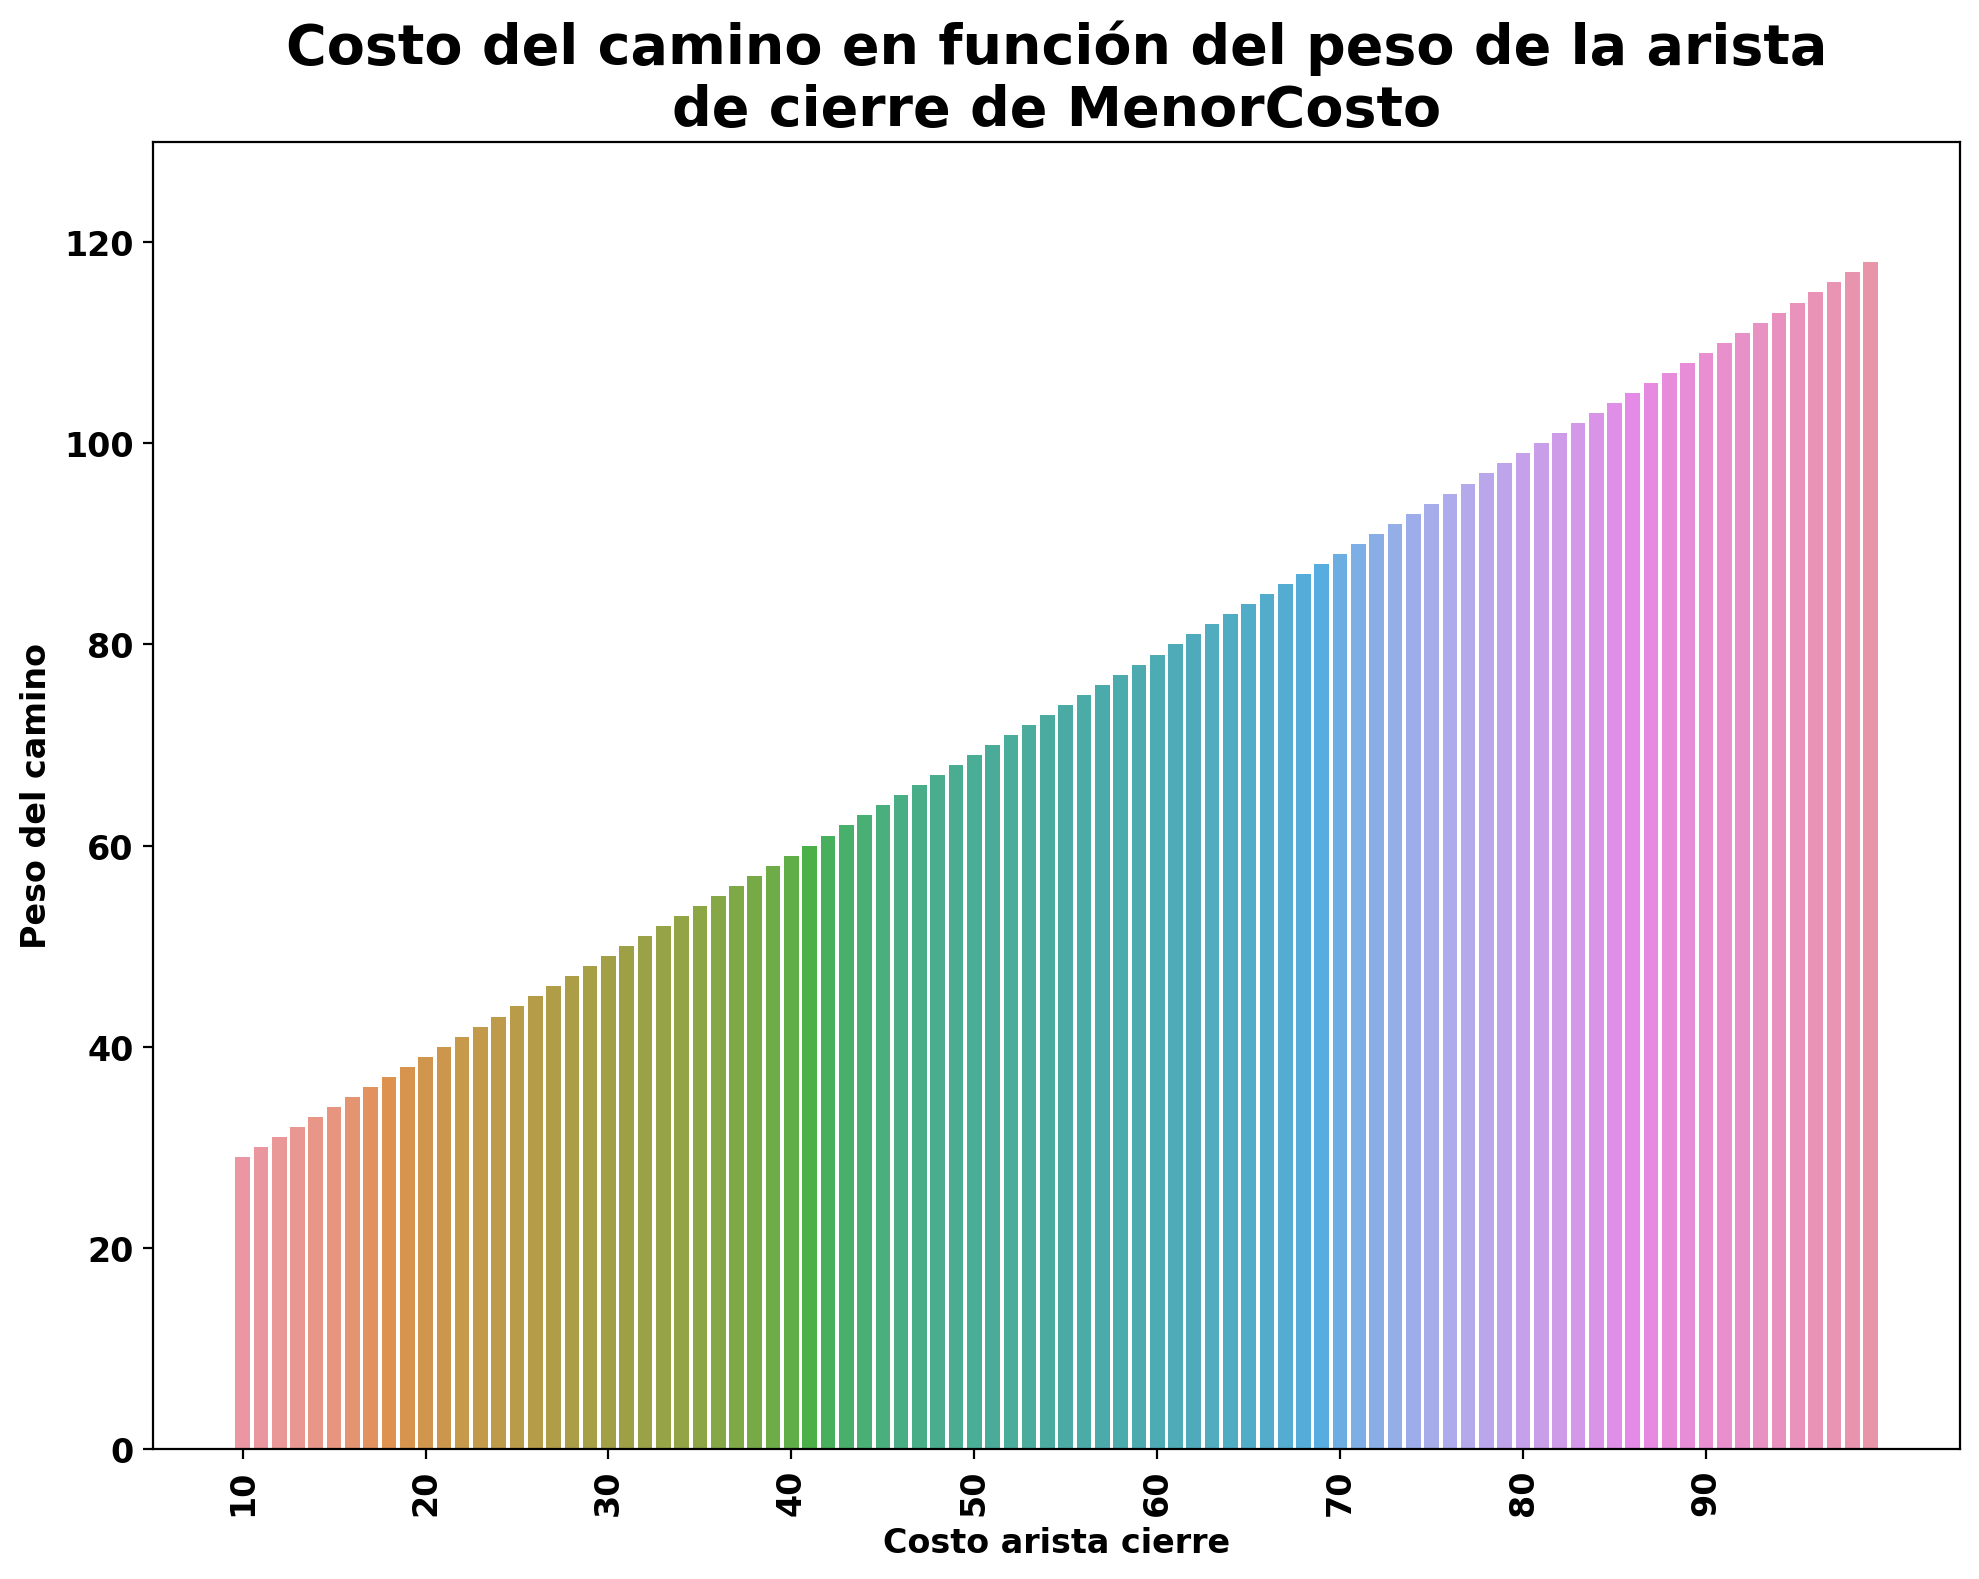

<Figure size 432x288 with 0 Axes>

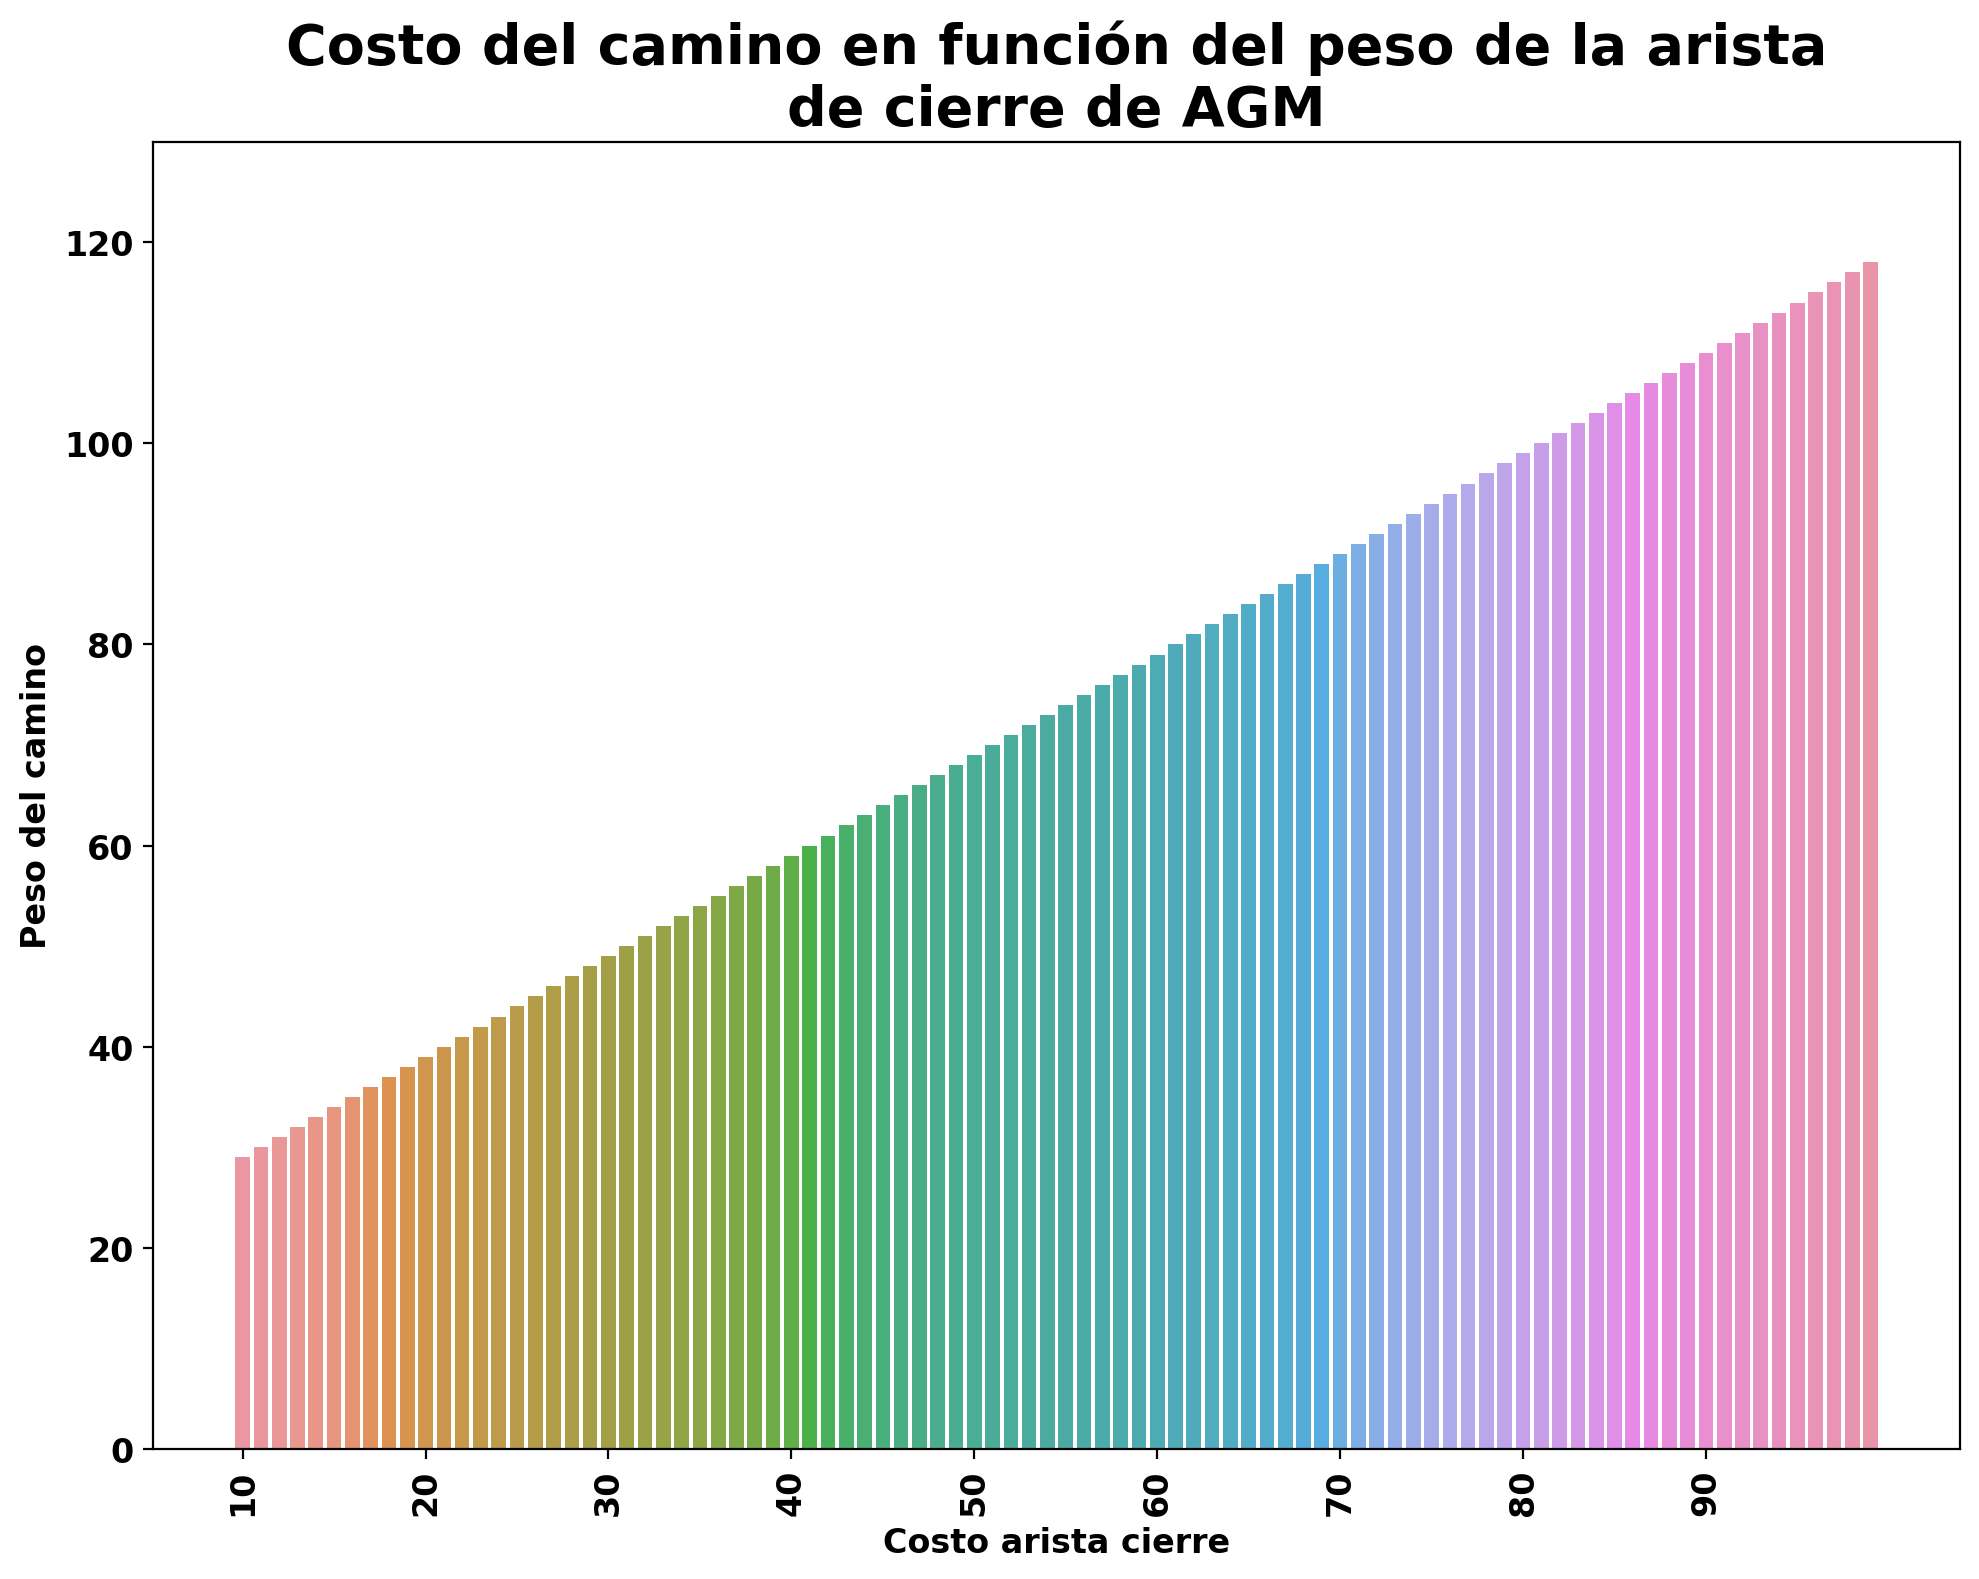

<Figure size 432x288 with 0 Axes>

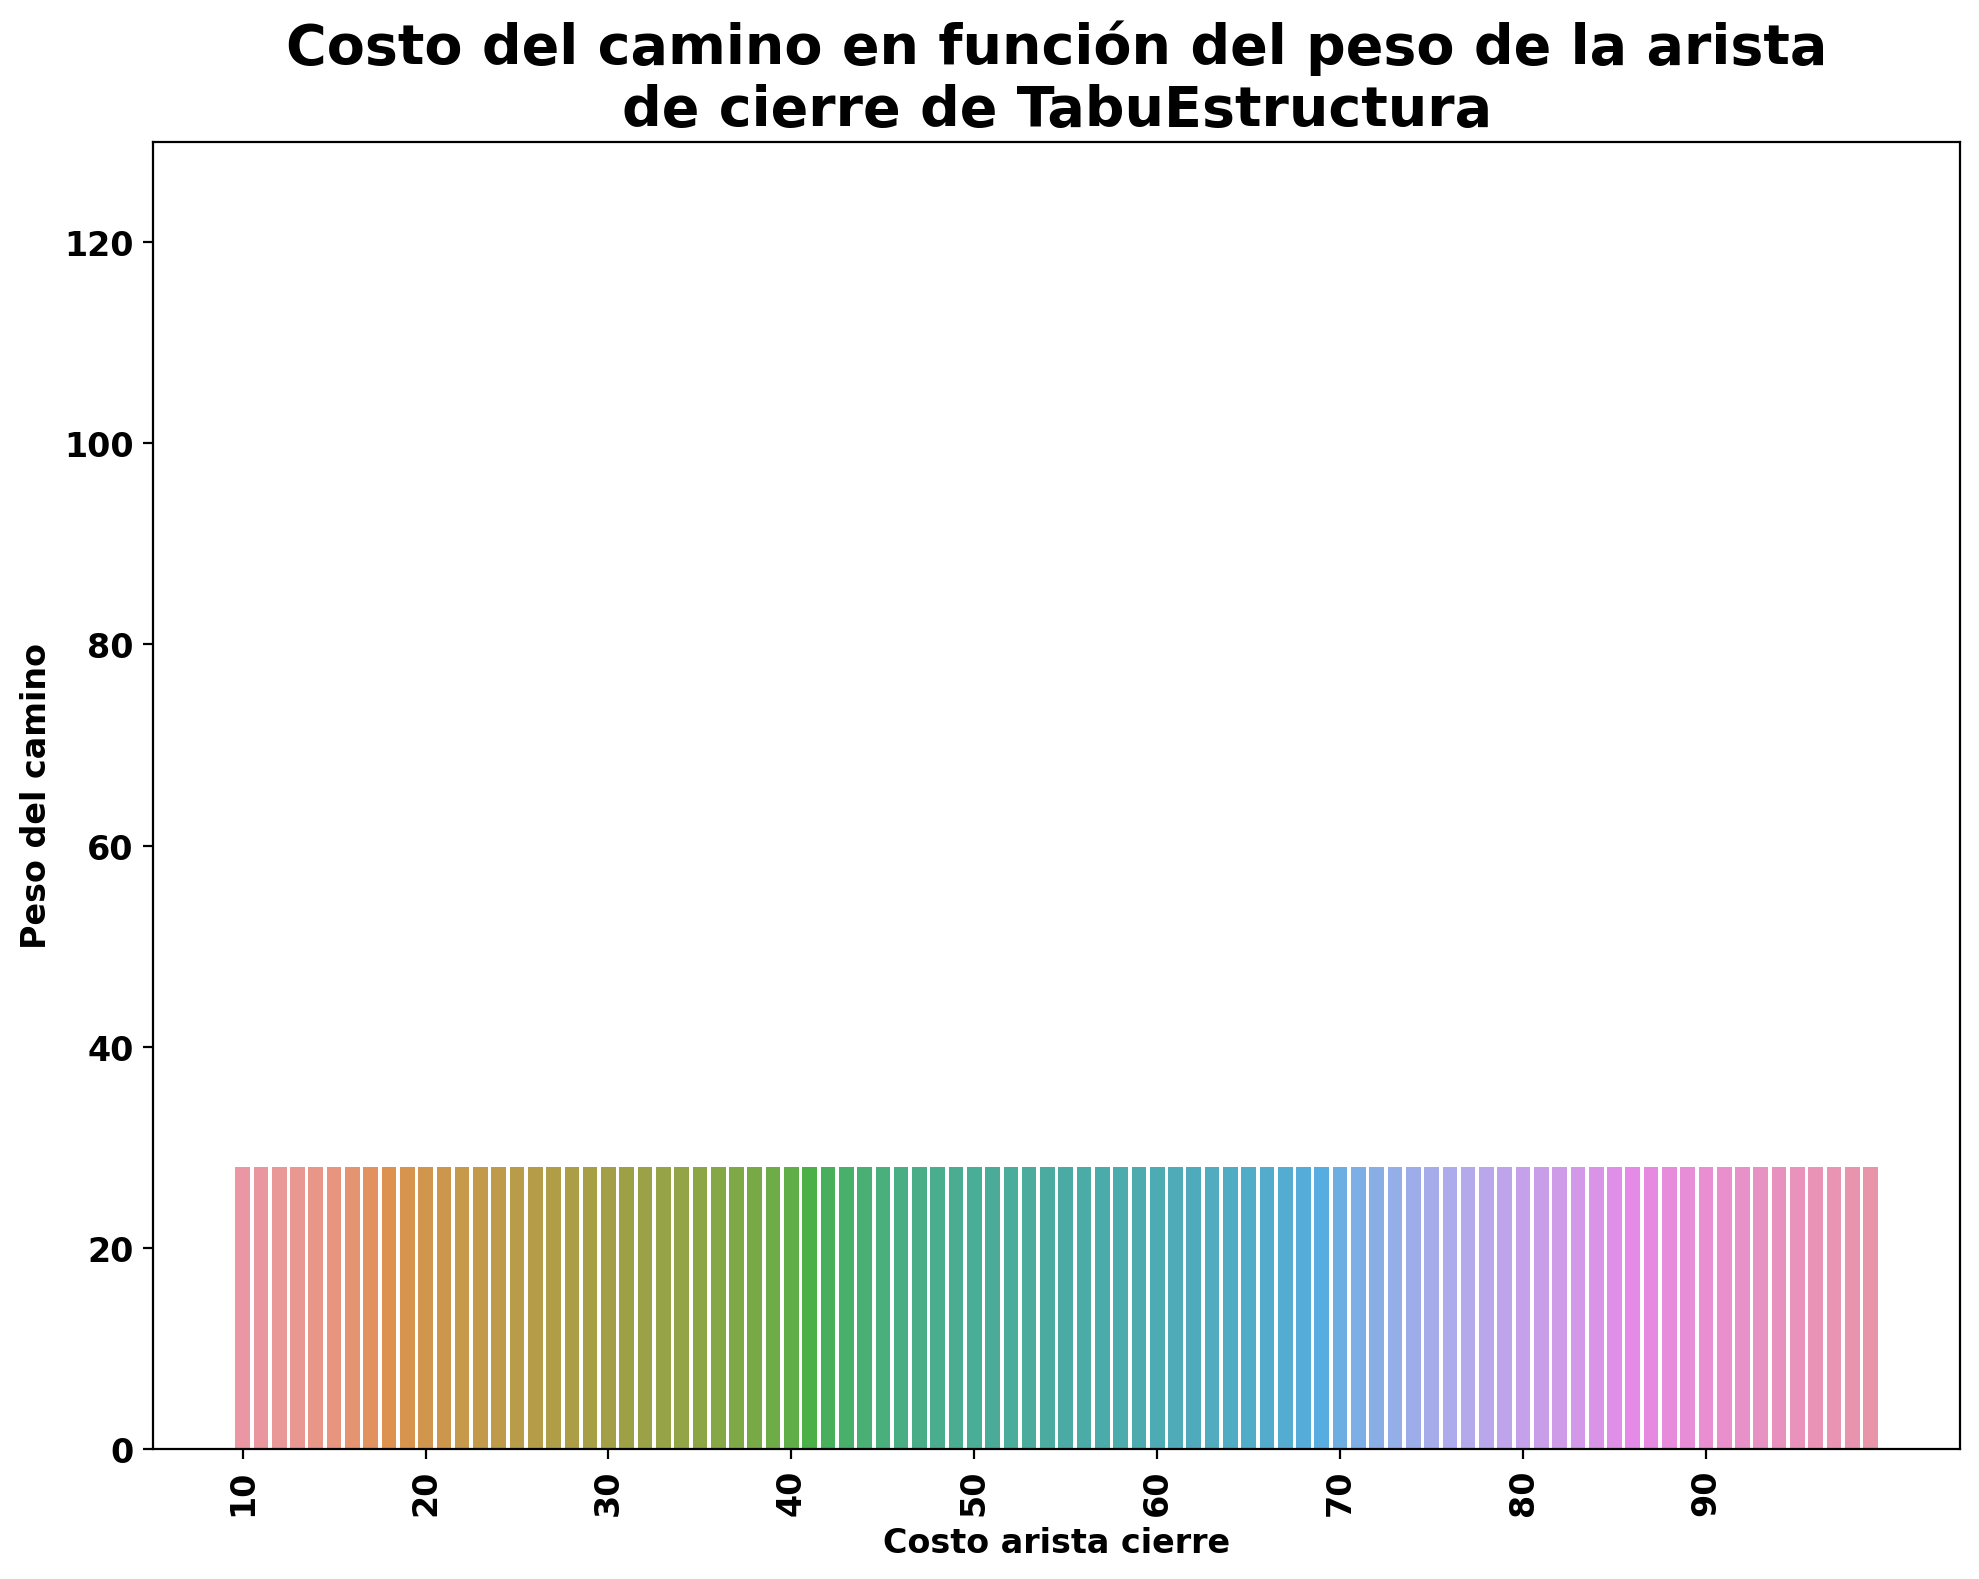

<Figure size 432x288 with 0 Axes>

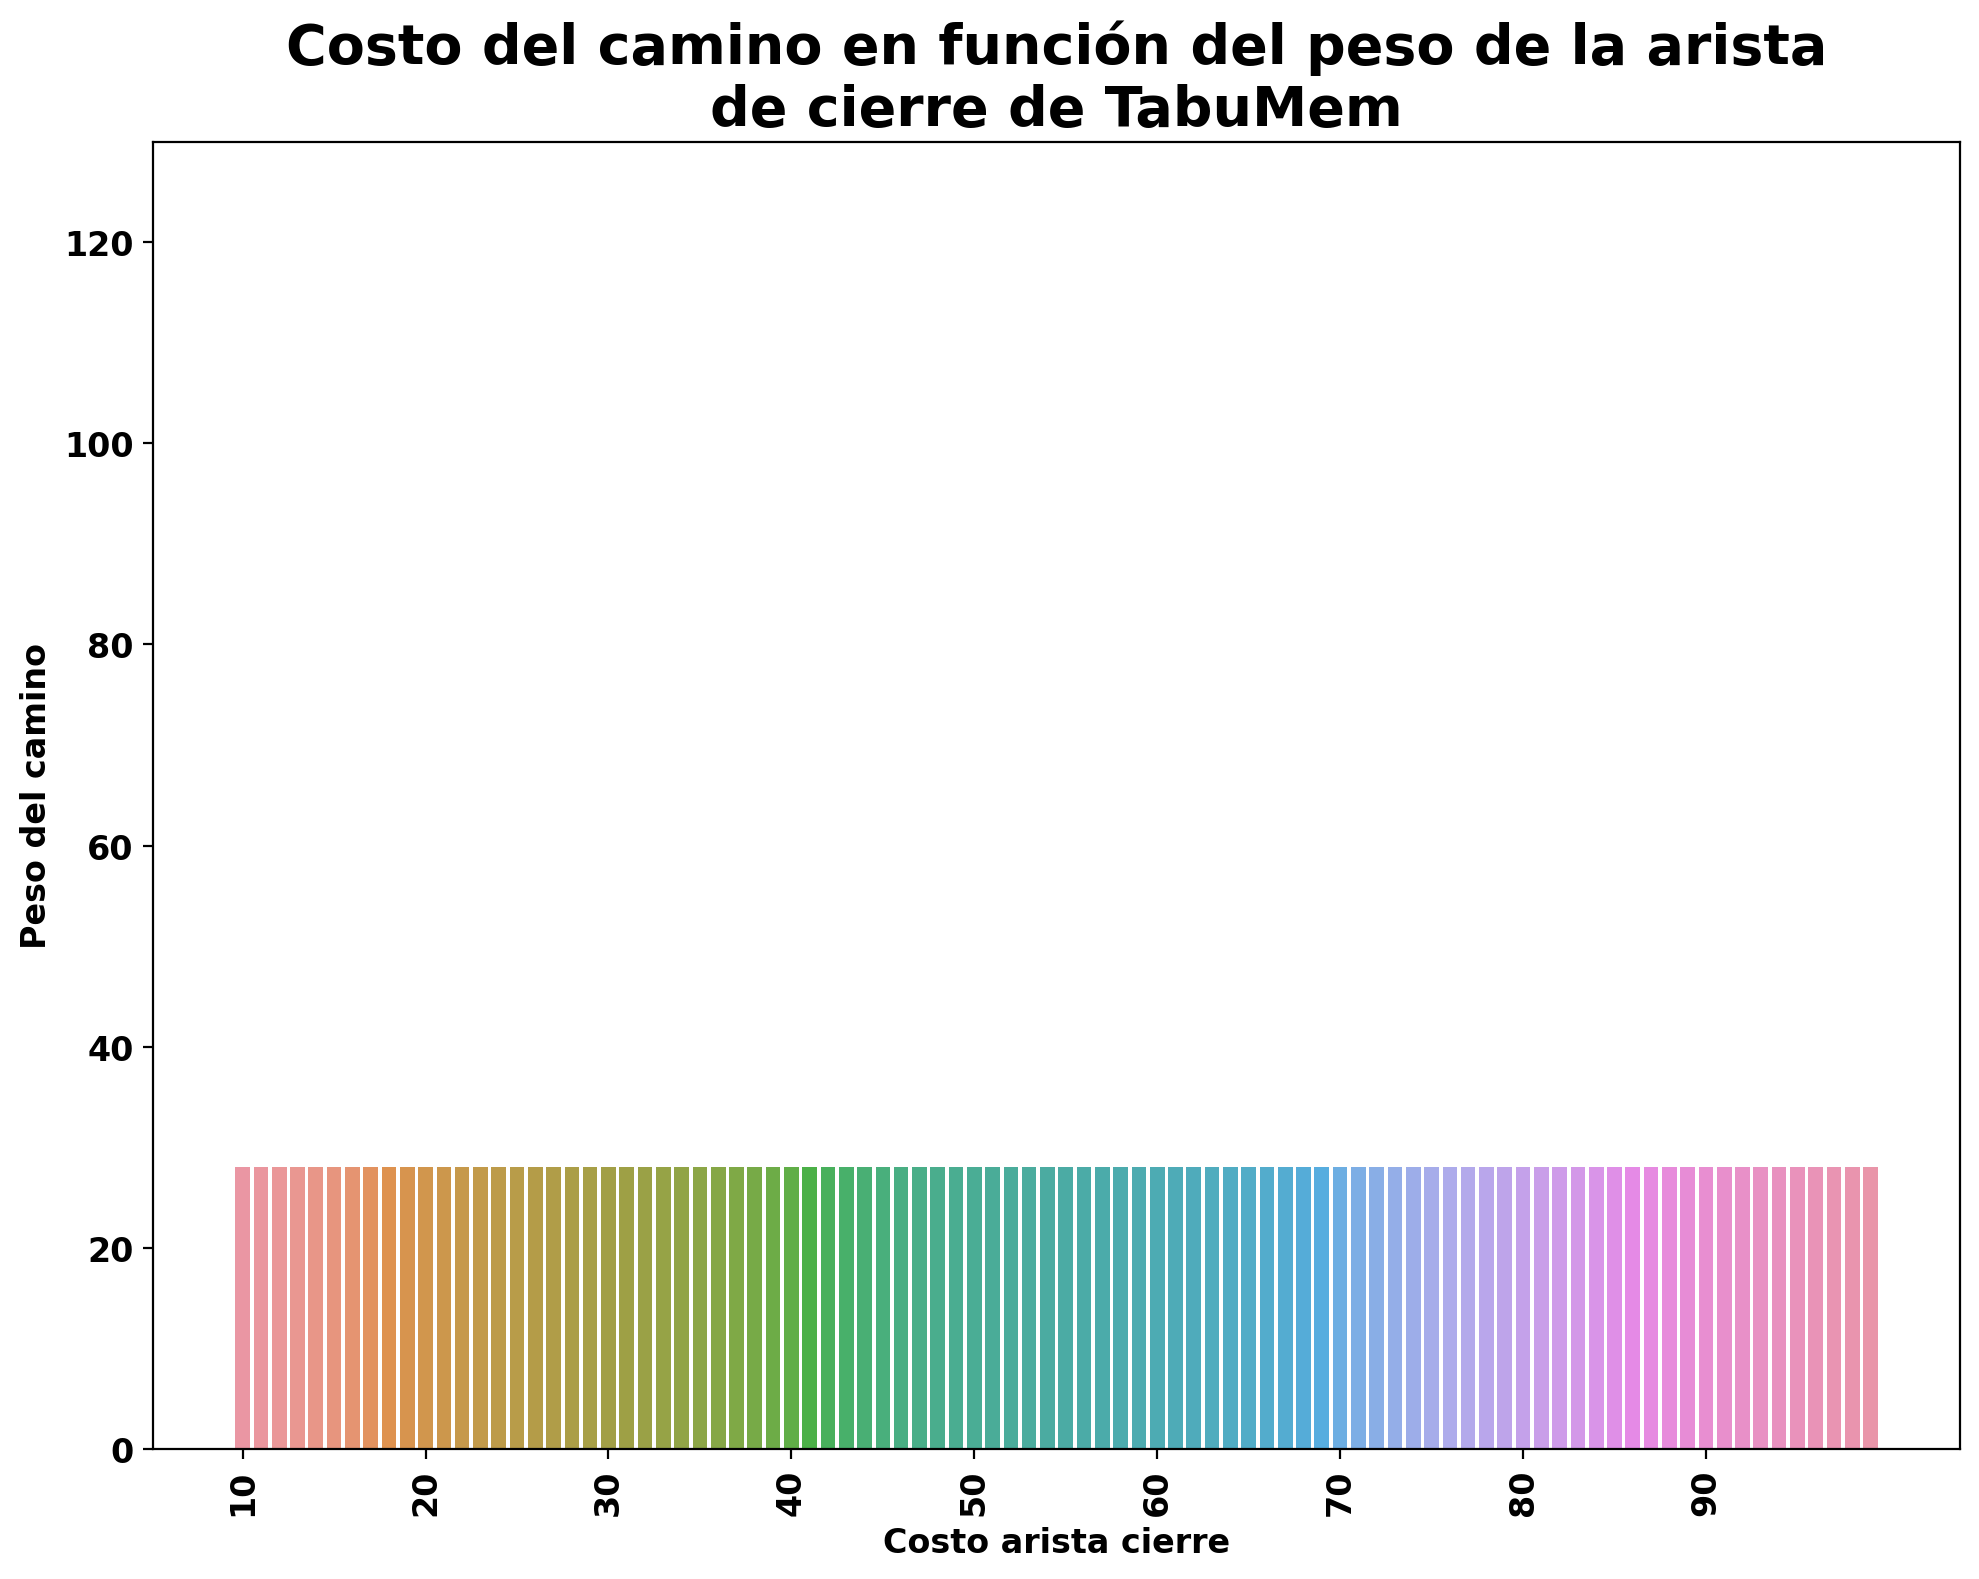

In [49]:
algoritmos =['MasCercano', 'MenorCosto', 'AGM', 'TabuEstructura', 'TabuMem']
for i in algoritmos:
    barplotPatologicos(dfCostosPat,todos=False, alg=i, save=False, out='graficos/patologicos/todos'+i+'.png')
    plt.show()

### Vamos al patologico contra AGM

### Levantamos los datos

In [56]:
dfPatoAGM = pathToPandas('patoAGMOut/', 'res')
dfPatoAGMPesos = patToCostos(dfPatoAGM) \
.astype({'Archivo': str, 'MasCercano': float, 'MenorCosto': float,'AGM': float, 'TabuEstructura': float, 'TabuMem': float }) \
.sort_values('Archivo', ignore_index=True) \
.reset_index() \
.rename(columns={'index': 'PesoUltimaArista'})
dfPatoAGMPesos['PesoUltimaArista'] += 1

### Graficamos

<Figure size 432x288 with 0 Axes>

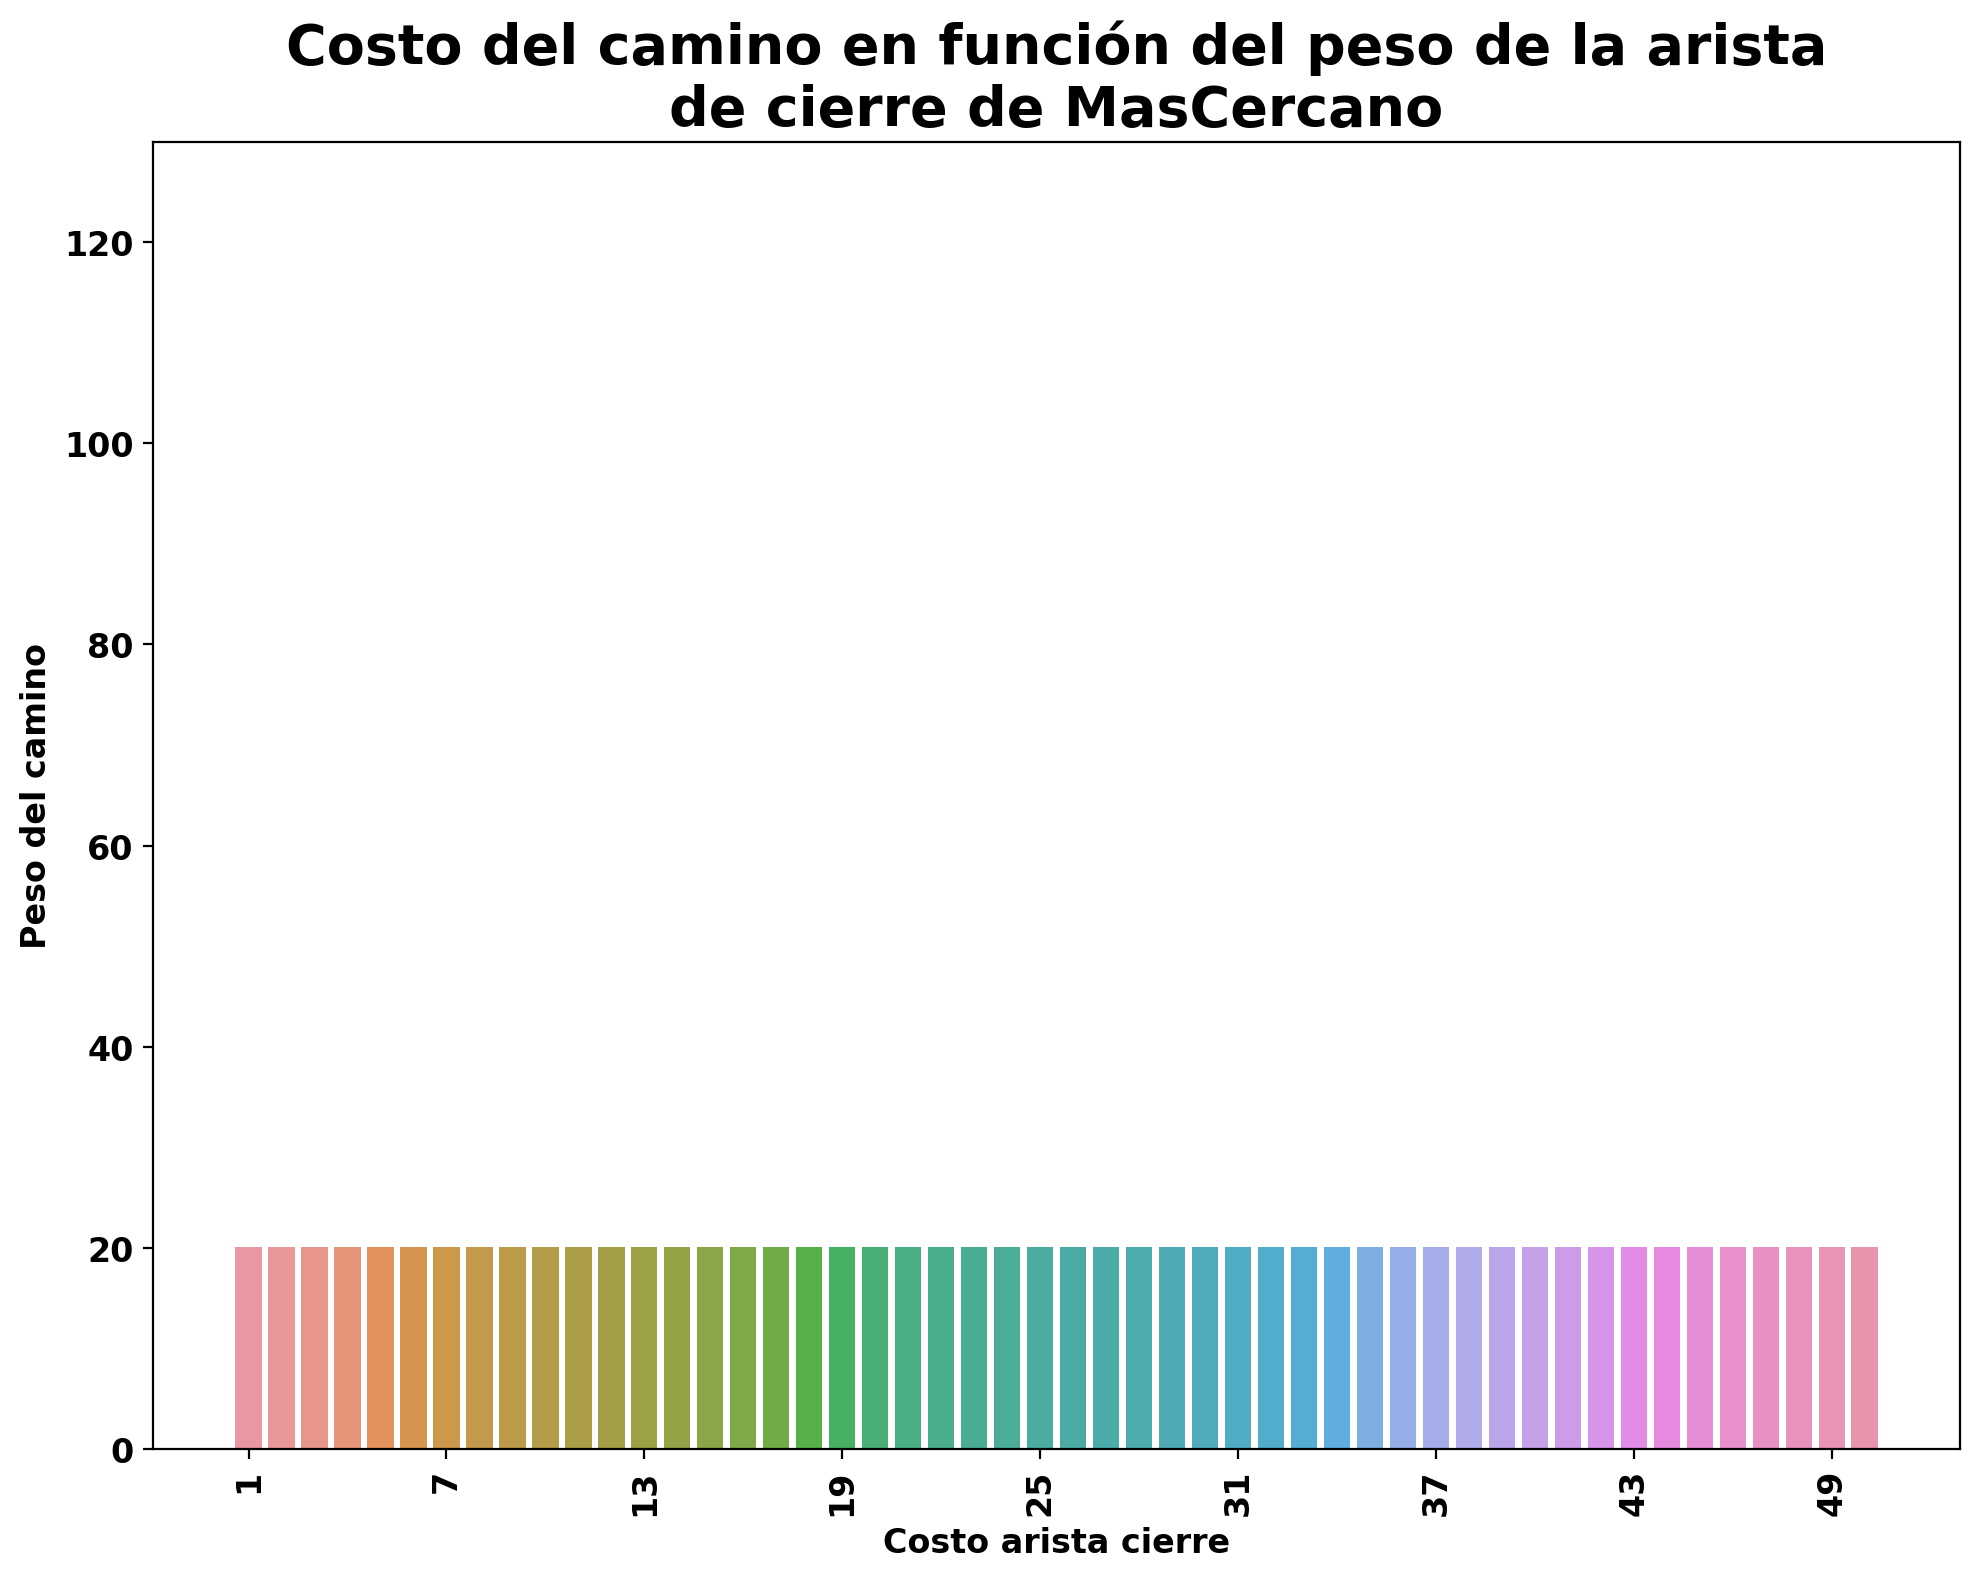

<Figure size 432x288 with 0 Axes>

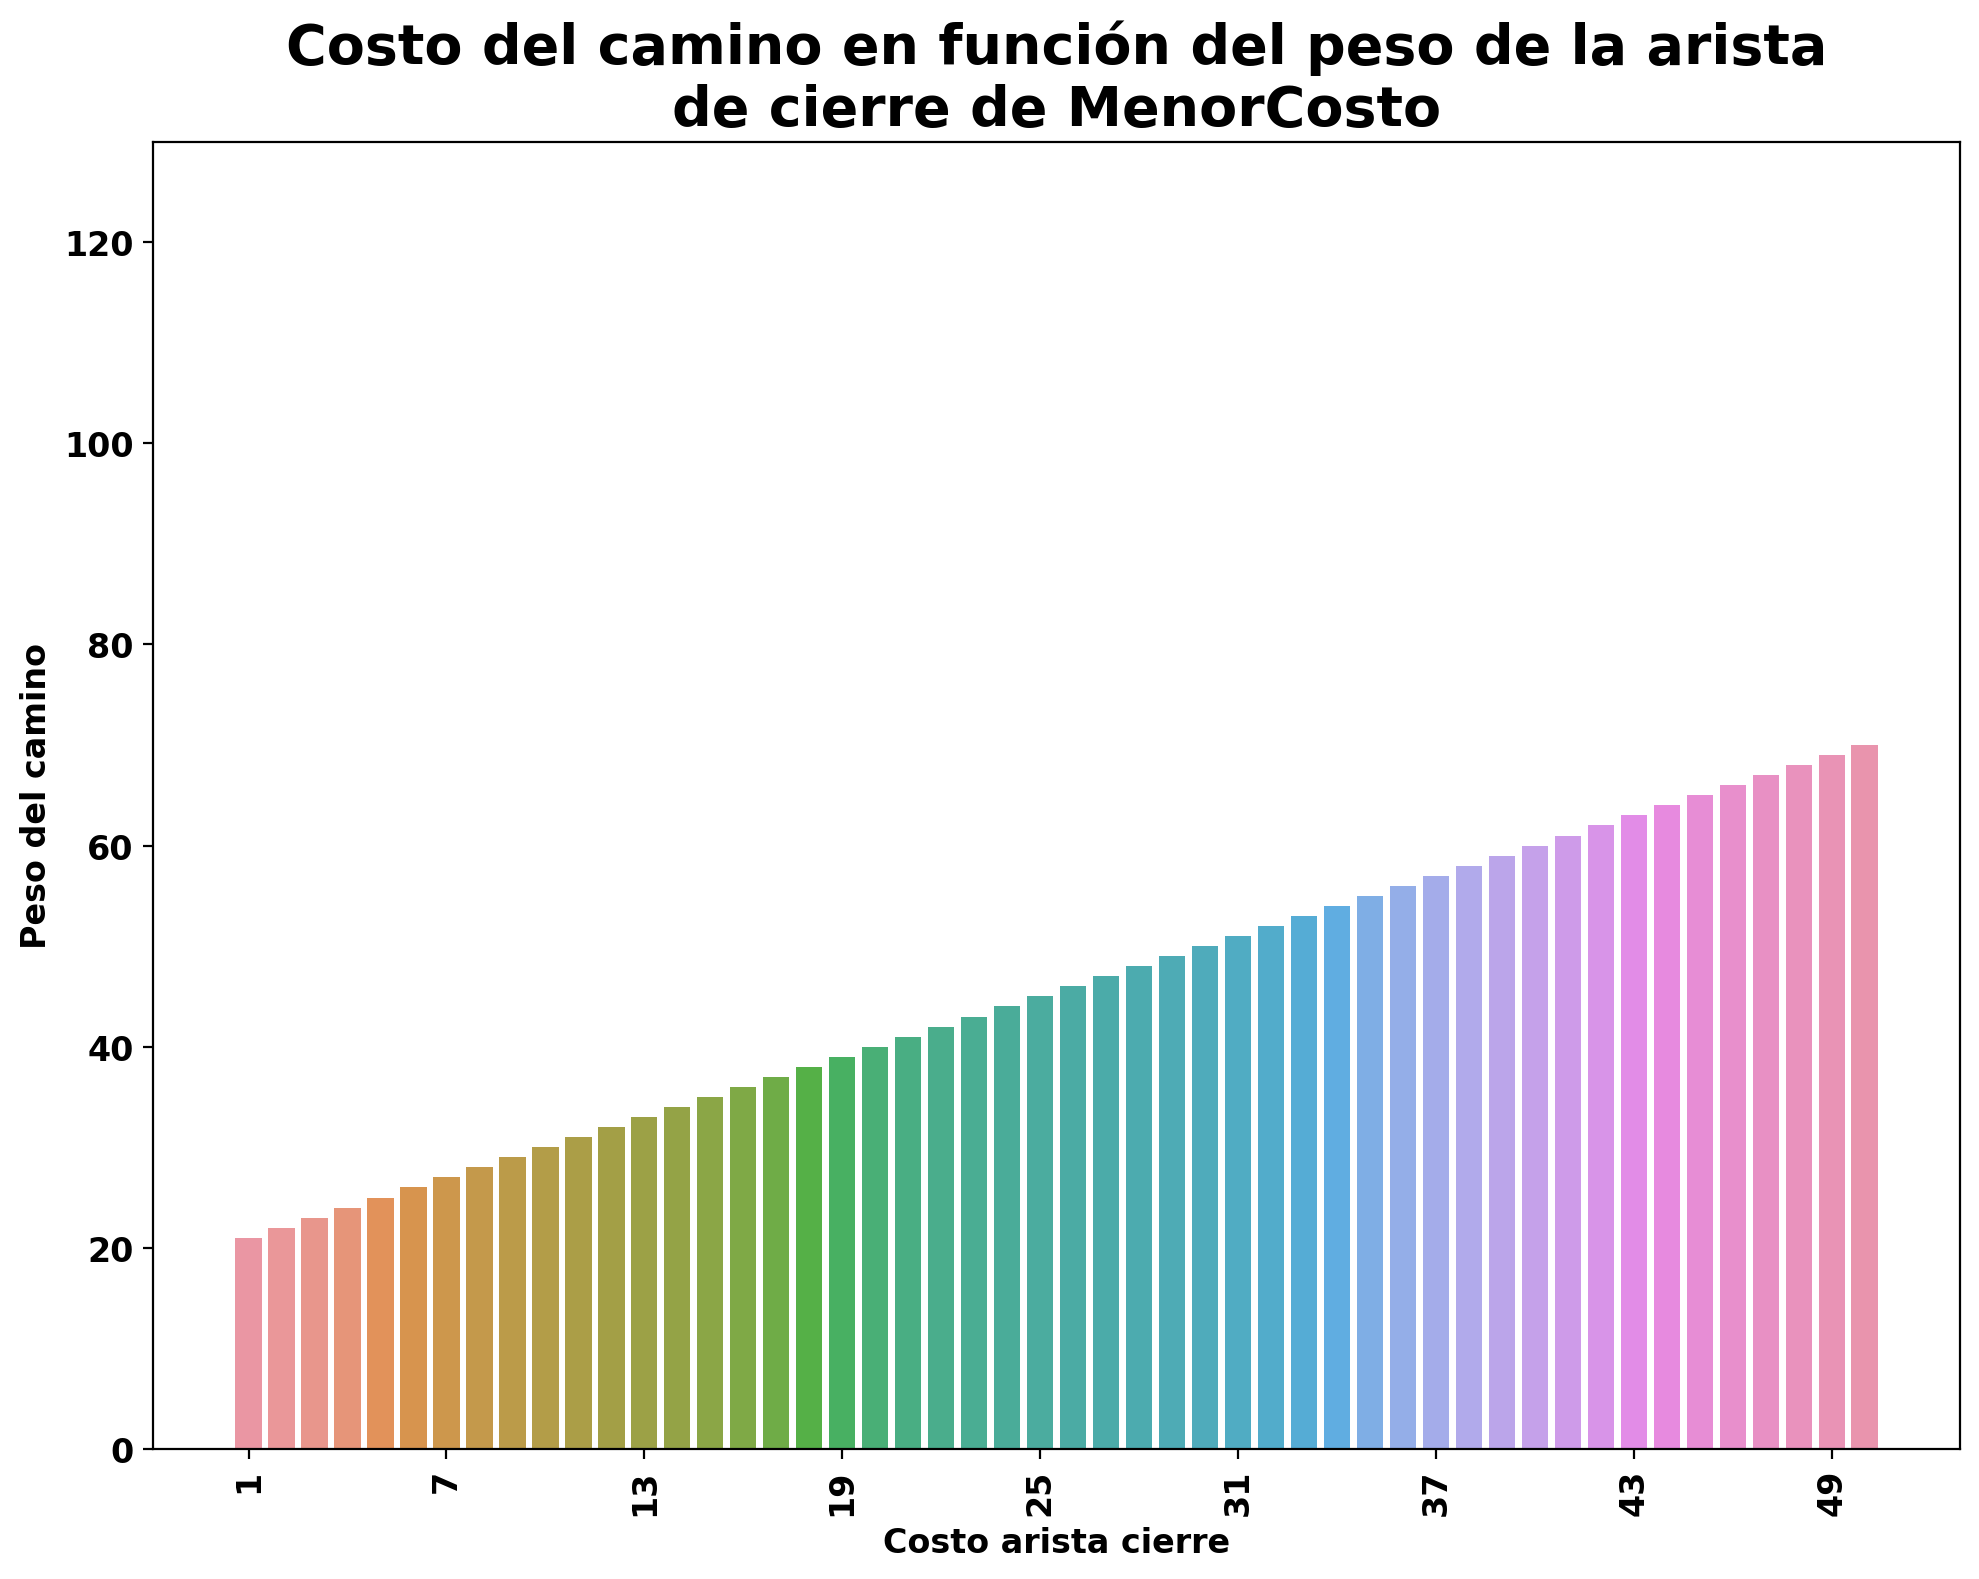

<Figure size 432x288 with 0 Axes>

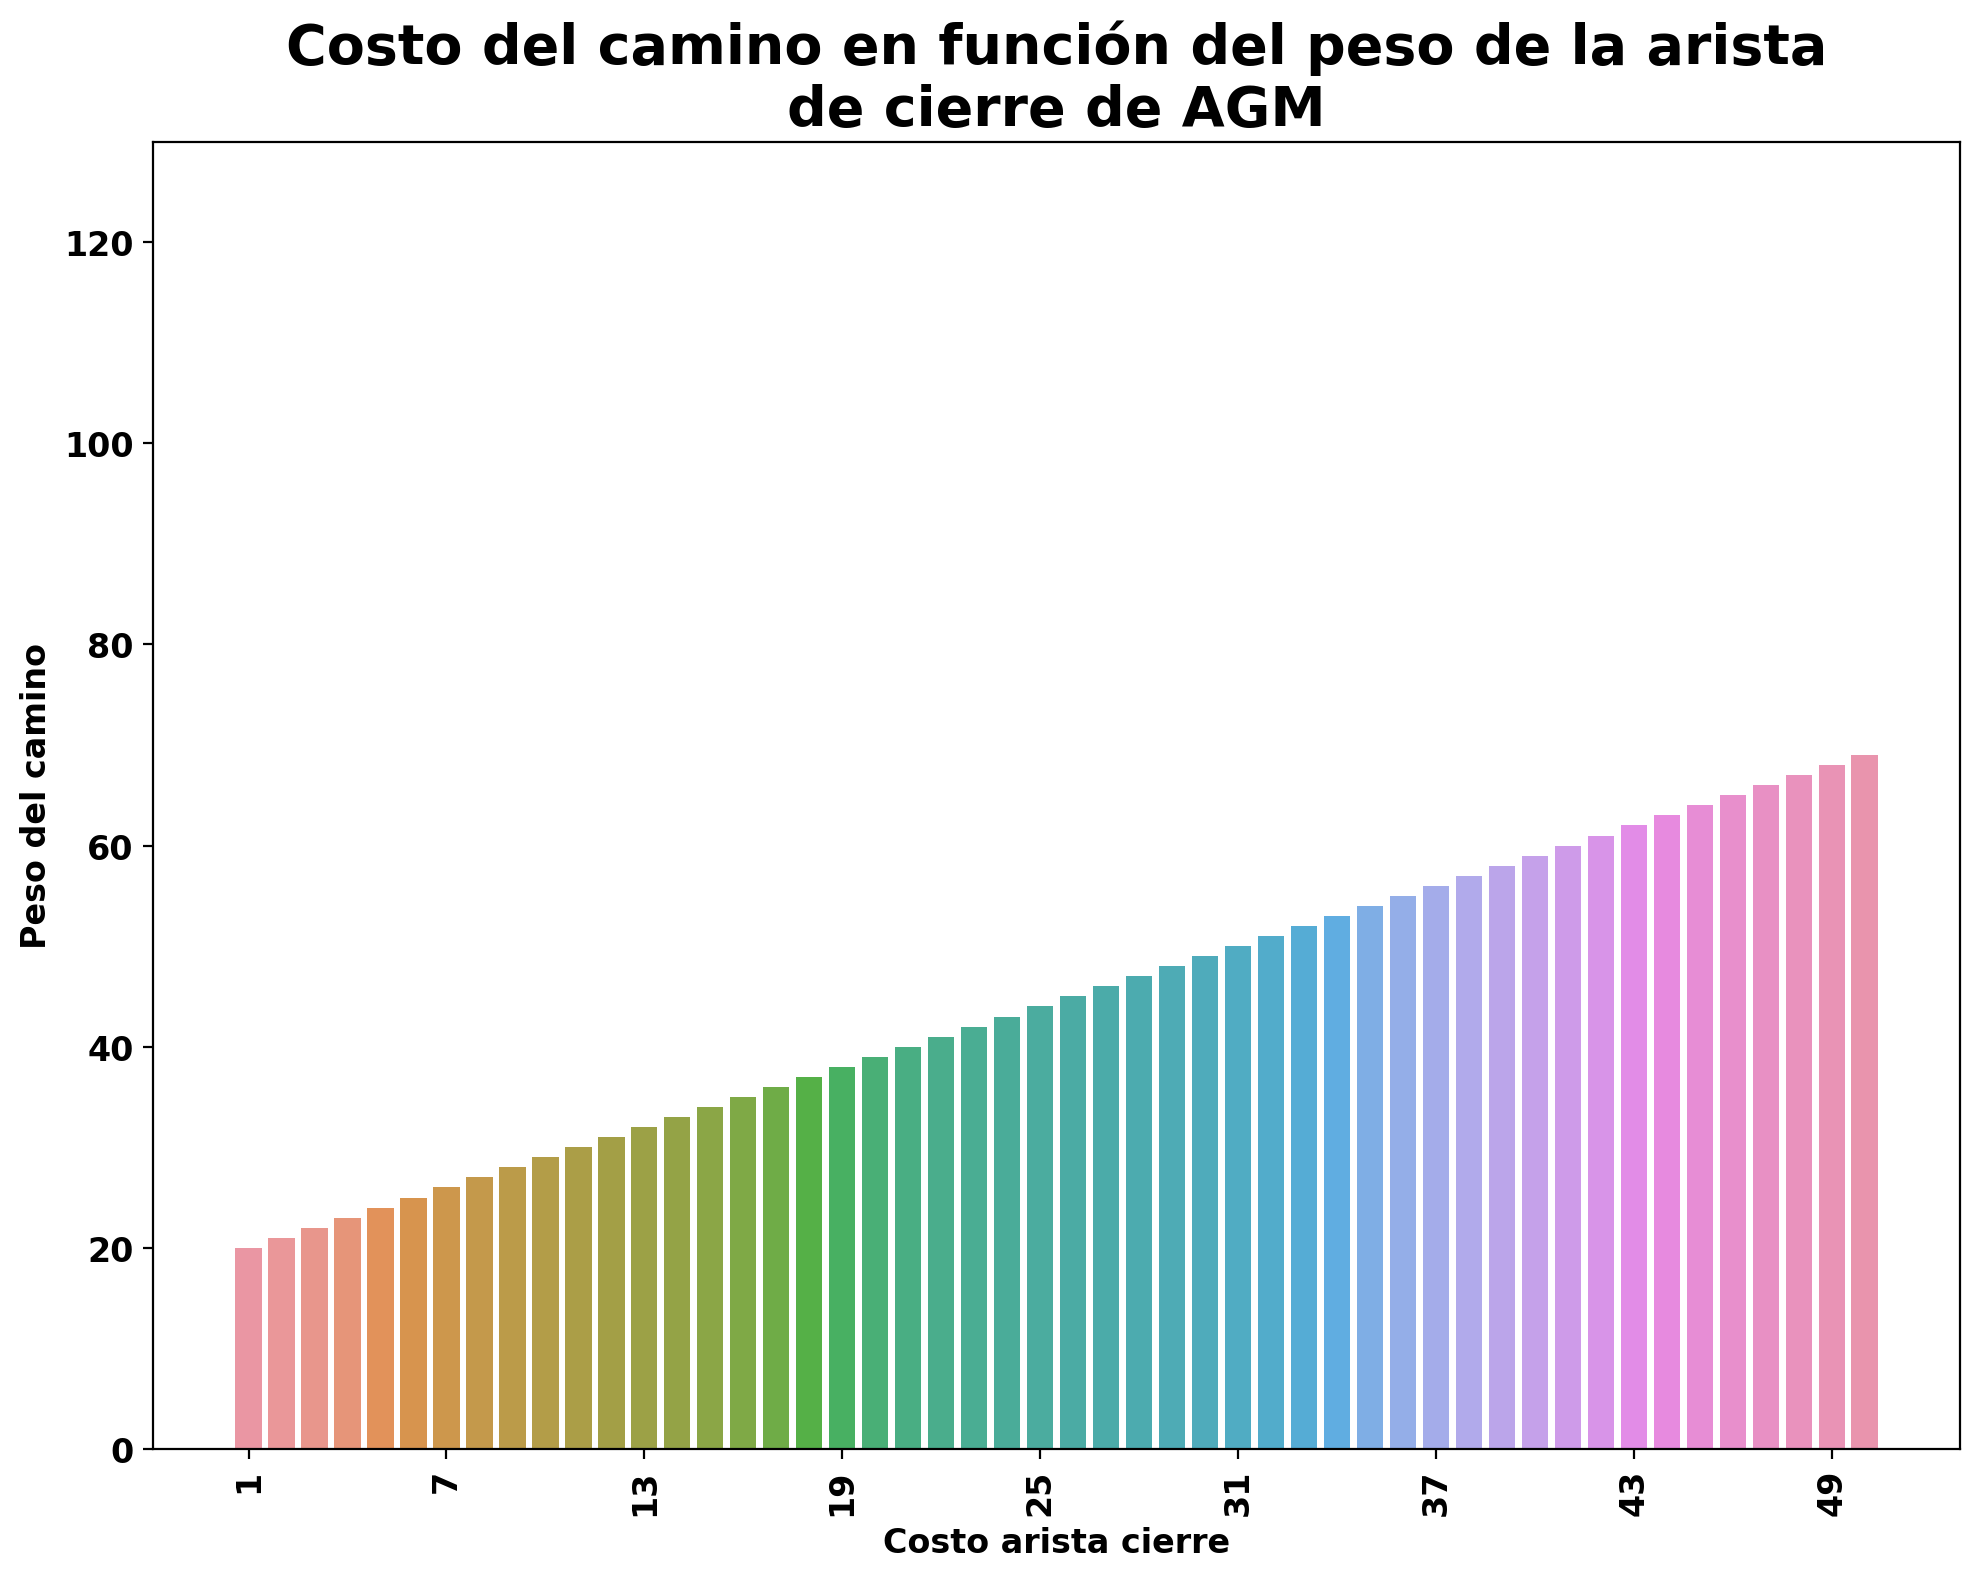

<Figure size 432x288 with 0 Axes>

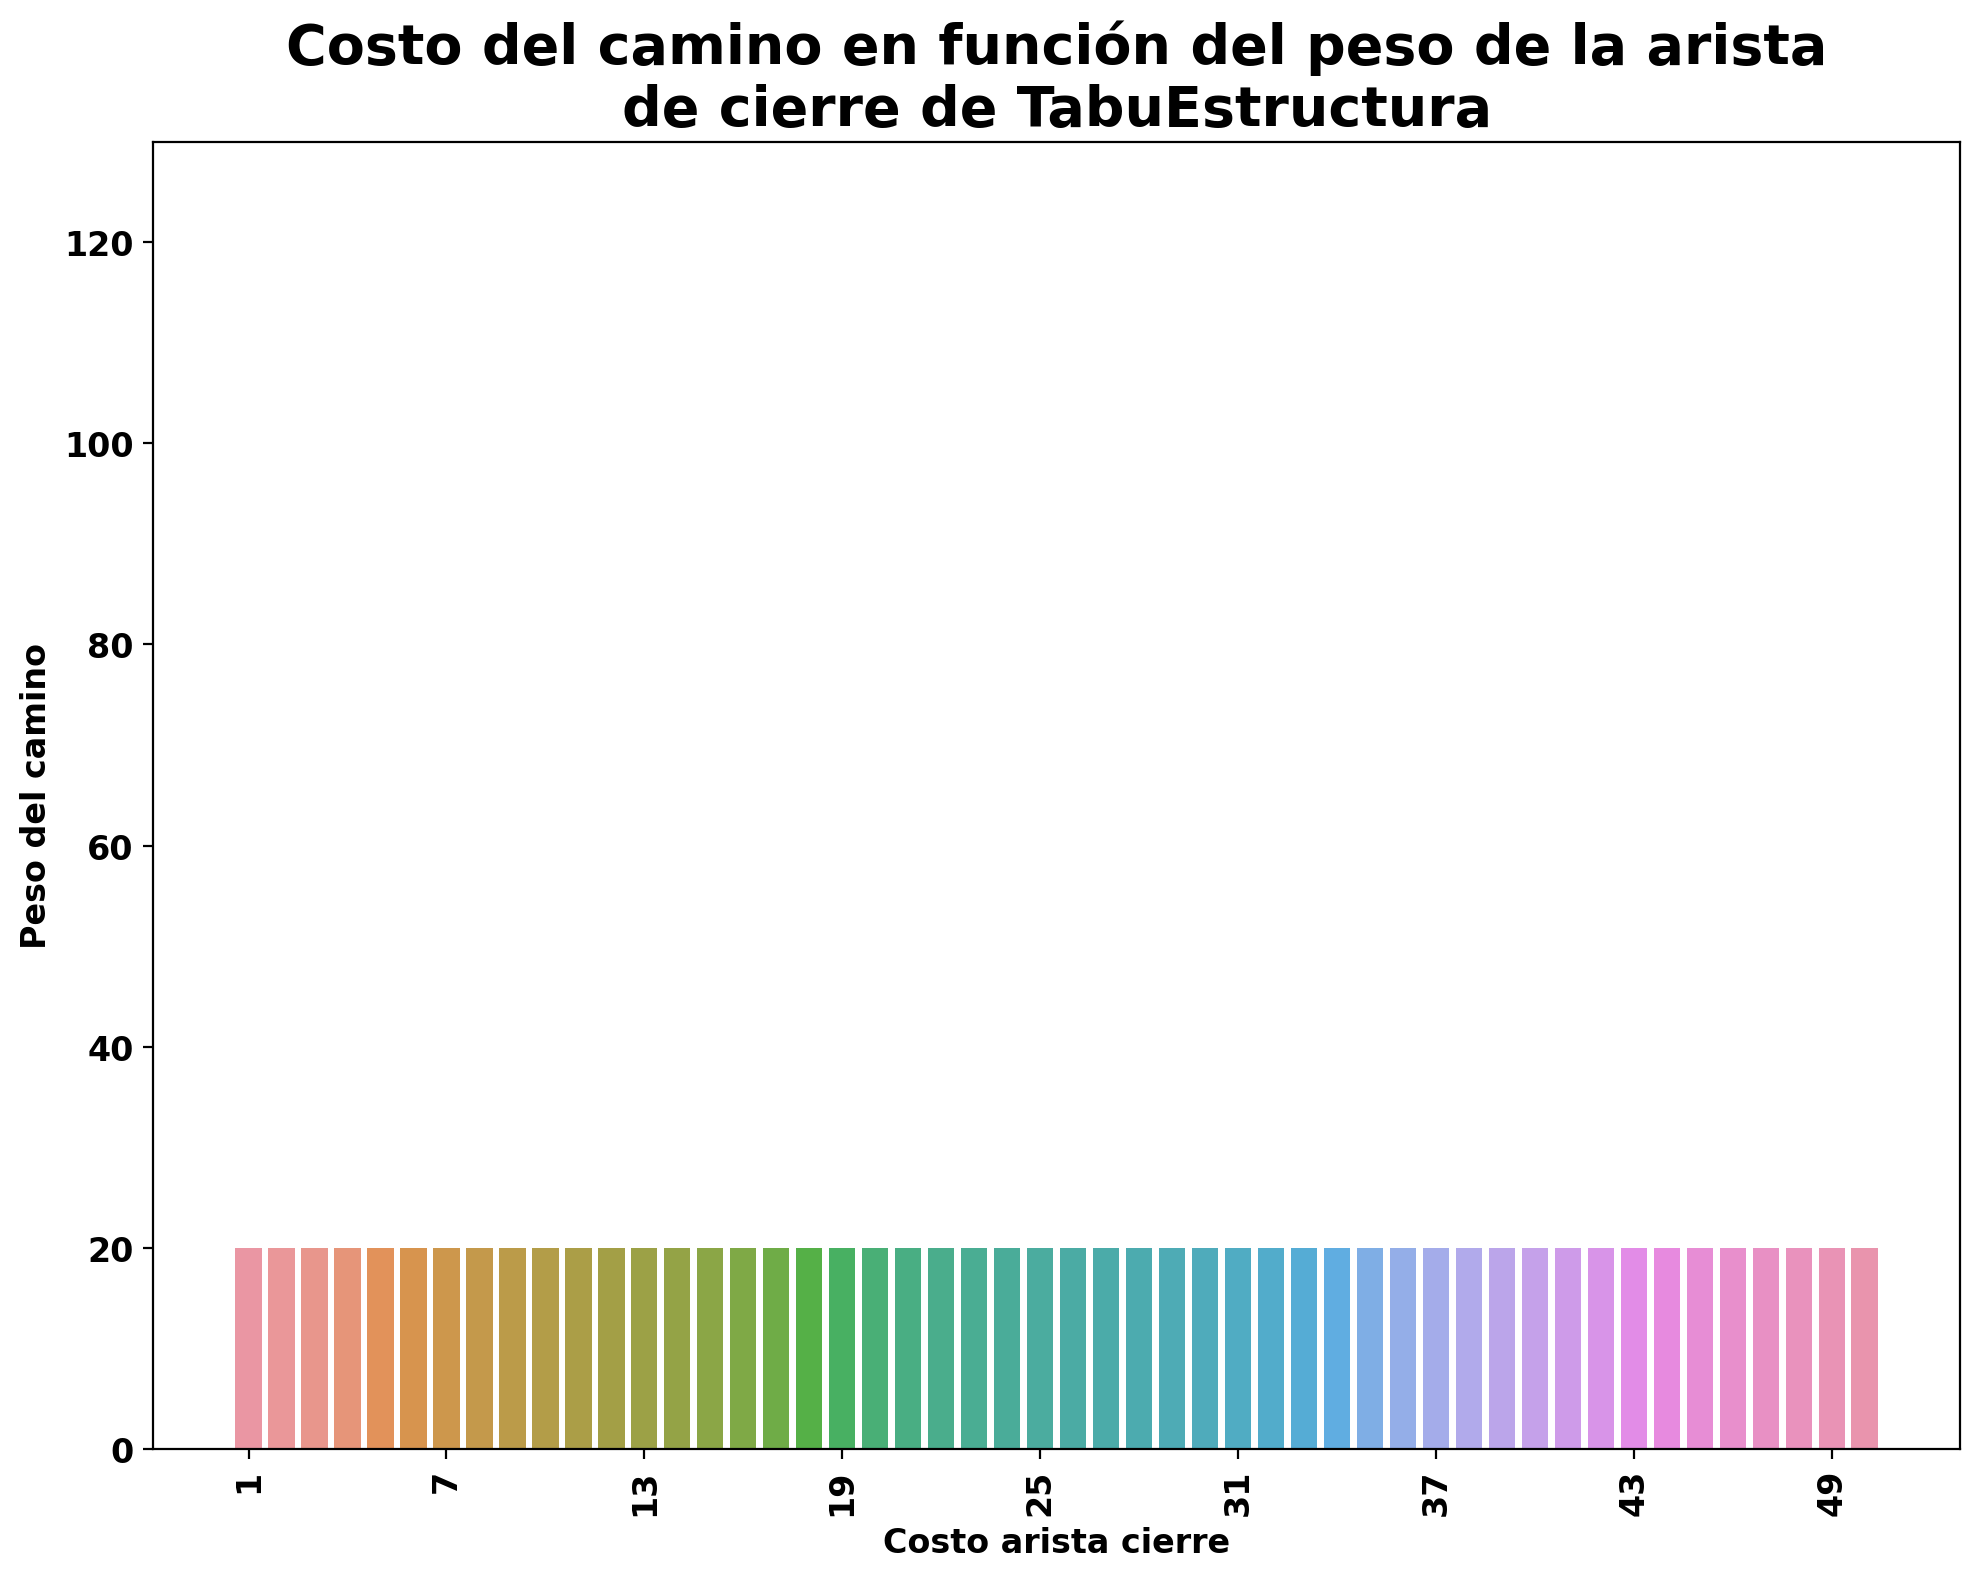

<Figure size 432x288 with 0 Axes>

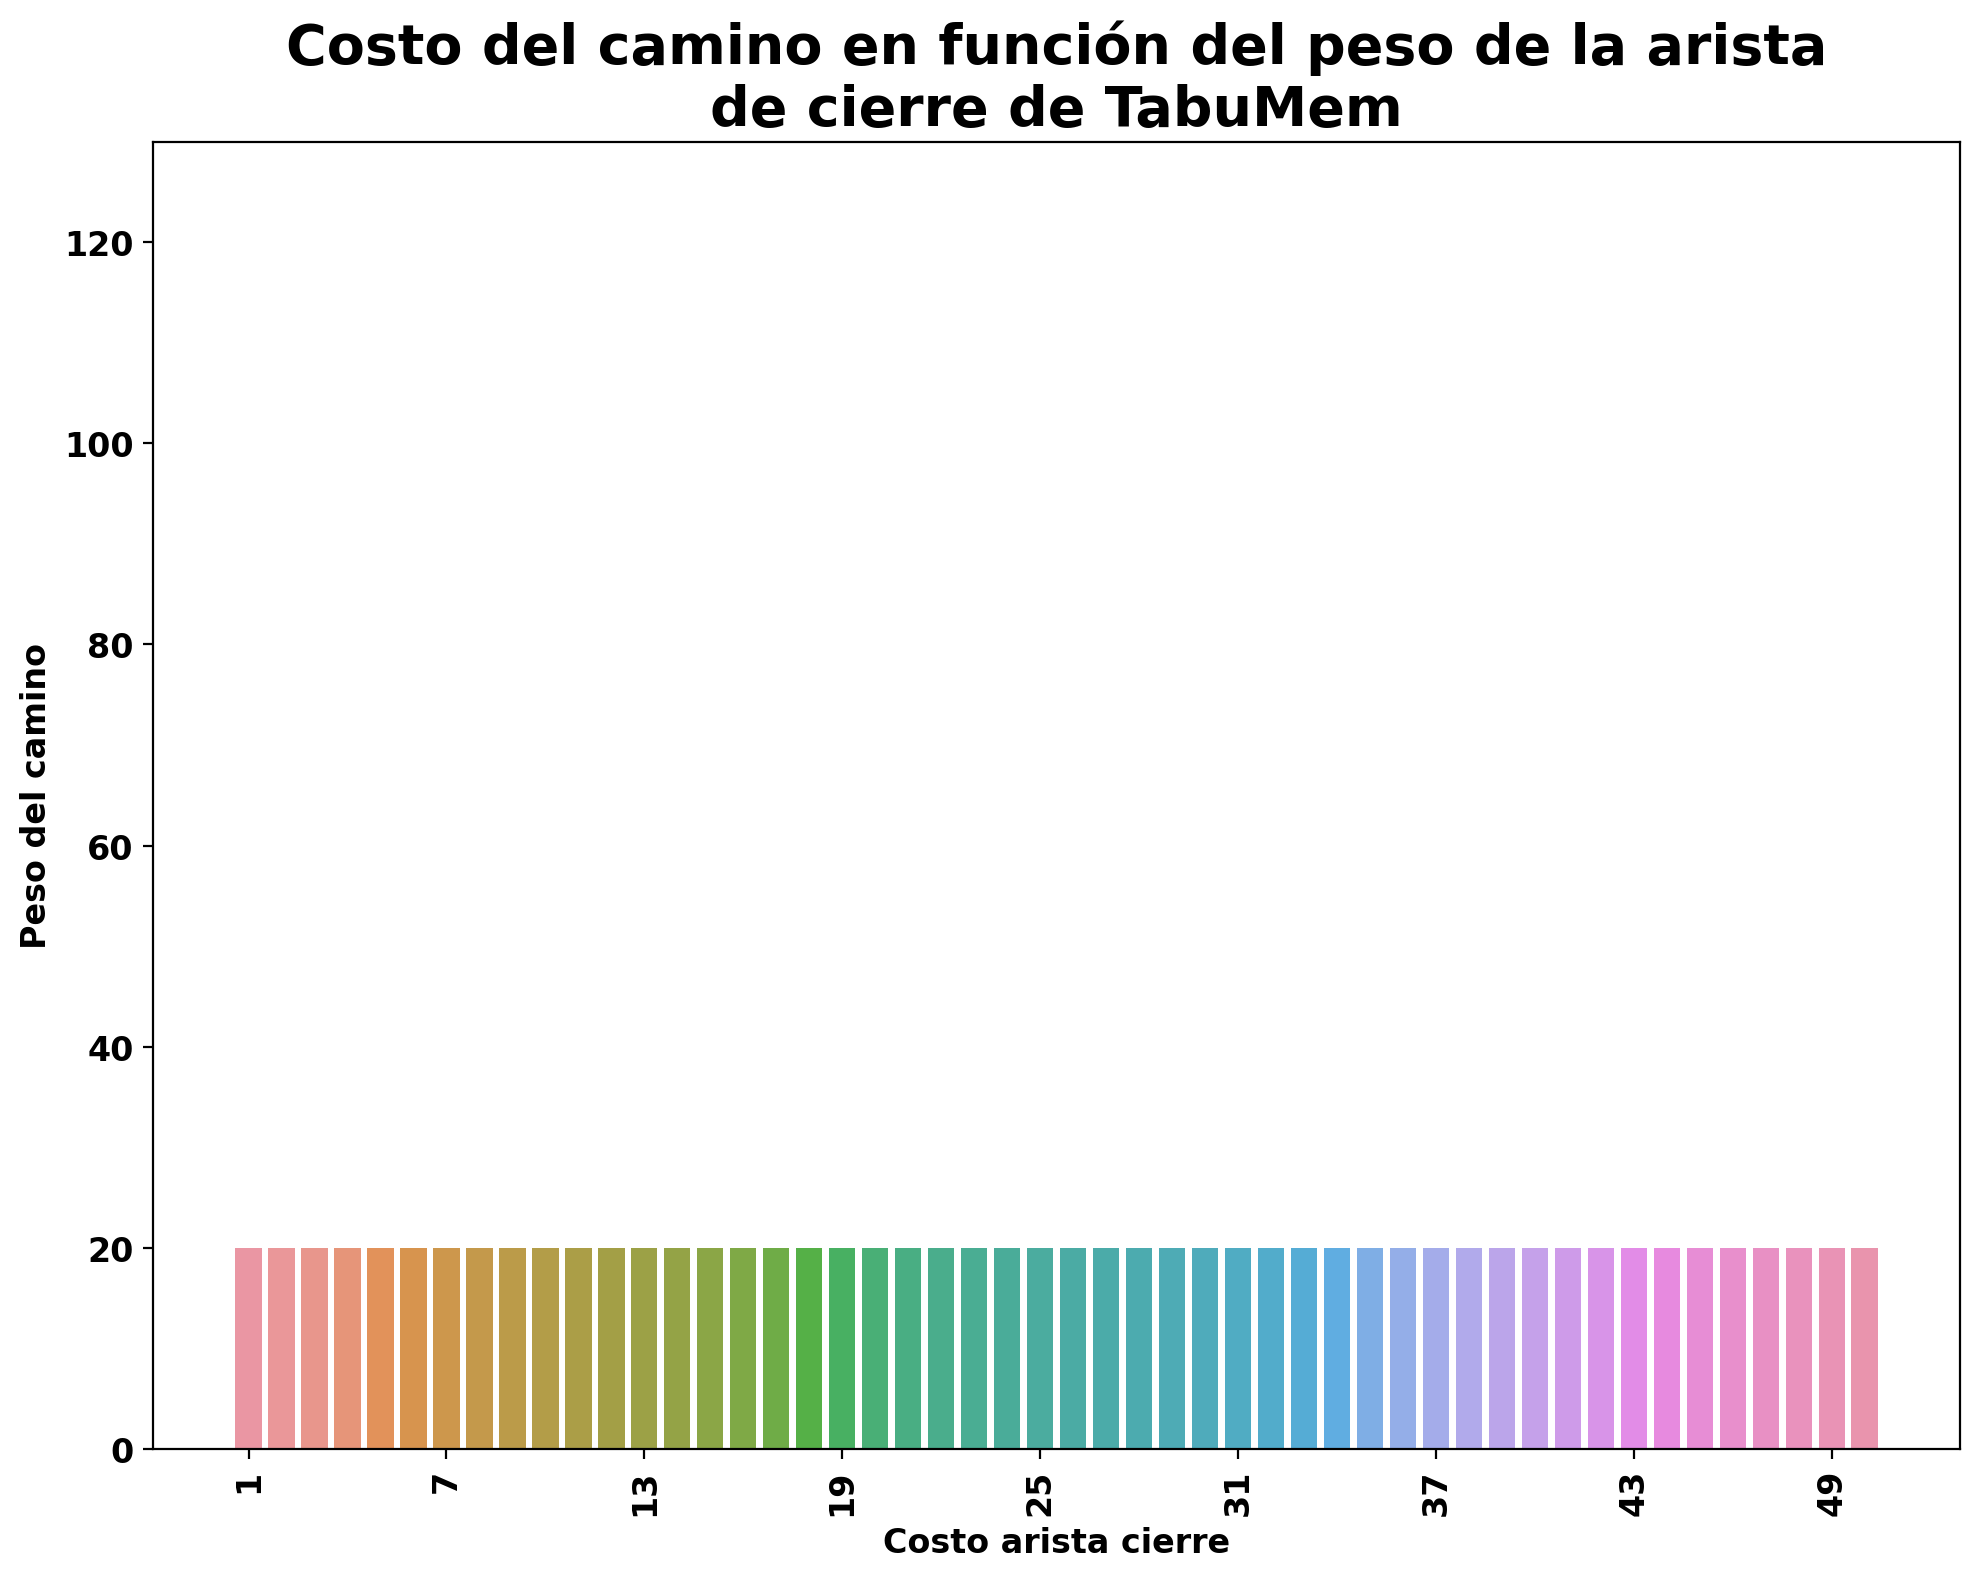

In [57]:
algoritmos =['MasCercano', 'MenorCosto', 'AGM', 'TabuEstructura', 'TabuMem']
for i in algoritmos:
    barplotPatologicos(dfPatoAGMPesos, todos=False, alg=i, save=False, out='graficos/patologicos/todos'+i+'.png')
    plt.show()